# Lending Club Case Study

You work for a consumer finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

 

The data given below contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

## Importing libs and creating common utility functions

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

sns.set(style="white")

def explain_dataframe(dataframe):
    print("Info : \n")
    display(dataframe.info())
    print("\n Description : ")
    display(dataframe.describe())
    
def standarizing_unique_key(dataframe, unique_key):
    dataframe[unique_key] = dataframe[unique_key].str.lower()
    display(dataframe[unique_key].describe())
    
def remove_columns_from_dataframe(dataframe, column_names):
    df_column_names_set = set(dataframe.columns)
    column_names_set = set(column_names)
    if len(column_names_set.intersection(df_column_names_set)) == len(column_names_set):
        dataframe = dataframe.drop(column_names, axis=1)
    else:
        print('All columns not present in data-frame to be removed')
    return dataframe

def column_wise_null_value_estimation(dataframe, missing_threshold = 0.01):
    # summing up the missing values (column-wise)
    missing_column_srs = round(100*(dataframe.isnull().sum()/len(dataframe.index)), 2)
    missing_column_srs = missing_column_srs[missing_column_srs >= missing_threshold]
    missing_column_srs = missing_column_srs.sort_values(ascending=False)
    return missing_column_srs

def outlier_assessment(dataframe, column_name):
    if column_name in dataframe.columns:
        percentile_lst = [.90,.91,.92,.93,.94,.95,.96,.97,.98,.99,1]
        outlier_assessemnt_df = pd.DataFrame(dataframe[column_name].quantile(percentile_lst))
        outlier_assessemnt_df['pct_change'] = outlier_assessemnt_df[column_name].pct_change().apply(lambda x: x*100)
        display(outlier_assessemnt_df)
    else:
        print("Column not present in data-frame")
    
def remove_outlier(dataframe, column_name, percentile_threshold):
    if column_name in dataframe.columns:
        return dataframe.loc[dataframe[column_name] <= dataframe[column_name].quantile(percentile_threshold)].copy()
    else:
        return dataframe
    
def univariate_analysis_for_quantitative_variable(dataframe, y_clmn_nme, x_clmn_nme = '', 
                                                  xsize = 10, ysize = 5, subplot = False, 
                                                  hist = True, yscale = 'linear', xlabel = '', ylabel = '', title = ''):
    df_column_names_set = set(dataframe.columns)
    column_names_set = {y_clmn_nme}
    
    if x_clmn_nme:
        column_names_set.add(x_clmn_nme)
        
    
    if len(column_names_set.intersection(df_column_names_set)) == len(column_names_set):
        x = dataframe[y_clmn_nme]
        
        if not xlabel:
            xlabel = x_clmn_nme.replace('_',' ').title()
            
        if not ylabel:
            ylabel = y_clmn_nme.replace('_',' ').title()
            
        if not title:
            title = 'Distribution of {0}'.format(ylabel).title()
        
        if not subplot:
            print('The min {:} is {:,.0f} and the max {:} is {:,.0f}'.format(y_clmn_nme, x.min(),
                                                                             y_clmn_nme, x.max()))
            print('The mean {:} is {:,.0f}, while median is {:,.0f}'.format(y_clmn_nme, x.mean(), x.median()))
            
            plt.figure(figsize=(xsize, ysize))
        
        if hist:
            plot = sns.distplot(x, bins=100)
        else:
            if x_clmn_nme:
                plot = sns.boxplot(x = x_clmn_nme, y = y_clmn_nme, data = dataframe)
            else:
                plot = sns.boxplot(y = x)
                
        plot.set(ylabel = ylabel)
        
        if not xlabel:
            plot.set(xlabel = xlabel)
            
        plt.title(title)
        plt.yscale(yscale)
        
        if not subplot:
            plt.show()
    else:
        print("Column not present in data-frame")
    
def univariate_analysis_for_categorical_variable(dataframe, column_name, xlabel = '', ylabel='',\
                                                 title = '', xsize = 6, ysize = 3, top = 0,\
                                                 rotate_lbl_degree = 0, yscale='linear', subplot = False, 
                                                 filter_value = 0):
    if not ylabel:
        ylabel = 'Total'
    if not title:
        title = 'Frequency of {0}'.format(xlabel).title()
    categorical_plot(dataframe, column_name, 'id', xlabel, ylabel, title, xsize, ysize, 
                     top, rotate_lbl_degree, 
                     'count', yscale, subplot, filter_value = filter_value)

def segmented_univariate_analysis(dataframe, x_clmn_nme, y_clmn_nme, xlabel = '', ylabel='', title = '',\
                                  xsize = 10, ysize = 5, top = 0, rotate_lbl_degree = 0,\
                                  estimator='mean', yscale='linear', subplot = False, filter_value = 0):
    categorical_plot(dataframe, x_clmn_nme, y_clmn_nme, xlabel, ylabel, title, xsize, ysize, 
                     top, rotate_lbl_degree, 
                     estimator, yscale, subplot, filter_value = filter_value)
    
def bivariate_analysis(dataframe, x_clmn_nme, y_clmn_nme, hue_clmn_nme, xlabel = '', ylabel='', huelabel = '', 
                       title = '', xsize = 10, ysize = 5, top = 0, rotate_lbl_degree = 0,
                       estimator='mean', yscale='linear', filter_value = 0, subplot = False):
    categorical_plot(dataframe, x_clmn_nme, y_clmn_nme, xlabel, ylabel, title, xsize, ysize, 
                     top, rotate_lbl_degree, estimator, yscale, subplot, hue_clmn_nme, huelabel, filter_value)
        
def categorical_plot(dataframe, x_clmn_nme, y_clmn_nme, xlabel = '', ylabel='', title = '',
                     xsize = 10, ysize = 5, top = 0, rotate_lbl_degree = 0,
                     estimator='mean', yscale='linear', subplot = False, hue_clmn_nme='', huelabel = '', 
                     filter_value = 0):
    if not xlabel:
        xlabel = x_clmn_nme.replace('_',' ').title()
    
    if not ylabel:
        ylabel = y_clmn_nme.replace('_',' ').title()
    
    if hue_clmn_nme and not huelabel:
        huelabel = hue_clmn_nme.replace('_',' ').title()
    
    if not title:
        title = '{:} of {:} by {:}'.format(estimator, xlabel, ylabel).title()
    
    df_column_names_set = set(dataframe.columns)
    column_names_set = {x_clmn_nme, y_clmn_nme}
    
    if hue_clmn_nme:
        column_names_set.add(hue_clmn_nme)
    
    if len(column_names_set.intersection(df_column_names_set)) == len(column_names_set):
        
        if hue_clmn_nme:
            x = pd.DataFrame(dataframe.groupby([x_clmn_nme, hue_clmn_nme])[y_clmn_nme].agg(estimator))
            x = x.sort_values(by=[y_clmn_nme, hue_clmn_nme, x_clmn_nme], ascending=False)
        else:
            x = pd.DataFrame(dataframe.groupby(x_clmn_nme)[y_clmn_nme].agg(estimator))
            x = x.sort_values(by=[y_clmn_nme, x_clmn_nme], ascending=False)
        
        if not subplot:
            print('For {:} value - {:} has max {:} value of {:,.0f}'
                  .format(xlabel, x.index[0], estimator, x.iloc[0,0]))
            print('For {:} value - {:} has min {:} value of {:,.0f}'
                  .format(xlabel, x.index[len(x) - 1], estimator, x.iloc[len(x) - 1, 0]))
        
        if filter_value > 0:
            x = x.loc[x[y_clmn_nme] > filter_value].copy()
            
        if not x.empty:
            x.reset_index(inplace=True)

            if top == 0:
                top = x[x_clmn_nme].shape[0]
            elif top > 0:
                x = pd.DataFrame(x.nlargest(top, [y_clmn_nme]))
            else:
                x = pd.DataFrame(x.nsmallest(abs(top), [y_clmn_nme]))

            if not subplot:
                plt.figure(figsize=(xsize, ysize))

            if hue_clmn_nme:
                plot = sns.barplot(x=x_clmn_nme, y=y_clmn_nme,hue = hue_clmn_nme, data=dataframe, 
                                   order=x[x_clmn_nme].unique(), 
                           hue_order=x[hue_clmn_nme].unique());
            else:
                plot = sns.barplot(x=x_clmn_nme, y=y_clmn_nme,data=x, order=x[x_clmn_nme].unique());

            plot.set(ylabel = ylabel, xlabel = xlabel)
            plt.title(title)
            plt.yscale(yscale)

            if huelabel:
                plot.legend(title = huelabel)

            if rotate_lbl_degree > 0:
                for label in plot.get_xticklabels():
                    label.set_rotation(rotate_lbl_degree)

            if hue_clmn_nme:        
                for p in plot.patches:
                    height = p.get_height()
                    if np.isnan(height):
                        height=0
                    plot.text(p.get_x()+p.get_width()/2.,height + 5,'{:,.0f}'.format(round(height,2)), ha="center") 
            else:
                for index, row in x.iterrows():
                    plot.text(row.name,row[y_clmn_nme], '{:,.0f}'.format(round(row[y_clmn_nme],2)), color='black', 
                              ha="center")

            if not subplot:
                plt.show()
            
        else:
            print('No data present to display')
    else:
        print("Columns not present in data-frame")
    
def quantitative_features_distribution(dataframe, numeric_data):
    np.seterr(divide='ignore', invalid='ignore')
    f = pd.melt(dataframe, value_vars=sorted(numeric_data))
    g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    
def variable_type_analysis(dataframe):
    numeric_data = dataframe.select_dtypes(include=(np.number))
    categorical_data = dataframe.select_dtypes(exclude=(np.number))
    print("Total number of quantitative variable and categorical variable is as follows : {0} , {1}"\
          .format(numeric_data.shape[1], categorical_data.shape[1]))
    return {0: numeric_data, 1: categorical_data}

def deriving_metrics_date(dataframe, column_name):
    if column_name in dataframe.columns:
        column_name_mth = column_name + '_mth'
        column_name_yr = column_name + '_yr'
    
        dataframe.loc[:, column_name_mth] = dataframe.loc[:, column_name].apply(lambda x: x.month)
        dataframe.loc[:, column_name_yr] = dataframe.loc[:, column_name].apply(lambda x: x.year)
        dataframe = remove_columns_from_dataframe(dataframe, [column_name])
        display(dataframe[[column_name_mth, column_name_yr]].describe())
    else:
        print("Column not present in data-frame")

def standardise_percentage_column(dataframe, column_name):
    if column_name in dataframe.columns:
        column_name_in_pct = column_name + '_in_pct'
        dataframe.loc[pd.notnull(dataframe[column_name]), column_name] = dataframe\
        .loc[pd.notnull(dataframe[column_name]), column_name]\
        .apply(lambda x: str(x)[0:-2].strip())
        dataframe[column_name] = pd.to_numeric(dataframe[column_name], errors='coerce')
        dataframe.rename(columns={column_name : column_name_in_pct}, inplace=True)
        display(dataframe[column_name_in_pct].describe())
    else:
        print("Column not present in data-frame")

def standardise_date_column(dataframe, column_name, date_format = '%b-%y'):
    if column_name in dataframe.columns:
        dataframe[column_name] = pd.to_datetime(dataframe[column_name], errors ='coerce', format = date_format)
        display(dataframe[column_name].describe())
    else:
        print("Column not present in data-frame")
        
def variable_analysis(dataframe, column_name, unique_val = True, freq_count=False, filter_value = 0):
    print('Describing column :\n{0}'.format(dataframe[column_name].describe()))
    if unique_val:
        print('\nUnique column values :\n{0}'.format(dataframe[column_name].unique()))
    if freq_count:
        freq_df = pd.DataFrame(dataframe.groupby(column_name).id.count())
        freq_df = freq_df.loc[(freq_df['id'] >= filter_value) if (filter_value >= 0) 
                              else (freq_df['id'] <= abs(filter_value))]\
        .copy()
        print('\nFrequency of values :\n{0}'.format(freq_df.sort_values(by='id' , ascending=False)))
    
def col_correlation_analysis(dataframe, column_names):
    display(pd.DataFrame(dataframe.loc[:,column_names]).corr())
    
def anova_analysis_categorical_data(dataframe, categoric_data): 
    np.seterr(divide='ignore', invalid='ignore')
    df = dataframe.copy()
    categoric=categoric_data.columns
    # We choose to analyse those features with unique values<100, to reduce complexity
    cat_features=categoric[categoric_data.nunique()<100] 
    df['loan_status_vector']=df['loan_status'].astype('category').cat.codes+1
    df[cat_features]=df[cat_features].fillna("Missing")
    anova={'feature':[],'f':[],'p':[]}
    for cat in cat_features:
        loanstat=[]
        for group in df[cat].unique():
            loanstat.append(df[df[cat]==group].loan_status_vector.values)
    
        f,p=stats.f_oneway(*loanstat)
    
        anova['feature'].append(cat)
        anova['f'].append(f)
        anova['p'].append(p)
    anova=pd.DataFrame(anova)
    anova=anova[['feature','f','p']]
    anova.sort_values('p',inplace=True)
    display(anova)
    
def anova_analysis_numeric_data(dataframe, numeric_df):
    np.seterr(divide='ignore', invalid='ignore')
    df1=dataframe.copy()
    numeric_col=numeric_df.columns
    # We choose to analyse those features with unique values<1200, to reduce complexity
    numeric_col=numeric_col[numeric_df.nunique()<1200] 
    df1[numeric_col]=df1[numeric_col].fillna("Missing")
    df1['loan_status_vector']=df1['loan_status'].astype('category').cat.codes+1
    anova={'feature':[],'f':[],'p':[]}
    for cat in numeric_col:
        loanstat=[]
        for group in df1[cat].astype('category').unique():
            loanstat.append(df1[df1[cat]==group].loan_status_vector.values)    
        f,p=stats.f_oneway(*loanstat)
        anova['feature'].append(cat)
        anova['f'].append(f)
        anova['p'].append(p)
    anova=pd.DataFrame(anova)
    anova=anova[['feature','f','p']]
    anova.sort_values('p',inplace=True)
    display(anova)

## Data Sourcing

In [189]:
loan_df = pd.read_csv('./loan.csv', encoding='utf-8', dtype={'last_pymnt_amnt':np.float64}, low_memory=False)
explain_dataframe(loan_df)

Info : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


None


 Description : 


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,...,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,...,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,...,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
75%,8.377550e+05,1.047339e+06,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,...,NaN,NaN,NaN,NaN,2.000000,0.0,NaN,NaN,NaN,NaN


### Identifying unique key

In [190]:
display(loan_df.id.astype('category').describe())
display(loan_df.url.describe())

count       39717
unique      39717
top       1077501
freq            1
Name: id, dtype: int64

count                                                 39717
unique                                                39717
top       https://lendingclub.com/browse/loanDetail.acti...
freq                                                      1
Name: url, dtype: object

<b>id</b> column can be used as unique identifier

## Data Cleaning

### Fix rows and columns

#### Unnecessary columns

##### Identify columns with any missing values

In [191]:
column_wise_null_value_estimation(loan_df)

total_il_high_credit_limit        100.00
mo_sin_old_rev_tl_op              100.00
bc_util                           100.00
bc_open_to_buy                    100.00
total_bc_limit                    100.00
acc_open_past_24mths              100.00
inq_last_12m                      100.00
total_cu_tl                       100.00
inq_fi                            100.00
total_rev_hi_lim                  100.00
all_util                          100.00
max_bal_bc                        100.00
open_rv_24m                       100.00
open_rv_12m                       100.00
il_util                           100.00
total_bal_il                      100.00
mths_since_rcnt_il                100.00
open_il_24m                       100.00
open_il_12m                       100.00
open_il_6m                        100.00
open_acc_6m                       100.00
tot_cur_bal                       100.00
tot_coll_amt                      100.00
verification_status_joint         100.00
dti_joint       

##### Dropping columns with 100 percent missing values

In [192]:
columns_with_missing_values = column_wise_null_value_estimation(loan_df, 100)
print("Total number of columns having more than 100 percent missing values : {0} ".format(len(columns_with_missing_values.index)))
loan_df.drop(columns=columns_with_missing_values.index, inplace=True)

print("Total number of columns remaining : {0} ".format(len(loan_df.columns)))

Total number of columns having more than 100 percent missing values : 54 
Total number of columns remaining : 57 


### Missing Values

#### Remaining columns with missing values

In [193]:
column_wise_null_value_estimation(loan_df)

next_pymnt_d                  97.13
mths_since_last_record        92.99
mths_since_last_delinq        64.66
desc                          32.58
emp_title                      6.19
emp_length                     2.71
pub_rec_bankruptcies           1.75
last_pymnt_d                   0.18
chargeoff_within_12_mths       0.14
collections_12_mths_ex_med     0.14
revol_util                     0.13
tax_liens                      0.10
title                          0.03
last_credit_pull_d             0.01
dtype: float64

#### Missing Value analysis and cleaning for remaining columns

1) <b>next_pymnt_d</b> : Next scheduled payment date

In [194]:
# Analysis
loan_df.next_pymnt_d.describe()    

count       1140
unique         2
top       Jun-16
freq        1125
Name: next_pymnt_d, dtype: object

In [195]:
# next_pymnt_d : Dropping the column as it seems to be not of any significance
loan_df = remove_columns_from_dataframe(loan_df,['next_pymnt_d'])
column_wise_null_value_estimation(loan_df)

mths_since_last_record        92.99
mths_since_last_delinq        64.66
desc                          32.58
emp_title                      6.19
emp_length                     2.71
pub_rec_bankruptcies           1.75
last_pymnt_d                   0.18
chargeoff_within_12_mths       0.14
collections_12_mths_ex_med     0.14
revol_util                     0.13
tax_liens                      0.10
title                          0.03
last_credit_pull_d             0.01
dtype: float64

2) <b>mths_since_last_record</b> : The number of months since the last public record.

In [196]:
# Analysis
display(loan_df.mths_since_last_record.describe())

count    2786.000000
mean       69.698134
std        43.822529
min         0.000000
25%        22.000000
50%        90.000000
75%       104.000000
max       129.000000
Name: mths_since_last_record, dtype: float64

In [197]:
# mths_since_last_record : Dropping the column as it seems to be not of any significance
loan_df = remove_columns_from_dataframe(loan_df,['mths_since_last_record'])
column_wise_null_value_estimation(loan_df)

mths_since_last_delinq        64.66
desc                          32.58
emp_title                      6.19
emp_length                     2.71
pub_rec_bankruptcies           1.75
last_pymnt_d                   0.18
chargeoff_within_12_mths       0.14
collections_12_mths_ex_med     0.14
revol_util                     0.13
tax_liens                      0.10
title                          0.03
last_credit_pull_d             0.01
dtype: float64

3) <b>mths_since_last_delinq</b> - The number of months since the borrower's last delinquency.

In [198]:
# Analysis
display(loan_df.mths_since_last_delinq.describe())

count    14035.000000
mean        35.900962
std         22.020060
min          0.000000
25%         18.000000
50%         34.000000
75%         52.000000
max        120.000000
Name: mths_since_last_delinq, dtype: float64

In [199]:
# Correction
loan_df.fillna(value={'mths_since_last_delinq':0}, inplace=True)
column_wise_null_value_estimation(loan_df)

desc                          32.58
emp_title                      6.19
emp_length                     2.71
pub_rec_bankruptcies           1.75
last_pymnt_d                   0.18
chargeoff_within_12_mths       0.14
collections_12_mths_ex_med     0.14
revol_util                     0.13
tax_liens                      0.10
title                          0.03
last_credit_pull_d             0.01
dtype: float64

4) <b>desc</b> : Loan description provided by the borrower

In [200]:
# Analysis
loan_df.desc.describe()

count     26777
unique    26527
top            
freq        210
Name: desc, dtype: object

In [201]:
# desc : Dropping the column as it seems to be not of any significance
loan_df = remove_columns_from_dataframe(loan_df,['desc'])
column_wise_null_value_estimation(loan_df)

emp_title                     6.19
emp_length                    2.71
pub_rec_bankruptcies          1.75
last_pymnt_d                  0.18
chargeoff_within_12_mths      0.14
collections_12_mths_ex_med    0.14
revol_util                    0.13
tax_liens                     0.10
title                         0.03
last_credit_pull_d            0.01
dtype: float64

5) <b>emp_title</b> : The job title supplied by the Borrower when applying for the loan.*

In [202]:
display(loan_df['emp_title'].describe())
print('Missing values in emp_title : {0}'.format(loan_df.emp_title.isnull().sum()))

count       37258
unique      28820
top       US Army
freq          134
Name: emp_title, dtype: object

Missing values in emp_title : 2459


<b>US Army</b> is the top value in <b>emp_title</b>. Adding the same to missing values will add bias to <b>emp_title</b>. 
Since we are not sure if <b>emp_title</b> is going to influence the loan decision, dropping rows with missing <b>emp_title</b> could result in data-loss for other relevant features. Hence, not taking any corrective measure for missing values in <b>emp_title</b> for now. 

6) <b>emp_length</b> : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [203]:
display(loan_df.emp_length.describe())

print('Missing values in emp_length : {0}'.format(loan_df.emp_length.isnull().sum()))

count         38642
unique           11
top       10+ years
freq           8879
Name: emp_length, dtype: object

Missing values in emp_length : 1075


<b>10+ years</b> is the top value in <b>emp_length</b>. Adding the same to missing values will add bias to <b>emp_length</b>. 
Since we are not sure if <b>emp_length</b> is going to influence the loan decision, dropping rows with missing <b>emp_length</b> could result in data-loss for other relevant features. Hence, not taking any corrective measure for missing values in <b>emp_length</b> for now. 

##### Remaining column are not missing significant number of missing values, hence, skipping the missing column values analysis and cleaning for now to identify variables having more significance in analysis

##### Finding Numeric and Quantative variables available in data-set

In [204]:
variable_data_analysis = variable_type_analysis(loan_df)
numeric_data = variable_data_analysis[0]
categorical_data = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 32 , 22


##### Anova Analysis for Categorical Variables

**INFERENCE: Following features have a high significance towards loan status (Fully paid, charged off)<br>The order of significance from high to low is as follows:<br>out_prncp_inv & out_prncp: We would be interested in features that give a strong indicator ahead of loan issue. since this feature is observed after charge off, we would not be interested <br>chargeoff_within_12_mths: Same case with chargeoff within 12 months <br>The other significant contributors are 'collections_12_mths_ex_med' followed by 'tax_liens'**

In [205]:
# Commented due to time-taken in execution
anova_analysis_categorical_data(loan_df, categorical_data)

,feature,f,p
0,term,1.862384e+03,0.000000e+00
1,grade,3.149776e+02,0.000000e+00
2,sub_grade,5.948001e+01,0.000000e+00
7,loan_status,3.598871e+19,0.000000e+00
9,purpose,3.087806e+01,2.916304e-77
6,issue_d,7.300489e+00,6.784345e-53
5,verification_status,7.504526e+01,2.949091e-33
3,emp_length,8.180296e+00,1.750685e-14
10,addr_state,3.156068e+00,7.579305e-13
4,home_ownership,2.748047e+00,2.666600e-02


In [206]:
## Commented due to time-taken in execution
anova_analysis_numeric_data(loan_df, numeric_data)

,feature,f,p
3,inq_last_6mths,25.657530,6.381935e-40
0,loan_amnt,1.670940,1.471068e-31
1,funded_amnt,1.576743,1.126931e-28
6,pub_rec,26.655308,4.095059e-22
15,pub_rec_bankruptcies,27.387419,1.099388e-17
7,total_acc,1.551256,1.104692e-03
5,open_acc,1.724592,3.300016e-03
4,mths_since_last_delinq,1.350981,1.337265e-02
2,delinq_2yrs,2.166979,1.689918e-02
16,tax_liens,5.330948,2.095509e-02


### Filter Data

#### Columns not relevant to analysis

1) <b>initial_list_status</b>: The initial listing status of the loan. Possible values are – W, F

In [207]:
# Analysis
variable_analysis(loan_df, 'initial_list_status')

Describing column :
count     39717
unique        1
top           f
freq      39717
Name: initial_list_status, dtype: object

Unique column values :
['f']


In [208]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df,['initial_list_status'])

2) <b>application_type</b>: Indicates whether the loan is an individual application or a joint application with two co-borrowers

In [209]:
# Analysis
variable_analysis(loan_df, 'application_type')

Describing column :
count          39717
unique             1
top       INDIVIDUAL
freq           39717
Name: application_type, dtype: object

Unique column values :
['INDIVIDUAL']


In [210]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df,['application_type'])

3) <b>pymnt_plan</b> : Indicates if a payment plan has been put in place for the loan

In [211]:
# Analysis
variable_analysis(loan_df, 'pymnt_plan')

Describing column :
count     39717
unique        1
top           n
freq      39717
Name: pymnt_plan, dtype: object

Unique column values :
['n']


In [212]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df,['pymnt_plan'])

4) <b>url</b> : URL for the LC page with listing data.

In [213]:
# Analysis
variable_analysis(loan_df, 'url', unique_val=False)

Describing column :
count                                                 39717
unique                                                39717
top       https://lendingclub.com/browse/loanDetail.acti...
freq                                                      1
Name: url, dtype: object


In [214]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df,['url'])

5) <b>total_rec_late_fee</b>: Late fees received to date

In [215]:
# Analysis
variable_analysis(loan_df, 'total_rec_late_fee', unique_val=False)

Describing column :
count    39717.000000
mean         1.363015
std          7.289979
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64


In [216]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df, ['total_rec_late_fee'])

6) <b>revol_bal</b>: Total credit revolving balance

In [217]:
# Analysis
outlier_assessment(loan_df, 'revol_bal')

,revol_bal,pct_change
0.90,29144.40,NaN
0.91,30905.68,6.043288
0.92,32860.64,6.325569
0.93,35172.88,7.036503
0.94,38107.56,8.343587
0.95,41656.40,9.312693
0.96,46152.32,10.792867
0.97,53077.40,15.004836
0.98,63471.36,19.582647
0.99,83101.88,30.928154


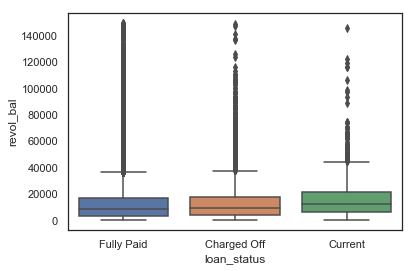

In [218]:
ax = sns.boxplot(x="loan_status", y="revol_bal", data=loan_df)

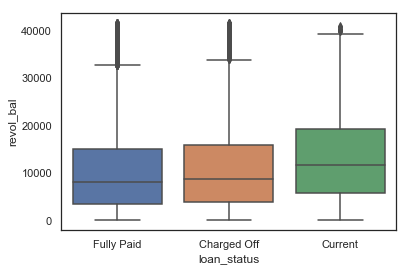

In [219]:
# Correction
# Since a huge jump noticed between 94 and 95th percentile, the values above 95th percentile were considered as outliers
df=remove_outlier(loan_df,'revol_bal', 0.95)
ax = sns.boxplot(x="loan_status", y="revol_bal",data=df)

In [220]:
# Analysis
variable_analysis(loan_df, 'revol_bal')

Describing column :
count     39717.000000
mean      13382.528086
std       15885.016641
min           0.000000
25%        3703.000000
50%        8850.000000
75%       17058.000000
max      149588.000000
Name: revol_bal, dtype: float64

Unique column values :
[13648  1687  2956 ... 27185 66033 85607]


In [221]:
# Correction
# Since no significant deviation observed between the population, 'defaulters' and 'non-defaulters', 
# the 'revol_bal' feature is removed
loan_df = loan_df = remove_columns_from_dataframe(loan_df, ['revol_bal'])

7) <b>total_acc</b>: The total number of credit lines currently in the borrower's credit file

In [222]:
# Analysis
variable_analysis(loan_df, 'total_acc')

Describing column :
count    39717.000000
mean        22.088828
std         11.401709
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

Unique column values :
[ 9  4 10 37 38 12 11 13  3 23 34 29 28 42 14 22 21 17  7 31 44 26 16  6
 18 27 24 25 40 35  8 20 15 19 36 51 32 30 33 46  5 61 56 50 41 39 79 62
 43 47 53 45 60 55 52 58 54 57 49 63 48 59 77 87 75 72 64 67 78 76 74 66
 81 90 80 71 69 73 70 68 65  2]


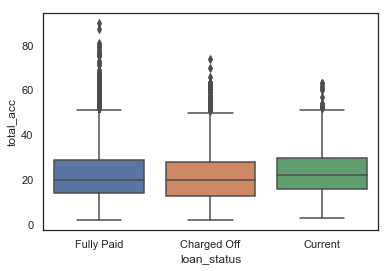

In [223]:
ax = sns.boxplot(x="loan_status", y="total_acc", data=loan_df)

In [224]:
# Correction
# Inference from box plots: No significant deviation observed between 'defaulter' and 'non-defaulter' 
# with feature 'total acc'
# Hence the feature 'total_acc' is removed from dataframe
loan_df = loan_df = remove_columns_from_dataframe(loan_df, ['total_acc'])

8) <b>recoveries</b>: post charge off gross recovery

In [225]:
# Analysis
variable_analysis(loan_df, 'recoveries')

Describing column :
count    39717.000000
mean        95.221624
std        688.744771
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      29623.350000
Name: recoveries, dtype: float64

Unique column values :
[  0.   117.08 189.06 ... 304.2   35.7   21.29]


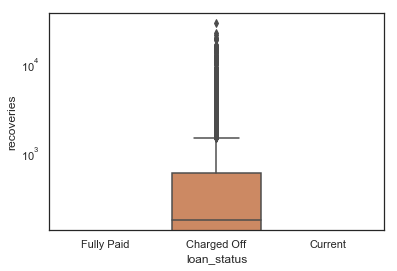

In [226]:
ax = sns.boxplot(x="loan_status", y="recoveries", data=loan_df)
plt.yscale('log')
plt.show()

In [227]:
# Correction
# The feature 'recoveries' has a strong bias with respect to sub category 'defaulters'
# Perhaps this is because, recovery happens after charge off
# Since our interest is to select features that would help identify a charge off, 
# this feature 'recoveries' is removed from further analysis
loan_df = remove_columns_from_dataframe(loan_df, ['recoveries'])

9) <b>collection_recovery_fee</b>: post charge off collection fee<br>

In [228]:
# Analysis
variable_analysis(loan_df, 'collection_recovery_fee')

Describing column :
count    39717.000000
mean        12.406112
std        148.671593
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7002.190000
Name: collection_recovery_fee, dtype: float64

Unique column values :
[0.0000e+00 1.1100e+00 2.0900e+00 ... 6.6836e+02 4.4425e+02 2.3000e-01]


In [229]:
# Correction
# For the similar reason explained for feature 'recoveries', the 'collection_recovery_fee' is removed from further analysis
loan_df = remove_columns_from_dataframe(loan_df, ['collection_recovery_fee'])

10) <b>out_prncp</b>: Remaining outstanding principal for total amount funded

In [230]:
# Analysis
variable_analysis(loan_df, 'out_prncp', unique_val = False)
display(loan_df.groupby('loan_status')['out_prncp'].sum())

Describing column :
count    39717.000000
mean        51.227887
std        375.172839
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6311.470000
Name: out_prncp, dtype: float64


loan_status
Charged Off          0.0
Current        2034618.0
Fully Paid           0.0
Name: out_prncp, dtype: float64

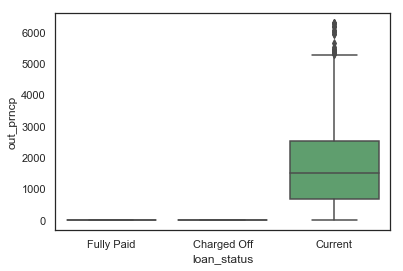

In [231]:
ax = sns.boxplot(x="loan_status", y="out_prncp", data=loan_df)

In [232]:
# Correction
# Since the out_prncp is more significant for the current customers, it was removed from further analysis
loan_df = remove_columns_from_dataframe(loan_df, ['out_prncp'])

11) <b>out_prncp_inv</b>: Remaining outstanding principal for portion of total amount funded by investors

In [233]:
# Analysis
variable_analysis(loan_df, 'out_prncp_inv', unique_val = False)
display(loan_df.groupby('loan_status')['out_prncp_inv'].sum())

Describing column :
count    39717.000000
mean        50.989768
std        373.824457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6307.370000
Name: out_prncp_inv, dtype: float64


loan_status
Charged Off          0.00
Current        2025160.62
Fully Paid           0.00
Name: out_prncp_inv, dtype: float64

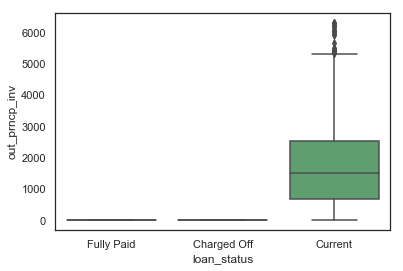

In [234]:
ax = sns.boxplot(x="loan_status", y="out_prncp_inv", data=loan_df)

In [235]:
# Correction
# Since the out_prncp_inv is more significant for the current customers, it was removed from further analysis
loan_df = remove_columns_from_dataframe(loan_df, ['out_prncp_inv'])

##### Finding Numeric and Quantative variables available in data-set

In [236]:
variable_data_analysis = variable_type_analysis(loan_df)
numeric_data = variable_data_analysis[0]
categorical_data = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 25 , 18


##### Finding corelation between numeric data

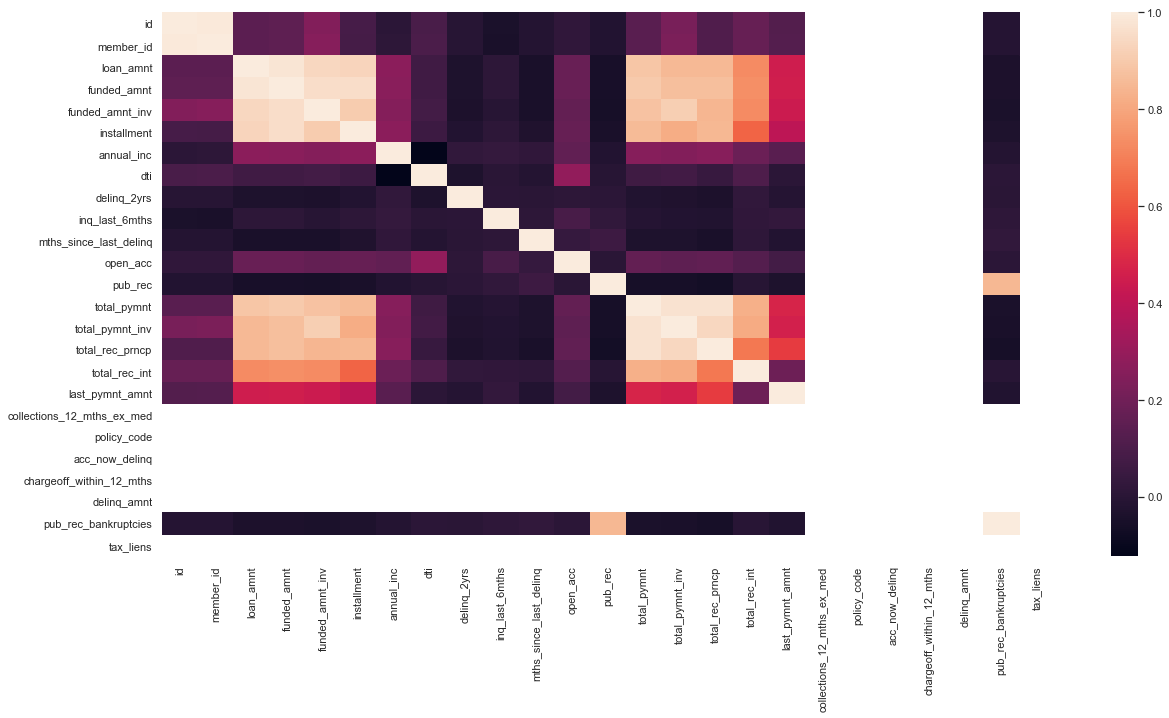

In [237]:
plt.figure(figsize=(20,10))
sns.heatmap(numeric_data.corr())

#### Dropping columns having only 1 or missing values:
> a) <b>acc_now_delinq</b>: The number of accounts on which the borrower is now delinquent.<br>
b) <b>chargeoff_within_12_mths</b>: Number of charge-offs within 12 months<br>
c) <b>collections_12_mths_ex_med</b>: Number of collections in 12 months excluding medical collections<br>
d) <b>delinq_amnt</b>: The past-due amount owed for the accounts on which the borrower is now delinquent.<br>
e) <b>policy_code</b>: publicly available policy_code=1, new products not publicly available policy_code=2<br>
f) <b>tax_liens</b>: Number of tax liens<br>

In [238]:
loan_df = remove_columns_from_dataframe(loan_df, ['acc_now_delinq','chargeoff_within_12_mths',\
                                                 'collections_12_mths_ex_med','delinq_amnt',\
                                                 'policy_code', 'tax_liens'])



##### Cleaning highly corelated variables

1) <b>Correlation block of:</b>
>a) <b>member_id</b> : A unique LC assigned Id for the borrower member. <br>
b) <b>id</b>: A unique LC assigned ID for the loan listing.

In [239]:
# Analysis
col_correlation_analysis(loan_df, ['id','member_id'])

,id,member_id
id,1.00000,0.99365
member_id,0.99365,1.00000


In [240]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df, ['member_id'])

2) <b>Correlation block of:</b>
>a) <b>loan_amnt</b>: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.<br>
b) <b>funded_amnt</b>: The total amount committed to that loan at that point in time.<br>
c) <b>funded_amnt_inv</b>: The total amount committed by investors for that loan at that point in time.<br>


In [241]:
# Analysis
col_correlation_analysis(loan_df, ['loan_amnt','funded_amnt','funded_amnt_inv', 'installment'])

,loan_amnt,funded_amnt,funded_amnt_inv,installment
loan_amnt,1.000000,0.981578,0.940034,0.930288
funded_amnt,0.981578,1.000000,0.958422,0.956159
funded_amnt_inv,0.940034,0.958422,1.000000,0.905039
installment,0.930288,0.956159,0.905039,1.000000


<font color=black>**Despite having high co-relation, we propose to retain 'installment' for further analysis.**</font>

In [242]:
# Correcion
loan_df = remove_columns_from_dataframe(loan_df, ['funded_amnt','funded_amnt_inv'])

3) <b>Correlation block of:</b>
>a) <b>total_pymnt</b>: Payments received to date for total amount funded<br>
b) <b>total_pymnt_inv</b>: Payments received to date for portion of total amount funded by investors<br>
c) <b>total_rec_int</b>: Interest received to date<br>
d) <b>total_rec_prncp</b>: Principal received to date<br>

In [243]:
# Analysis
col_correlation_analysis(loan_df, ['total_pymnt','total_pymnt_inv','total_rec_int','total_rec_prncp'])

,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_prncp
total_pymnt,1.000000,0.970815,0.828758,0.971472
total_pymnt_inv,0.970815,1.000000,0.815615,0.939581
total_rec_int,0.828758,0.815615,1.000000,0.684027
total_rec_prncp,0.971472,0.939581,0.684027,1.000000


**<font color=black> Despite having high co-relation with each other, we propose to retain 'total_pymnt','total_rec_int' and'total_rec_prncp' for further analysis. <br> To calculate loss due to specific defaulter, we will need these features </font>**

In [244]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df, ['total_pymnt_inv'])

4) <b>Correlation block of:</b>
>a) <b>loan_amnt</b>: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.<br>
b) <b>total_pymnt</b>: Payments received to date for total amount funded<br>

In [245]:
# Analysis
col_correlation_analysis(loan_df, ['loan_amnt', 'total_pymnt'])

,loan_amnt,total_pymnt
loan_amnt,1.000000,0.886613
total_pymnt,0.886613,1.000000


<font color=black> **For the reasons mentioned above, we propose to retain total_pymnt.** </font> 

5) <b>Correlation block of:</b>
>a) <b>pub_rec</b>: Number of derogatory public records<br>
b) <b>pub_rec_bankruptcies</b>: Number of public record bankruptcies

In [246]:
# Analysis
col_correlation_analysis(loan_df, ['pub_rec','pub_rec_bankruptcies'])

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.847305
pub_rec_bankruptcies,0.847305,1.000000


In [247]:
# Correction
loan_df = remove_columns_from_dataframe(loan_df, ['pub_rec_bankruptcies'])

##### Revaluating Numeric and Quantative variables available in data-set

In [248]:
variable_data_analysis = variable_type_analysis(loan_df)
numeric_data = variable_data_analysis[0]
categorical_data = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 14 , 18


##### Revaluating corelation between numeric data

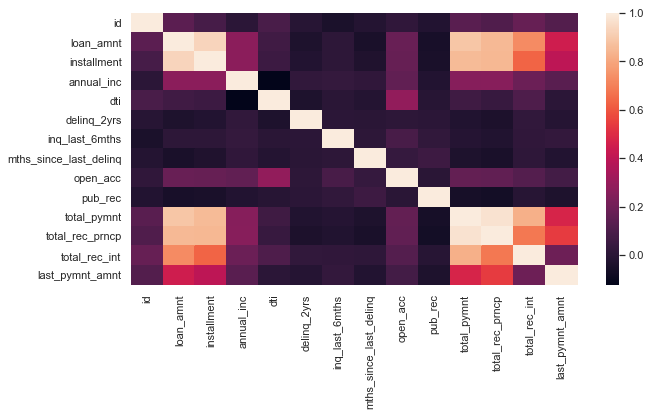

In [249]:
plt.figure(figsize=(10,5))
sns.heatmap(numeric_data.corr())

### Standardising Numbers

#### Analysing Quantitative Variables

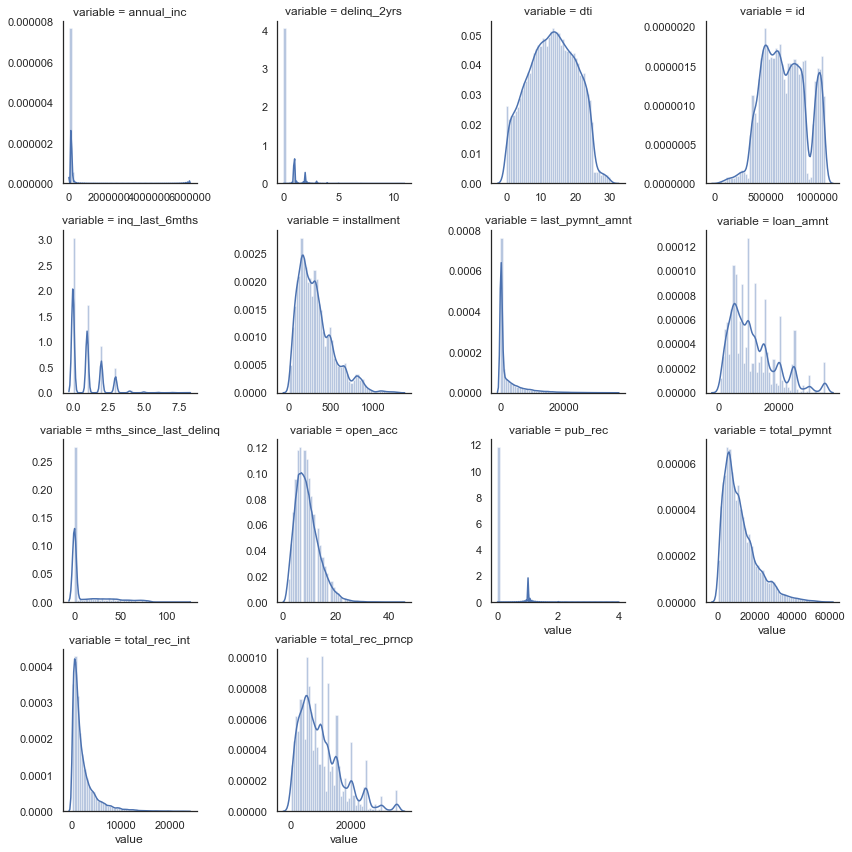

In [250]:
quantitative_features_distribution(loan_df, numeric_data)

#### Remove outliers


1) <b>annual_inc</b>: The self-reported annual income provided by the borrower during registration.

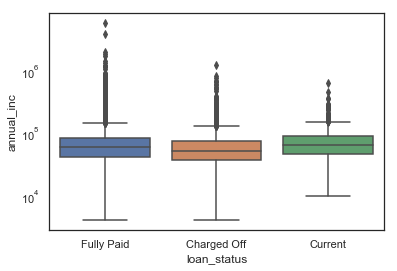

In [251]:
sns.boxplot(x="loan_status", y="annual_inc", data=loan_df)
plt.yscale('log')
plt.show()

In [252]:
# Analysis
outlier_assessment(loan_df, 'annual_inc')

,annual_inc,pct_change
0.90,116000.00,NaN
0.91,120000.00,3.448276
0.92,123000.00,2.500000
0.93,128371.80,4.367317
0.94,135000.00,5.163284
0.95,142000.00,5.185185
0.96,150000.00,5.633803
0.97,165757.92,10.505280
0.98,187000.00,12.815122
0.99,234999.36,25.668107


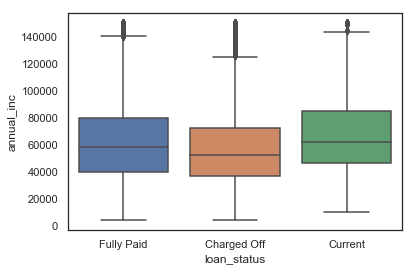

In [253]:
# Correction
# Since a huge jump noticed between 95 and 96th percentile, the values above 96th percentile were considered as outliers
loan_df = remove_outlier(loan_df, 'annual_inc', .96)
sns.boxplot(x="loan_status", y="annual_inc",data=loan_df)
plt.show()

2) <b>dti</b>: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

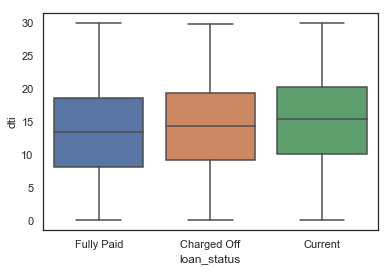

In [254]:
sns.boxplot(x="loan_status", y="dti", data=loan_df)
plt.show()

In [255]:
# Analysis
outlier_assessment(loan_df, 'dti')

,dti,pct_change
0.90,22.410,NaN
0.91,22.660,1.115573
0.92,22.950,1.279788
0.93,23.240,1.263617
0.94,23.560,1.376936
0.95,23.880,1.358234
0.96,24.210,1.381910
0.97,24.570,1.486989
0.98,24.900,1.343101
0.99,26.737,7.377510


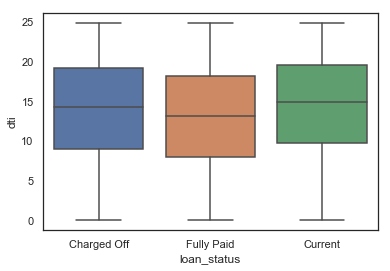

In [256]:
# Correction
# Since a huge jump noticed between 97 and 98th percentile, the values above 98th percentile were considered as outliers
loan_df = remove_outlier(loan_df, 'dti', .98)
sns.boxplot(x="loan_status", y="dti",data=loan_df)
plt.show()

3) <b>last_pymnt_amnt</b>: Last total payment amount received

In [257]:
# Analysis
outlier_assessment(loan_df, 'last_pymnt_amnt')

,last_pymnt_amnt,pct_change
0.90,8019.6900,NaN
0.91,8591.0774,7.124807
0.92,9207.8052,7.178701
0.93,9861.2788,7.096953
0.94,10682.5176,8.327914
0.95,11685.4030,9.388100
0.96,12907.1172,10.455045
0.97,14507.6988,12.400768
0.98,16614.4440,14.521567
0.99,20352.4960,22.498809


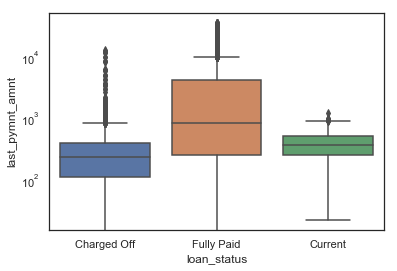

In [258]:
sns.boxplot(x="loan_status", y="last_pymnt_amnt", data=loan_df)
plt.yscale('log')
plt.show()

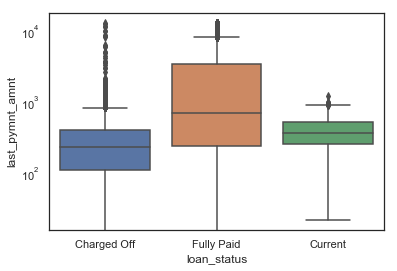

In [259]:
# Correction
loan_df = remove_outlier(loan_df, 'last_pymnt_amnt', .96)
sns.boxplot(x="loan_status", y="last_pymnt_amnt",data=loan_df)
plt.yscale('log')
plt.show()

4) <b>loan_amnt</b>: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

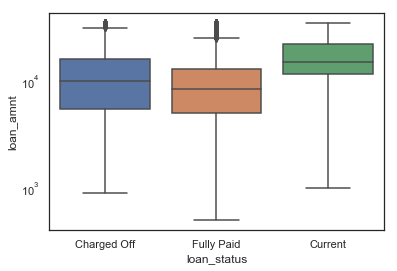

In [260]:
sns.boxplot(x="loan_status", y="loan_amnt", data=loan_df)
plt.yscale('log')
plt.show()

In [261]:
# Analysis
outlier_assessment(loan_df, 'loan_amnt')

,loan_amnt,pct_change
0.90,20000.00,NaN
0.91,20000.00,0.000000
0.92,20800.00,4.000000
0.93,22000.00,5.769231
0.94,24000.00,9.090909
0.95,24643.75,2.682292
0.96,25000.00,1.445600
0.97,25000.00,0.000000
0.98,28000.00,12.000000
0.99,33000.00,17.857143


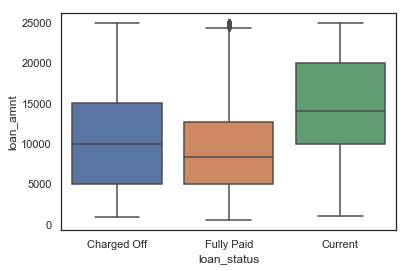

In [262]:
# Correction
# Since a huge jump noticed between 95 and 96th percentile, the values above 96th percentile were considered as outliers
loan_df = remove_outlier(loan_df, 'loan_amnt', .96)
sns.boxplot(x="loan_status", y="loan_amnt",data=loan_df)
plt.show()

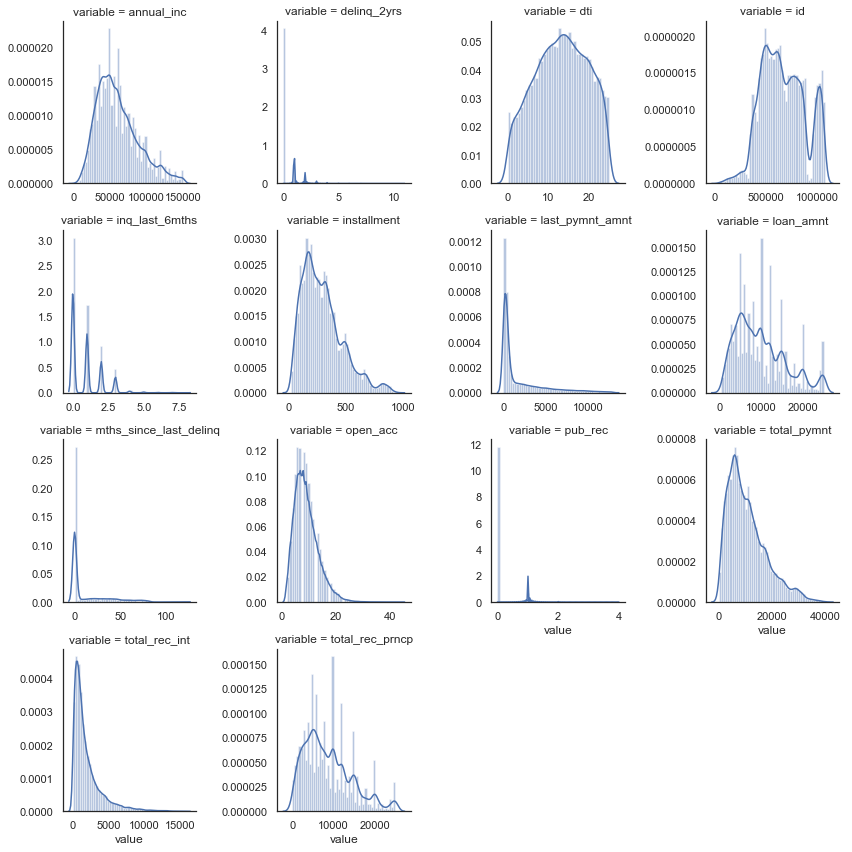

In [263]:
quantitative_features_distribution(loan_df, numeric_data)

### Standardising Text

#### Analysing Categorical Variables

In [264]:
display(categorical_data.columns)
display(categorical_data.describe())

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'revol_util', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,last_pymnt_d,last_credit_pull_d
count,39717,39717,39717,39717,37258,38642,39717,39717,39717,39717,39717,39706,39717,39717,39717,39667,39646,39715
unique,2,371,7,35,28820,11,5,3,55,3,14,19615,823,50,526,1089,101,106
top,36 months,10.99%,B,B3,US Army,10+ years,RENT,Not Verified,Dec-11,Fully Paid,debt_consolidation,Debt Consolidation,100xx,CA,Nov-98,0%,May-16,May-16
freq,29096,956,12020,2917,134,8879,18899,16921,2260,32950,18641,2184,597,7099,370,977,1256,10308


1) <b>emp_title</b>

In [265]:
# Analysis
variable_analysis(loan_df, 'emp_title', freq_count=True, filter_value = 20)

Describing column :
count       32931
unique      25936
top       US Army
freq          108
Name: emp_title, dtype: object

Unique column values :
['Ryder' nan 'AIR RESOURCES BOARD' ... 'FiSite Research'
 'Squarewave Solutions, Ltd.' 'Evergreen Center']

Frequency of values :
                                 id
emp_title                          
US Army                         108
Bank of America                 104
AT&T                             51
US Air Force                     49
IBM                              49
Wells Fargo                      48
UPS                              46
Kaiser Permanente                45
Walmart                          41
USAF                             41
State of California              41
United States Air Force          39
Self Employed                    38
US ARMY                          36
Target                           34
JPMorgan Chase                   34
USPS                             33
JP Morgan Chase                  33
Sel

In [266]:
# Correction
loan_df.loc[:,'emp_title'] = loan_df.loc[:,'emp_title'].str.upper().str.strip()

loan_df.loc[:,'emp_title'].replace(to_replace=['U.S.','UNITED STATES','JPMORGAN','SELF EMPLOYED','SELF-EMPLOYED'],\
                                   value=['US','US','JP MORGAN','SELF','SELF'], regex=True, inplace=True)
loan_df.loc[:,'emp_title'] = loan_df.loc[:,'emp_title'].str.replace('USPS', 'US POSTAL SERVICE', regex=False)
loan_df.loc[:,'emp_title'] = loan_df.loc[:,'emp_title'].str.replace('UNITED PARCEL SERVICE', 'US PARCEL SERVICE', 
                                                                    regex=False)
loan_df.loc[:,'emp_title'] = loan_df.loc[:,'emp_title'].str.replace('UPS', 'US PARCEL SERVICE', regex=False)
loan_df.loc[:,'emp_title'] = loan_df.loc[:,'emp_title'].str.replace('USAF', 'US AIR FORCE', regex=False)

variable_analysis(loan_df, 'emp_title', freq_count=True, filter_value = 20)

Describing column :
count       32931
unique      24505
top       US ARMY
freq          244
Name: emp_title, dtype: object

Unique column values :
['RYDER' nan 'AIR RESOURCES BOARD' ... 'FISITE RESEARCH'
 'SQUAREWAVE SOLUTIONS, LTD.' 'EVERGREEN CENTER']

Frequency of values :
                                  id
emp_title                           
US ARMY                          244
US AIR FORCE                     154
US POSTAL SERVICE                141
SELF                             141
BANK OF AMERICA                  130
US PARCEL SERVICE                 89
JP MORGAN CHASE                   80
WALMART                           77
AT&T                              72
US NAVY                           70
WELLS FARGO                       62
VERIZON WIRELESS                  56
KAISER PERMANENTE                 55
IBM                               51
STATE OF CALIFORNIA               47
HOME DEPOT                        46
WALGREENS                         43
TARGET              

2) <b>term</b>: The number of payments on the loan. Values are in months and can be either 36 or 60.

In [267]:
# Analysis
variable_analysis(loan_df, 'term')

Describing column :
count          35058
unique             2
top        36 months
freq           26847
Name: term, dtype: object

Unique column values :
[' 60 months' ' 36 months']


In [268]:
# Correction
loan_df['term'] = loan_df['term'].apply(lambda x: int(x[0:3].strip()))
loan_df.rename(columns={'term':'term_in_months'}, inplace=True)
loan_df['term_in_months'].describe()

count    35058.000000
mean        41.621085
std         10.164270
min         36.000000
25%         36.000000
50%         36.000000
75%         36.000000
max         60.000000
Name: term_in_months, dtype: float64

3) <b>int_rate</b>: Interest Rate on the loan

In [269]:
# Analysis
variable_analysis(loan_df, 'int_rate')

Describing column :
count      35058
unique       369
top       10.99%
freq         838
Name: int_rate, dtype: object

Unique column values :
['15.27%' '15.96%' '13.49%' '12.69%' '7.90%' '18.64%' '21.28%' '14.65%'
 '9.91%' '10.65%' '16.29%' '6.03%' '11.71%' '12.42%' '14.27%' '16.77%'
 '7.51%' '8.90%' '18.25%' '6.62%' '19.91%' '17.27%' '17.58%' '21.67%'
 '19.42%' '22.06%' '20.89%' '19.03%' '20.30%' '23.52%' '23.13%' '22.74%'
 '23.91%' '22.35%' '6.00%' '24.11%' '7.49%' '11.99%' '5.99%' '10.99%'
 '18.79%' '8.49%' '15.99%' '6.99%' '12.99%' '14.79%' '15.23%' '5.42%'
 '16.49%' '17.49%' '10.59%' '15.62%' '11.49%' '9.99%' '19.29%' '13.99%'
 '16.89%' '20.62%' '17.99%' '18.39%' '20.25%' '20.99%' '22.85%' '21.36%'
 '21.74%' '23.22%' '19.69%' '22.11%' '22.48%' '23.59%' '18.07%' '7.91%'
 '7.42%' '11.14%' '20.20%' '12.12%' '19.39%' '16.11%' '17.54%' '22.64%'
 '13.84%' '12.62%' '17.19%' '12.87%' '20.69%' '9.67%' '21.82%' '11.63%'
 '22.94%' '16.59%' '19.79%' '24.40%' '21.48%' '14.82%' '18.49%' '7.29%'

In [270]:
# Correction
standardise_percentage_column(loan_df, 'int_rate')

count    35058.000000
mean        11.771188
std          3.600660
min          5.400000
25%          8.900000
50%         11.700000
75%         14.200000
max         24.400000
Name: int_rate_in_pct, dtype: float64

4) <b>emp_length</b>: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [271]:
# Analysis
variable_analysis(loan_df, 'emp_length')

Describing column :
count         34074
unique           11
top       10+ years
freq           7321
Name: emp_length, dtype: object

Unique column values :
['< 1 year' '10+ years' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]


In [272]:
# Correction
loan_df.loc[pd.notnull(loan_df['emp_length']), 'emp_length'] = loan_df.loc[pd.notnull(loan_df['emp_length']),'emp_length']\
.str.replace('years', '', regex=False).str.replace('year', '', regex=False)\
.str.replace('+', '', regex=False).str.replace('<', '', regex=False).str.strip().astype(int)
loan_df.rename(columns={'emp_length':'emp_length_in_yrs'}, inplace=True)
loan_df['emp_length_in_yrs'].describe()


count     34074
unique       10
top          10
freq       7321
Name: emp_length_in_yrs, dtype: int64

5) <b>revol_util</b>: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [273]:
# Analysis
variable_analysis(loan_df, 'revol_util')

Describing column :
count     35009
unique     1081
top          0%
freq        871
Name: revol_util, dtype: object

Unique column values :
['9.40%' '98.50%' '21%' ... '49.63%' '0.04%' '7.28%']


In [274]:
# Correction
standardise_percentage_column(loan_df, 'revol_util')

count    33870.000000
mean        45.794818
std         29.387350
min          0.000000
25%         19.300000
50%         45.800000
75%         70.600000
max         99.900000
Name: revol_util_in_pct, dtype: float64

6) <b>title</b>: The loan title provided by the borrower									

In [275]:
# Analysis
variable_analysis(loan_df, 'title', freq_count = True, filter_value = 100)

Describing column :
count                  35047
unique                 17874
top       Debt Consolidation
freq                    1823
Name: title, dtype: object

Unique column values :
['bike' 'real estate business' 'personel' ... 'My Credit Card Loan'
 'Retiring credit card debt' 'MBA Loan Consolidation']

Frequency of values :
                             id
title                          
Debt Consolidation         1823
Debt Consolidation Loan    1376
Personal Loan               584
Consolidation               431
debt consolidation          429
Credit Card Consolidation   310
Debt consolidation          290
Home Improvement            286
Personal                    278
Credit Card Loan            273
Small Business Loan         252
personal loan               220
Consolidation Loan          208
personal                    203
Home Improvement Loan       194
Car Loan                    190
Loan                        187
Wedding Loan                187
Other Loan                 

In [276]:
# Correction
loan_df.loc[:,'title'] = loan_df.loc[:,'title'].str.upper()
loan_df.loc[:,'title'] = loan_df.loc[:,'title'].str.replace('MY','', regex=False)
loan_df.loc[:,'title'] = loan_df.loc[:,'title'].str.replace('LOAN','', regex=False)
loan_df.loc[:,'title'] = loan_df.loc[:,'title'].str.replace('CONSOLODATION','', regex=False)     
loan_df.loc[:,'title'] = loan_df.loc[:,'title'].str.replace('_',' ', regex=False)  
loan_df.loc[:,'title'] = loan_df.loc[:,'title'].str.strip()

loan_df.loc[:,'title'].replace(to_replace=['CREDIT CARDS',
                                           'CONSOLIDATE DEBT',
                                           'CREDIT CARD PAYOFF',\
                                           'CONSOLIDATE',\
                                          'PAY OFF CREDIT CARDS',\
                                           'DEBT',\
                                          'CREDIT CARD DEBT CONSOLIDATION',\
                                          'WEDDING EXPENSES',
                                          'CC PAYOFF',
                                          'CC CONSOLIDATION'],\
                                   value=['CREDIT CARD',\
                                          'DEBT CONSOLIDATION',\
                                          'CREDIT CARD PAYOFF',\
                                          'CONSOLIDATION',\
                                          'CREDIT CARD PAYOFF',\
                                          'DEBT CONSOLIDATION',\
                                         'CREDIT CARD CONSOLIDATION',
                                         'WEDDING',\
                                         'CREDIT CARD PAYOFF',\
                                         'CREDIT CARD CONSOLIDATION']\
                               , regex=False, inplace=True)
variable_analysis(loan_df, 'title', freq_count = True, filter_value = 100)

Describing column :
count                  35047
unique                 15161
top       DEBT CONSOLIDATION
freq                    4690
Name: title, dtype: object

Unique column values :
['BIKE' 'REAL ESTATE BUSINESS' 'PERSONEL' ... "P'S FAMILY CREDIT"
 'RETIRING CREDIT CARD DEBT' 'MBA  CONSOLIDATION']

Frequency of values :
                             id
title                          
DEBT CONSOLIDATION         4690
PERSONAL                   1458
CONSOLIDATION              1167
HOME IMPROVEMENT            705
CREDIT CARD                 637
CREDIT CARD CONSOLIDATION   626
WEDDING                     480
                            479
CREDIT CARD PAYOFF          371
SMALL BUSINESS              330
CAR                         322
OTHER                       241
MAJOR PURCHASE              231
CREDIT CARD REFINANCE       221
MEDICAL                     216
MOTORCYCLE                  171
MOVING                      159
FREEDOM                     153
VACATION                    151
B

**<font color=black> Consolidating unique values </font>**

In [277]:
loan_df.loc[:,'title'].replace(to_replace=['CONSOLIDATION',
                                           'CREDIT CARD CONSOLIDATION',
                                           'CREDIT CARD PAYOFF',\
                                           'CREDIT CARD REFINANCE',\
                                          'CREDIT CARD DEBT',\
                                           'DEBT FREE'],\
                                   value=['DEBT CONSOLIDATION',\
                                          'CREDIT CARD',\
                                          'CREDIT CARD',\
                                          'CREDIT CARD',\
                                          'CREDIT CARD',\
                                          'DEBT CONSOLIDATION']\
                               , regex=False, inplace=True)
variable_analysis(loan_df, 'title', freq_count = True, filter_value = 100)

Describing column :
count                  35047
unique                 15155
top       DEBT CONSOLIDATION
freq                    5949
Name: title, dtype: object

Unique column values :
['BIKE' 'REAL ESTATE BUSINESS' 'PERSONEL' ... "P'S FAMILY CREDIT"
 'RETIRING CREDIT CARD DEBT' 'MBA  CONSOLIDATION']

Frequency of values :
                      id
title                   
DEBT CONSOLIDATION  5949
CREDIT CARD         1939
PERSONAL            1458
HOME IMPROVEMENT     705
WEDDING              480
                     479
SMALL BUSINESS       330
CAR                  322
OTHER                241
MAJOR PURCHASE       231
MEDICAL              216
MOTORCYCLE           171
MOVING               159
FREEDOM              153
VACATION             151
BUSINESS             143
PAYOFF               116
AUTO                 102


### Fixed Invalid Values

#### Incorrect data types

1) <b>issue_d</b>: The month which the loan was funded

In [278]:
# Analysis
variable_analysis(loan_df, 'issue_d')

Describing column :
count      35058
unique        55
top       Dec-11
freq        1856
Name: issue_d, dtype: object

Unique column values :
['Dec-11' 'Nov-11' 'Oct-11' 'Sep-11' 'Aug-11' 'Jul-11' 'Jun-11' 'May-11'
 'Apr-11' 'Mar-11' 'Feb-11' 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10' 'Sep-10'
 'Aug-10' 'Jul-10' 'Jun-10' 'May-10' 'Apr-10' 'Mar-10' 'Feb-10' 'Jan-10'
 'Dec-09' 'Nov-09' 'Oct-09' 'Sep-09' 'Aug-09' 'Jul-09' 'Jun-09' 'May-09'
 'Apr-09' 'Mar-09' 'Feb-09' 'Jan-09' 'Dec-08' 'Nov-08' 'Oct-08' 'Sep-08'
 'Aug-08' 'Jul-08' 'Jun-08' 'May-08' 'Apr-08' 'Mar-08' 'Feb-08' 'Jan-08'
 'Dec-07' 'Nov-07' 'Oct-07' 'Sep-07' 'Aug-07' 'Jul-07' 'Jun-07']


In [279]:
# Correction
standardise_date_column(loan_df, 'issue_d')

count                   35058
unique                     55
top       2011-12-01 00:00:00
freq                     1856
first     2007-06-01 00:00:00
last      2011-12-01 00:00:00
Name: issue_d, dtype: object

2) <b>earliest_cr_line</b>: The month the borrower's earliest reported credit line was opened

In [280]:
# Analysis
variable_analysis(loan_df, 'earliest_cr_line')

Describing column :
count      35058
unique       519
top       Oct-99
freq         333
Name: earliest_cr_line, dtype: object

Unique column values :
['Apr-99' 'Nov-01' 'Feb-96' 'Jan-96' 'Nov-04' 'Jul-05' 'Jan-07' 'Apr-04'
 'Sep-04' 'Jan-98' 'Oct-89' 'Jul-03' 'May-91' 'Sep-07' 'Oct-98' 'Aug-93'
 'Oct-03' 'Jan-01' 'Feb-83' 'Jul-85' 'Apr-03' 'Jun-01' 'Aug-84' 'Nov-06'
 'Dec-87' 'Feb-97' 'Apr-05' 'Oct-07' 'Dec-00' 'Apr-07' 'Dec-01' 'Jan-03'
 'Mar-94' 'Sep-98' 'Jun-04' 'Nov-95' 'Jul-99' 'Jun-95' 'Sep-92' 'Jan-02'
 'Apr-92' 'Oct-06' 'May-00' 'Dec-98' 'Dec-04' 'Oct-00' 'May-02' 'May-06'
 'Jul-06' 'May-97' 'Oct-05' 'Apr-95' 'Jan-00' 'Apr-00' 'Dec-94' 'Sep-05'
 'Dec-84' 'Dec-99' 'Nov-03' 'Jun-89' 'Oct-96' 'Oct-02' 'May-03' 'Jun-02'
 'Jun-07' 'Dec-96' 'Feb-84' 'Sep-02' 'Jan-86' 'May-98' 'Jan-97' 'Jun-05'
 'Feb-90' 'Feb-02' 'Mar-04' 'Jul-95' 'Aug-94' 'Jun-92' 'Mar-97' 'Apr-06'
 'Apr-90' 'Aug-99' 'Sep-00' 'Feb-01' 'Oct-04' 'Aug-04' 'Feb-05' 'Nov-05'
 'Nov-00' 'May-07' 'Jun-00' 'Aug-06' 'Dec-02' '

In [281]:
# Correction
standardise_date_column(loan_df, 'earliest_cr_line')

count                   35058
unique                    519
top       1999-10-01 00:00:00
freq                      333
first     1969-02-01 00:00:00
last      2068-12-01 00:00:00
Name: earliest_cr_line, dtype: object

3) <b>last_pymnt_d</b>: Last month payment was received

In [282]:
# Analysis
variable_analysis(loan_df, 'last_pymnt_d')

Describing column :
count      34989
unique       101
top       May-16
freq         972
Name: last_pymnt_d, dtype: object

Unique column values :
['Apr-13' 'Jun-14' 'Jan-15' 'May-16' 'Apr-12' 'Nov-12' 'Jun-13' 'Sep-13'
 'Jul-12' 'Oct-13' 'May-13' 'Feb-15' 'Oct-12' nan 'Dec-12' 'Dec-14'
 'Nov-13' 'Jan-14' 'Apr-14' 'Aug-14' 'Oct-14' 'Aug-12' 'Jul-14' 'Jul-13'
 'Jan-16' 'Feb-16' 'Apr-15' 'Feb-14' 'Sep-14' 'Sep-12' 'Jun-12' 'Feb-13'
 'Mar-13' 'May-14' 'Mar-15' 'Jan-13' 'Dec-13' 'Feb-12' 'Mar-14' 'Sep-15'
 'Nov-15' 'Mar-16' 'Aug-13' 'Nov-14' 'Mar-12' 'Oct-15' 'May-12' 'Aug-15'
 'Apr-16' 'Dec-15' 'Jan-12' 'Jun-15' 'May-15' 'Jul-15' 'Dec-11' 'Nov-11'
 'Oct-11' 'Sep-11' 'Aug-11' 'Jul-11' 'Jun-11' 'May-11' 'Apr-11' 'Mar-11'
 'Feb-11' 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10' 'Sep-10' 'Aug-10' 'Jul-10'
 'Jun-10' 'May-10' 'Apr-10' 'Mar-10' 'Feb-10' 'Jan-10' 'Dec-09' 'Nov-09'
 'Oct-09' 'Sep-09' 'Aug-09' 'Jul-09' 'Jun-09' 'May-09' 'Apr-09' 'Mar-09'
 'Feb-09' 'Jan-09' 'Dec-08' 'Oct-08' 'Aug-08' 'Jul-08' '

In [283]:
# Correction
standardise_date_column(loan_df, 'last_pymnt_d')

count                   34989
unique                    101
top       2016-05-01 00:00:00
freq                      972
first     2008-01-01 00:00:00
last      2016-05-01 00:00:00
Name: last_pymnt_d, dtype: object

4) <b>last_credit_pull_d</b>: The most recent month LC pulled credit for this loan

In [284]:
# Analysis
variable_analysis(loan_df, 'last_credit_pull_d')

Describing column :
count      35056
unique       105
top       May-16
freq        8977
Name: last_credit_pull_d, dtype: object

Unique column values :
['Sep-13' 'May-16' 'Apr-16' 'Jan-16' 'Dec-14' 'Aug-12' 'Mar-13' 'Dec-15'
 'Aug-13' 'Nov-12' 'Mar-14' 'Apr-15' 'May-14' 'Jul-15' 'Feb-16' 'May-13'
 'Jan-15' 'Jun-12' 'Mar-15' 'Dec-12' 'Mar-16' 'Sep-14' 'Jun-15' 'Oct-13'
 'Apr-14' 'Oct-14' 'Feb-13' 'Nov-15' 'Jul-14' 'Sep-15' 'Oct-12' 'Nov-13'
 'Nov-14' 'Feb-12' 'Oct-15' 'Aug-15' 'Jun-14' 'Aug-14' 'Dec-13' 'May-12'
 'Jul-12' 'Jan-14' 'Jun-13' 'Feb-14' 'Jul-13' 'Sep-12' 'Apr-13' 'May-15'
 'Feb-15' 'Jan-12' 'Mar-12' 'Apr-12' 'Dec-11' 'Oct-11' 'Nov-11' 'Sep-11'
 'Jan-13' 'Aug-11' 'Jul-11' 'Jun-11' 'May-11' 'Mar-11' 'Apr-11' 'Feb-11'
 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10' nan 'Sep-10' 'Aug-10' 'Jul-10'
 'Jun-10' 'May-10' 'Apr-10' 'Feb-10' 'Mar-10' 'Jan-10' 'Dec-09' 'Nov-09'
 'Oct-09' 'Sep-09' 'Jul-09' 'Aug-09' 'Jun-09' 'May-09' 'Apr-09' 'Feb-09'
 'Mar-09' 'Dec-08' 'Jan-09' 'Jun-08' 'Sep-08' 'May

In [285]:
# Correction
standardise_date_column(loan_df, 'last_credit_pull_d')

count                   35056
unique                    105
top       2016-05-01 00:00:00
freq                     8977
first     2007-06-01 00:00:00
last      2016-05-01 00:00:00
Name: last_credit_pull_d, dtype: object

### Analysing remaining columns

##### Revaluating Numeric and Quantative variables available in data-set

In [286]:
variable_data_analysis = variable_type_analysis(loan_df)
numeric_data = variable_data_analysis[0]
categorical_data = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 17 , 15


#### Categorical variables

1) <b>loan_status</b>: Current status of the loan

In [287]:
# Analysis
variable_analysis(loan_df, 'loan_status')

Describing column :
count          35058
unique             3
top       Fully Paid
freq           29088
Name: loan_status, dtype: object

Unique column values :
['Charged Off' 'Fully Paid' 'Current']


<b>loan_status</b> does not seem to require any cleaning

2) <b>purpose</b>: A category provided by the borrower for the loan request. 

In [288]:
# Analysis
variable_analysis(loan_df, 'purpose', freq_count = True)

Describing column :
count                  35058
unique                    14
top       debt_consolidation
freq                   16195
Name: purpose, dtype: object

Unique column values :
['car' 'small_business' 'other' 'wedding' 'debt_consolidation'
 'credit_card' 'home_improvement' 'major_purchase' 'medical' 'moving'
 'vacation' 'house' 'renewable_energy' 'educational']

Frequency of values :
                       id
purpose                  
debt_consolidation  16195
credit_card          4555
other                3708
home_improvement     2468
major_purchase       2009
small_business       1520
car                  1467
wedding               877
medical               633
moving                548
vacation              365
house                 313
educational           310
renewable_energy       90


<b>purpose</b> does not seem to require any cleaning

3) <b>addr_state</b>: The state provided by the borrower in the loan application

In [289]:
# Analysis
variable_analysis(loan_df, 'addr_state')

Describing column :
count     35058
unique       50
top          CA
freq       6303
Name: addr_state, dtype: object

Unique column values :
['GA' 'IL' 'CA' 'OR' 'AZ' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA'
 'MN' 'KY' 'OH' 'SC' 'NJ' 'RI' 'LA' 'MA' 'WA' 'AL' 'CO' 'KS' 'NV' 'AK'
 'MD' 'WV' 'VT' 'MI' 'DC' 'WI' 'SD' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK'
 'DE' 'MS' 'IA' 'TN' 'NE' 'ID' 'IN' 'ME']


<b>addr_state</b> does not seem to require any cleaning

4) <b>verification_status</b>: Indicates if income was verified by LC, not verified, or if the income source was verified

In [290]:
# Analysis
variable_analysis(loan_df, 'verification_status')

Describing column :
count            35058
unique               3
top       Not Verified
freq             16200
Name: verification_status, dtype: object

Unique column values :
['Source Verified' 'Not Verified' 'Verified']


<b>verification_status</b> does not seem to require any cleaning

5) <b>home_ownership</b>: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.<br>

In [291]:
# Analysis
variable_analysis(loan_df, 'home_ownership')

Describing column :
count     35058
unique        5
top        RENT
freq      17488
Name: home_ownership, dtype: object

Unique column values :
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']


<b>home_ownership</b> does not seem to require any cleaning

6) <b>grade</b>: LC assigned loan grade <br>

In [292]:
# Analysis
variable_analysis(loan_df, 'grade')

Describing column :
count     35058
unique        7
top           B
freq      10709
Name: grade, dtype: object

Unique column values :
['C' 'B' 'A' 'E' 'F' 'D' 'G']


<b>grade</b> does not seem to require any cleaning

7) <b>sub_grade</b>: LC assigned loan subgrade

In [293]:
# Analysis
variable_analysis(loan_df, 'sub_grade')

Describing column :
count     35058
unique       35
top          A4
freq       2602
Name: sub_grade, dtype: object

Unique column values :
['C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'B2' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E2'
 'E5' 'G3' 'G2' 'G1' 'G4' 'F5' 'G5']


<b>sub_grade</b> does not seem to require any cleaning

#### Quantitative variables

1) <b>delinq_2yrs</b>: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [294]:
# Analysis
variable_analysis(loan_df, 'delinq_2yrs', freq_count = True)

Describing column :
count    35058.000000
mean         0.148611
std          0.498500
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64

Unique column values :
[ 0  2  3  1  4  6  5  8  7  9 11]

Frequency of values :
                id
delinq_2yrs       
0            31212
1             2950
2              597
3              202
4               59
5               20
6               10
7                4
8                2
9                1
11               1


<b>delinq_2yrs</b> does not seem to require any cleaning

2) <b>inq_last_6mths</b>: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

In [295]:
# Analysis
variable_analysis(loan_df, 'inq_last_6mths', freq_count = True)

Describing column :
count    35058.000000
mean         0.861487
std          1.059264
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64

Unique column values :
[5 2 1 0 3 4 6 7 8]

Frequency of values :
                   id
inq_last_6mths       
0               17095
1                9690
2                5126
3                2674
4                 269
5                 115
6                  47
7                  31
8                  11


<b>inq_last_6mths</b> does not seem to require any cleaning

3) <b>pub_rec</b>: Number of derogatory public records

In [296]:
# Analysis
variable_analysis(loan_df, 'pub_rec', freq_count = True)

Describing column :
count    35058.000000
mean         0.058617
std          0.244198
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64

Unique column values :
[0 1 2 3 4]

Frequency of values :
            id
pub_rec       
0        33069
1         1933
2           48
3            6
4            2


#### Creating two separate data-set for comparison  - Charged Off , Fully Paid


In [297]:
loan_df.columns

Index(['id', 'loan_amnt', 'term_in_months', 'int_rate_in_pct', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length_in_yrs',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util_in_pct',
       'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_d',
       'last_pymnt_amnt', 'last_credit_pull_d'],
      dtype='object')

In [298]:
loan_charged_off_df = loan_df.loc[loan_df['loan_status'] == 'Charged Off'].copy()
loan_not_charged_off_df = loan_df.loc[loan_df['loan_status'] == 'Fully Paid'].copy()
print('Total loans row : {0}'.format(len(loan_df.index)))
print('Total charged-off loans row: {0}'.format(len(loan_charged_off_df.index)))
print('Total non charged-off loans row: {0}'.format(len(loan_not_charged_off_df.index)))

Total loans row : 35058
Total charged-off loans row: 5096
Total non charged-off loans row: 29088


##### Evaluating Numeric and Quantative variables available in data-set - Charged Off vs Fully Paid

In [299]:
variable_data_analysis = variable_type_analysis(loan_charged_off_df)
numeric_data = variable_data_analysis[0]
categorical_data = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 17 , 15


In [300]:
variable_data_analysis = variable_type_analysis(loan_not_charged_off_df)
numeric_data_paid = variable_data_analysis[0]
categorical_data_paid = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 17 , 15


## Univariate Analysis

### Quantitative Variables

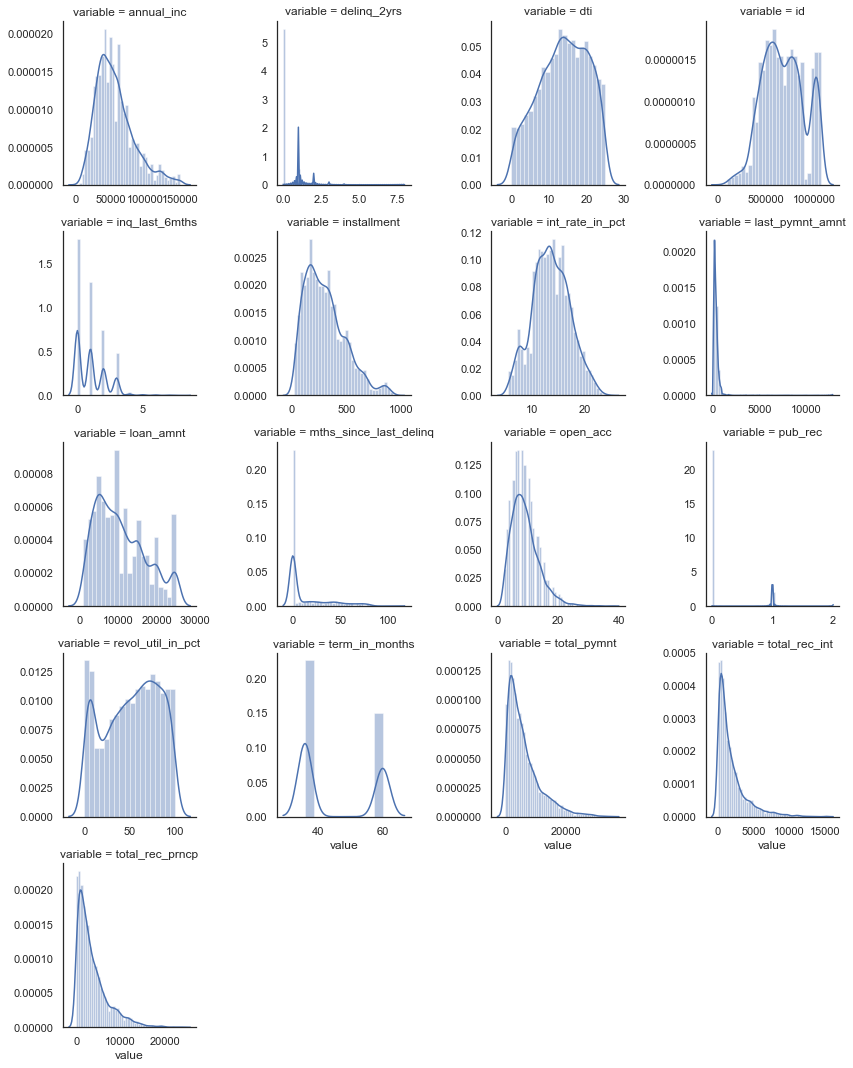

In [301]:
quantitative_features_distribution(loan_charged_off_df, numeric_data)

In [302]:
display(numeric_data.describe())

numeric_data = remove_columns_from_dataframe(numeric_data,['id', 'delinq_2yrs', 'inq_last_6mths',
                                                          'mths_since_last_delinq', 
                                                          'pub_rec',
                                                          'term_in_months'])

display(numeric_data.describe())

,id,loan_amnt,term_in_months,int_rate_in_pct,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util_in_pct,total_pymnt,total_rec_prncp,total_rec_int,last_pymnt_amnt
count,5.096000e+03,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,4921.000000,5096.000000,5096.000000,5096.000000,5096.000000
mean,6.864706e+05,10755.715267,45.546311,13.577002,304.478446,55738.480443,13.814851,0.170722,1.052786,14.050039,9.022370,0.088697,52.185470,6084.532947,3630.278342,1873.615693,298.581166
std,2.161078e+05,6528.795700,11.747616,3.539164,183.458200,27109.256165,6.435753,0.537042,1.145097,22.586544,4.496197,0.291155,29.462039,5494.305135,3446.062180,2015.925393,477.234991
min,6.141900e+04,900.000000,36.000000,5.400000,22.790000,4080.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,5.220265e+05,5000.000000,36.000000,11.100000,163.670000,36000.000000,9.007500,0.000000,0.000000,0.000000,6.000000,0.000000,28.400000,2072.170000,1141.697500,523.535000,109.570000
50%,6.688200e+05,10000.000000,36.000000,13.400000,274.485000,50000.780000,14.145000,0.000000,1.000000,0.000000,8.000000,0.000000,55.200000,4493.665000,2555.355000,1176.040000,223.645000
75%,8.421795e+05,15000.000000,60.000000,16.000000,407.117500,70000.000000,19.150000,0.000000,2.000000,24.000000,11.000000,0.000000,77.400000,8334.362500,5006.310000,2480.327500,379.962500
max,1.077430e+06,25000.000000,60.000000,24.400000,931.090000,150000.000000,24.900000,8.000000,8.000000,107.000000,38.000000,2.000000,99.900000,34765.350000,24057.130000,15246.660000,12818.380000


,loan_amnt,int_rate_in_pct,installment,annual_inc,dti,open_acc,revol_util_in_pct,total_pymnt,total_rec_prncp,total_rec_int,last_pymnt_amnt
count,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000,4921.000000,5096.000000,5096.000000,5096.000000,5096.000000
mean,10755.715267,13.577002,304.478446,55738.480443,13.814851,9.022370,52.185470,6084.532947,3630.278342,1873.615693,298.581166
std,6528.795700,3.539164,183.458200,27109.256165,6.435753,4.496197,29.462039,5494.305135,3446.062180,2015.925393,477.234991
min,900.000000,5.400000,22.790000,4080.000000,0.000000,2.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,5000.000000,11.100000,163.670000,36000.000000,9.007500,6.000000,28.400000,2072.170000,1141.697500,523.535000,109.570000
50%,10000.000000,13.400000,274.485000,50000.780000,14.145000,8.000000,55.200000,4493.665000,2555.355000,1176.040000,223.645000
75%,15000.000000,16.000000,407.117500,70000.000000,19.150000,11.000000,77.400000,8334.362500,5006.310000,2480.327500,379.962500
max,25000.000000,24.400000,931.090000,150000.000000,24.900000,38.000000,99.900000,34765.350000,24057.130000,15246.660000,12818.380000


#### Corelation Matrix of Loan Amount - Charged-Off vs Fully-Paid

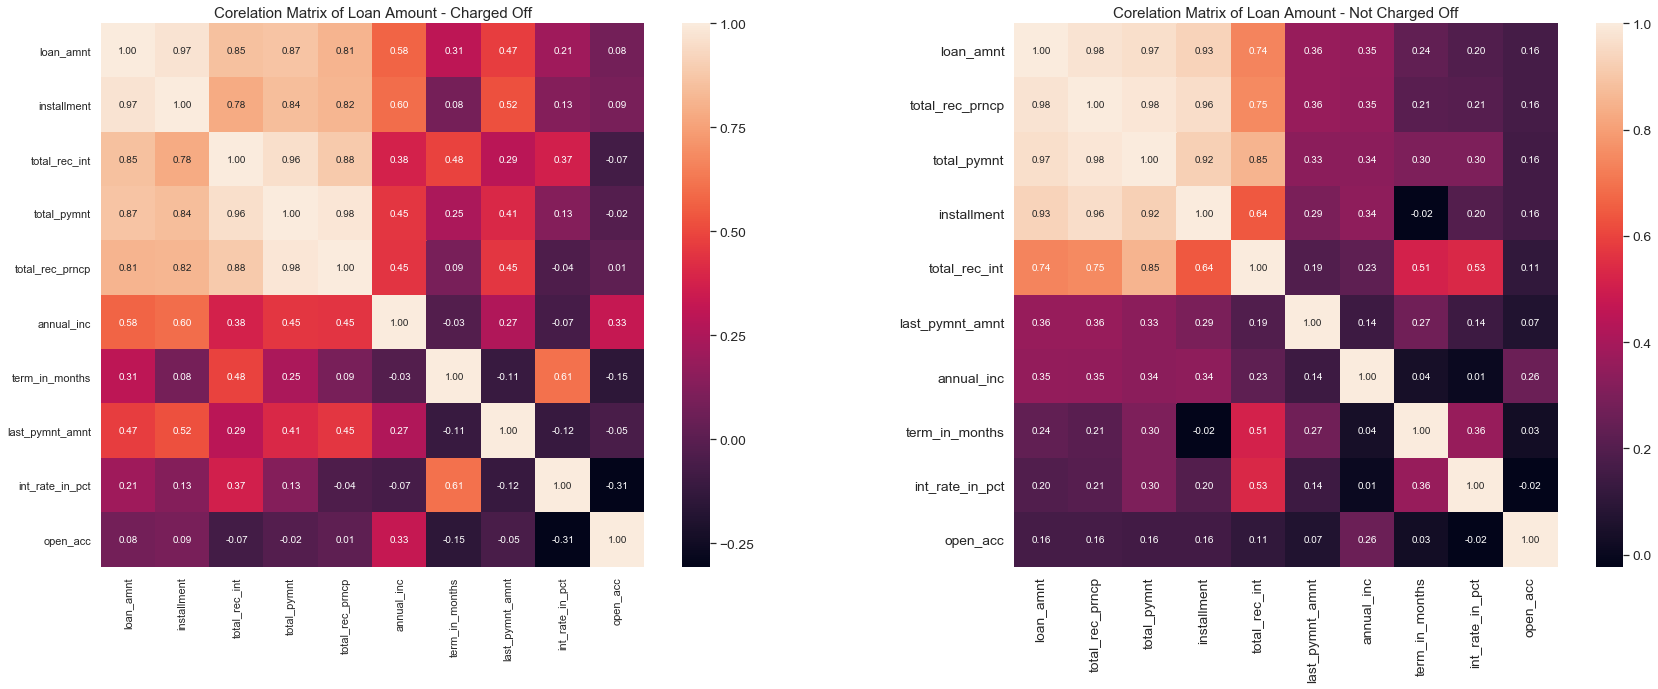

In [303]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
loan_charged_off_corr = loan_charged_off_df.corr()
k = 10  #number of variables for heatmap
cols = loan_charged_off_corr.nlargest(k, 'loan_amnt')['loan_amnt'].index
cm = np.corrcoef(loan_charged_off_corr[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.title('Corelation Matrix of Loan Amount - Charged Off')

plt.subplot(1,2,2)
loan_not_charged_off_corr = loan_not_charged_off_df.corr()
k = 10  #number of variables for heatmap
cols = loan_not_charged_off_corr.nlargest(k, 'loan_amnt')['loan_amnt'].index
cm = np.corrcoef(loan_not_charged_off_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.title('Corelation Matrix of Loan Amount - Not Charged Off')
plt.show()

#### 1) loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

The min loan_amnt is 900 and the max loan_amnt is 25,000
The mean loan_amnt is 10,756, while median is 10,000


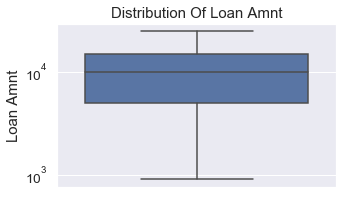

In [304]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'loan_amnt', hist = False, yscale = 'log', 
                                              xsize = 5, ysize = 3)

#### 2) int_rate_in_pct : Interest Rate on the loan

The min int_rate_in_pct is 5 and the max int_rate_in_pct is 24
The mean int_rate_in_pct is 14, while median is 13


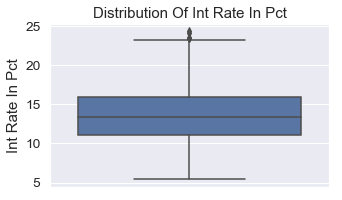

In [305]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'int_rate_in_pct', hist = False, 
                                              xsize = 5, ysize = 3)

#### 3) annual_inc : The self-reported annual income provided by the borrower during registration.

The min annual_inc is 4,080 and the max annual_inc is 150,000
The mean annual_inc is 55,738, while median is 50,001


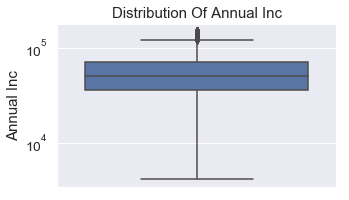

In [306]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'annual_inc', hist = False, yscale = 'log', 
                                              xsize = 5, ysize = 3)

#### 4) dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

The min dti is 0 and the max dti is 25
The mean dti is 14, while median is 14


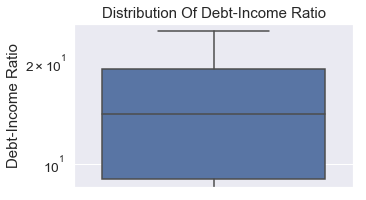

In [307]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'dti', hist = False, yscale = 'log', 
                                              xsize = 5, ysize = 3, ylabel='Debt-Income Ratio')

#### 5) open_acc : The number of open credit lines in the borrower's credit file.

The min open_acc is 2 and the max open_acc is 38
The mean open_acc is 9, while median is 8


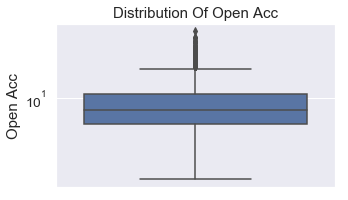

In [308]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'open_acc', hist = False, yscale = 'log', 
                                              xsize = 5, ysize = 3)

#### 6) revol_util_in_pct : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

The min revol_util_in_pct is 0 and the max revol_util_in_pct is 100
The mean revol_util_in_pct is 52, while median is 55


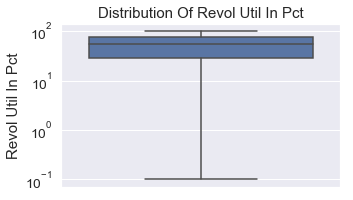

In [309]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'revol_util_in_pct', hist = False, yscale = 'log', 
                                              xsize = 5, ysize = 3)

#### 7) last_pymnt_amnt : Last total payment amount received

The min last_pymnt_amnt is 0 and the max last_pymnt_amnt is 12,818
The mean last_pymnt_amnt is 299, while median is 224


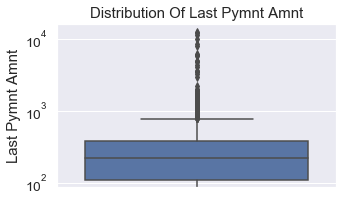

In [310]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'last_pymnt_amnt', hist = False, yscale = 'log', 
                                              xsize = 5, ysize = 3)

#### 8) mths_since_last_delinq : The number of months since the borrower's last delinquency.

The min mths_since_last_delinq is 0 and the max mths_since_last_delinq is 107
The mean mths_since_last_delinq is 14, while median is 0


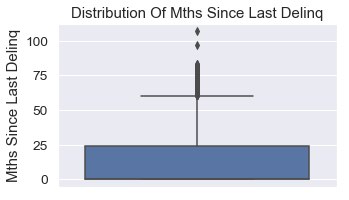

In [311]:
univariate_analysis_for_quantitative_variable(loan_charged_off_df, 'mths_since_last_delinq', hist = False, 
                                              xsize = 5, ysize = 3)

#### Quantitative variables of interest - 
> 1) annual_inc<br>
2) dti<br>
3) int_rate_in_pct
4) loan_amnt<br>
2) revol_util_in_pct<br>


### Categorical Variables

In [312]:
display(categorical_data.describe())

# Quantitative variables having discrete values that can be considered as categorical type :
# 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies','term_in_months'

,grade,sub_grade,emp_title,emp_length_in_yrs,home_ownership,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,earliest_cr_line,last_pymnt_d,last_credit_pull_d
count,5096,5096,4663,4885.0,5096,5096,5096,5096,5096,5094,5096,5096,5096,5027,5095
unique,7,35,4073,10.0,4,3,53,1,14,2517,652,47,415,97,83
top,B,B5,US ARMY,10.0,RENT,Not Verified,2011-12-01 00:00:00,Charged Off,debt_consolidation,DEBT CONSOLIDATION,945xx,CA,2000-04-01 00:00:00,2012-10-01 00:00:00,2016-05-01 00:00:00
freq,1318,333,40,1139.0,2659,2082,360,5096,2470,956,72,1018,54,155,1791
first,NaN,NaN,NaN,NaN,NaN,NaN,2007-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1969-06-01 00:00:00,2008-03-01 00:00:00,2009-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,2068-08-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00


#### 1) grade : LC assigned loan grade

For Grade value - B has max count value of 1,318
For Grade value - G has min count value of 80


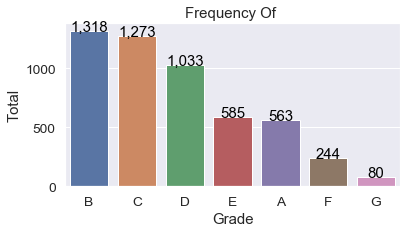

In [313]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'grade')

#### 2) sub_grade : LC assigned loan subgrade

For Sub Grade value - B5 has max count value of 333
For Sub Grade value - G4 has min count value of 9


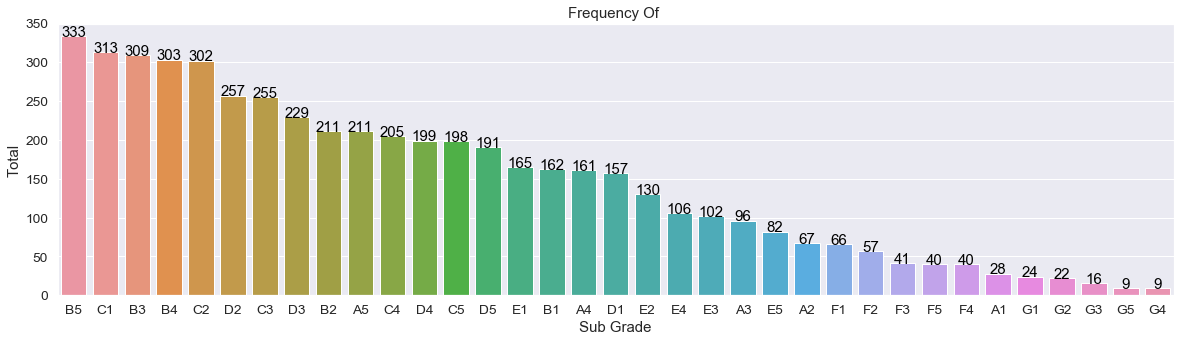

In [314]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'sub_grade', xsize=20, ysize=5)

#### 3) emp_title : The job title supplied by the Borrower when applying for the loan.*

For Emp Title value - US ARMY has max count value of 40
For Emp Title value - (SELF) CASTLEFORTE GROUP has min count value of 1


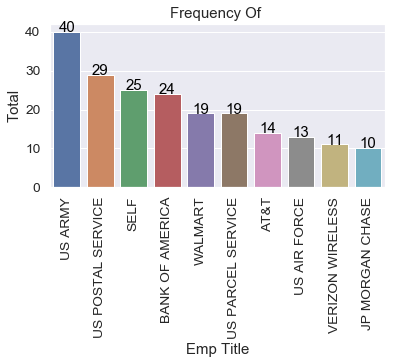

In [315]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'emp_title', top = 10, rotate_lbl_degree = 90)

#### 4) emp_length_in_yrs : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

For Emp Length In Yrs value - 10 has max count value of 1,139
For Emp Length In Yrs value - 9 has min count value of 141


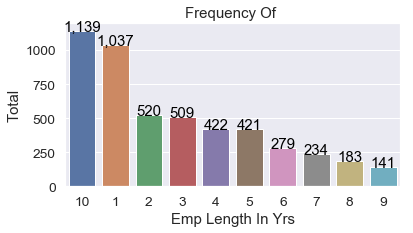

In [316]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'emp_length_in_yrs')

#### 5) home_ownership : The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

For Home Ownership value - RENT has max count value of 2,659
For Home Ownership value - OTHER has min count value of 17


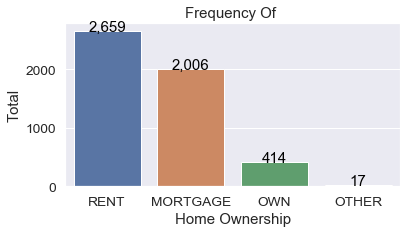

In [317]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'home_ownership')

#### 6) issue_d : The month which the loan was funded

For Issue D value - 2011-12-01 00:00:00 has max count value of 360
For Issue D value - 2007-09-01 00:00:00 has min count value of 3


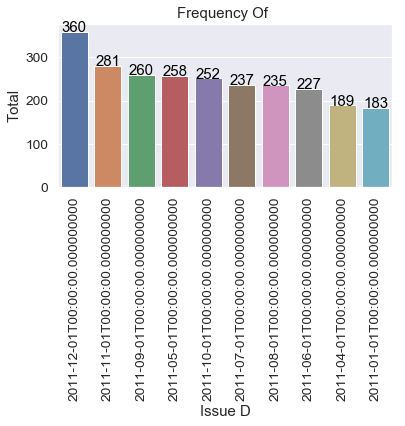

In [318]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'issue_d', top = 10, rotate_lbl_degree = 90)

#### 7) purpose : A category provided by the borrower for the loan request. 

For Purpose value - debt_consolidation has max count value of 2,470
For Purpose value - renewable_energy has min count value of 17


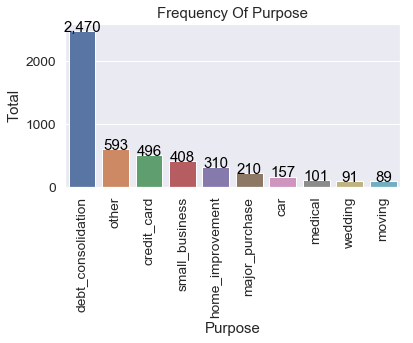

In [319]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'purpose', 'Purpose', top = 10, rotate_lbl_degree = 90)

#### 8) title : The loan title provided by the borrower

For Title value - DEBT CONSOLIDATION has max count value of 956
For Title value - #1 has min count value of 1


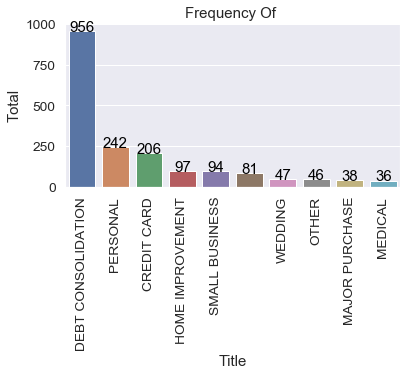

In [320]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'title', top = 10 , rotate_lbl_degree=90)

#### 9) zip_code : The first 3 numbers of the zip code provided by the borrower in the loan application.

For Zip Code value - 945xx has max count value of 72
For Zip Code value - 011xx has min count value of 1


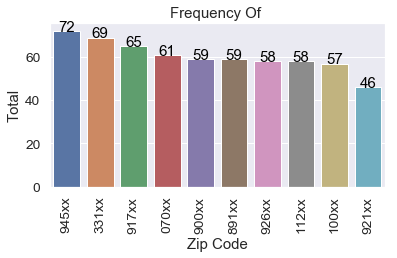

In [321]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'zip_code', top = 10 , rotate_lbl_degree=90)

#### 10) addr_state : The state provided by the borrower in the loan application

For Addr State value - CA has max count value of 1,018
For Addr State value - ID has min count value of 1


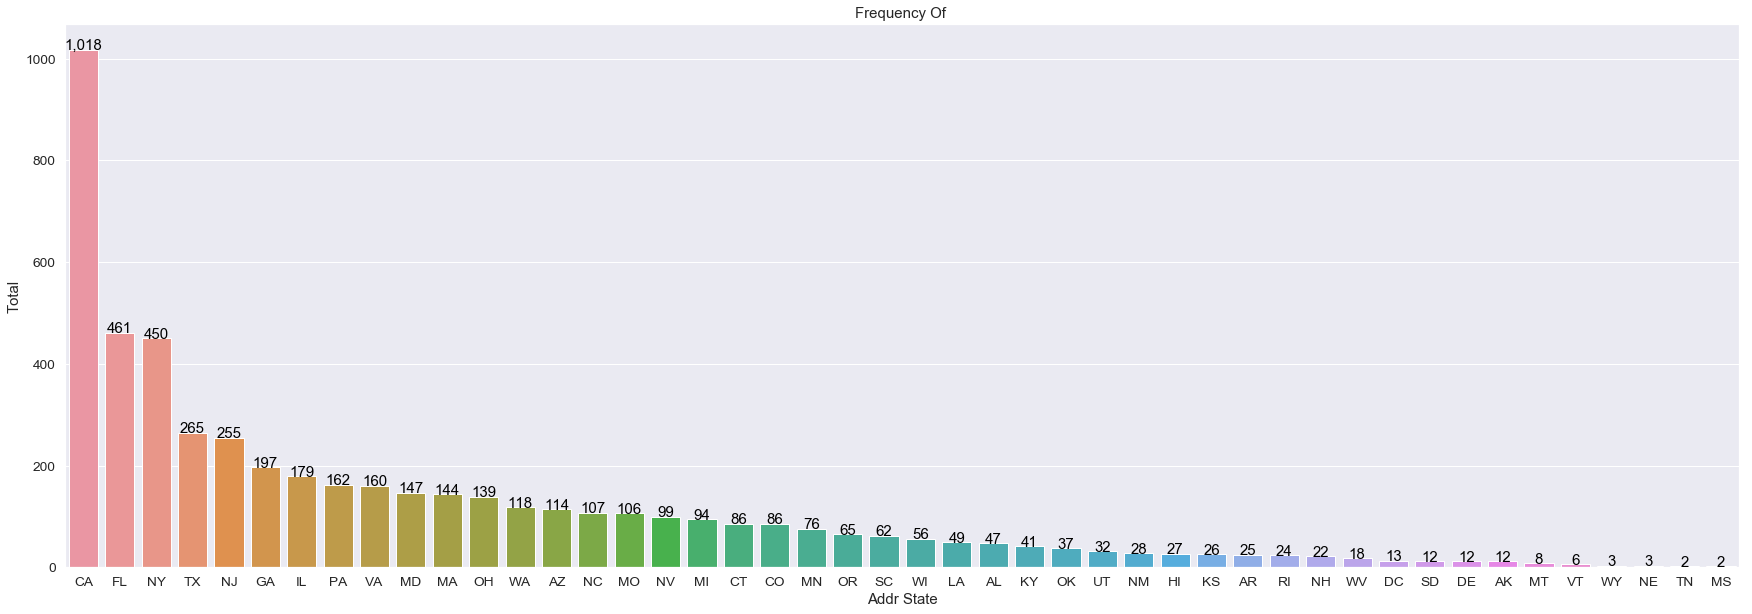

In [322]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'addr_state', filter_value = 1, xsize = 30, ysize=10)

#### 11) earliest_cr_line : Current status of the loan

For Earliest Cr Line value - 2000-04-01 00:00:00 has max count value of 54
For Earliest Cr Line value - 1969-06-01 00:00:00 has min count value of 1


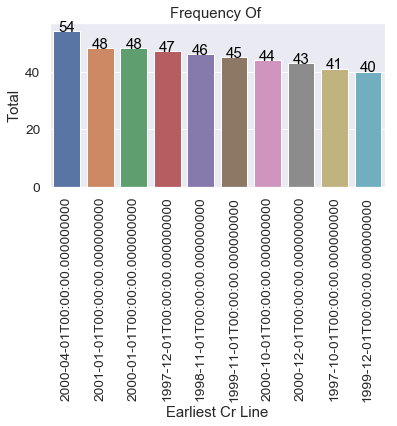

In [323]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'earliest_cr_line', top = 10, rotate_lbl_degree = 90)

#### 12) last_pymnt_d : Last month payment was received

For Last Pymnt D value - 2012-10-01 00:00:00 has max count value of 155
For Last Pymnt D value - 2008-03-01 00:00:00 has min count value of 1


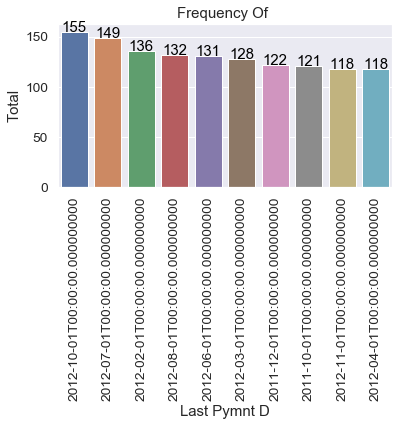

In [324]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'last_pymnt_d', top = 10, rotate_lbl_degree = 90)

#### 13) delinq_2yrs : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

For Delinq 2Yrs value - 0 has max count value of 4,469
For Delinq 2Yrs value - 6 has min count value of 1


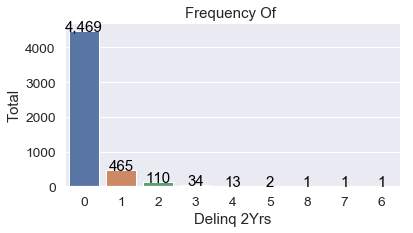

In [325]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'delinq_2yrs')

#### 14) inq_last_6mths : The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

For Inq Last 6Mths value - 0 has max count value of 2,074
For Inq Last 6Mths value - 8 has min count value of 2


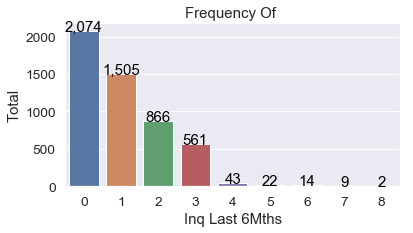

In [326]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'inq_last_6mths')

#### 15) pub_rec : Number of derogatory public records

For Pub Rec value - 0 has max count value of 4,654
For Pub Rec value - 2 has min count value of 10


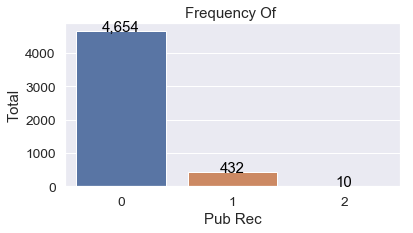

In [327]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'pub_rec')

#### 16) term_in_months : The number of payments on the loan. Values are in months and can be either 36 or 60.

For Term In Months value - 36 has max count value of 3,069
For Term In Months value - 60 has min count value of 2,027


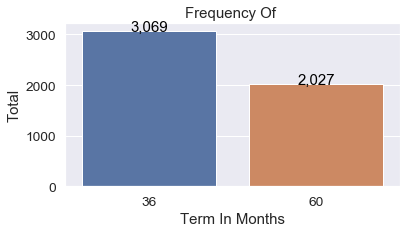

In [328]:
univariate_analysis_for_categorical_variable(loan_charged_off_df, 'term_in_months')

#### Checking relation between addr_state and zip_code

For Emp Title value - CA has max count value of 1,018
For Emp Title value - ID has min count value of 1


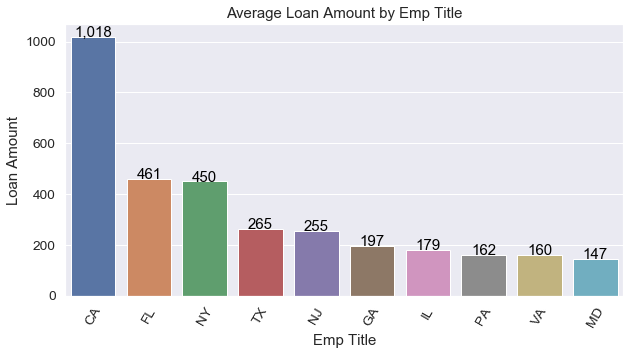

In [329]:
segmented_univariate_analysis(loan_charged_off_df, 'addr_state', 'zip_code', 'Emp Title', 'Loan Amount',
                              'Average Loan Amount by Emp Title', estimator='count', top = 10, rotate_lbl_degree = 60,
                              subplot = False)

#### Categorical Variable of interest - 
> a) emp_title<br>
b) emp_length_in_yrs<br>
c) title<br>
d) zip_code<br>
e) addr_state<br>
f) inq_last_6mths<br>
g) pub_rec<br>
h) delinq_2yrs<br>
i) term_in_months<br>
j) home_ownership<br>
k) purpose


## Segment Univariate

### 1) annual_inc

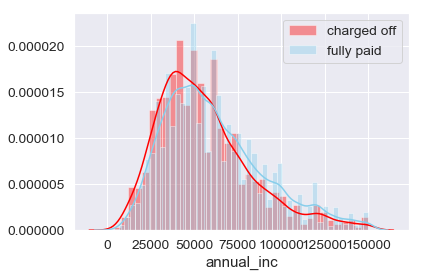

In [330]:
sns.distplot( numeric_data['annual_inc'] , color="red", label="charged off")
sns.distplot( numeric_data_paid['annual_inc'] , color="skyblue", label="fully paid")
plt.legend()
plt.show()

**Inference: Comparing the distribution between fully paid and charged off customers, the charged off customers have a slightly less income compared with other group:**

#### <font color=blue> T-Test to identify mean deviation between 'Fully Paid' and 'Charged off' customers, with regards to feature 'Annual income'</blue>

H0: Mean of annual income of Fully paid customer = Mean of annual income of Charged off Customer <br>
Ha: Mean of annual income of Fully paid customer not equal to Mean of annual income of Charged off <br> Students T test for unpaired group was done with XLSTAT and results attached below <br>
As the computed p-value is lower than the significance level alpha=0.05, one should reject the null hypothesis H0, and accept the alternative hypothesis Ha.<br>
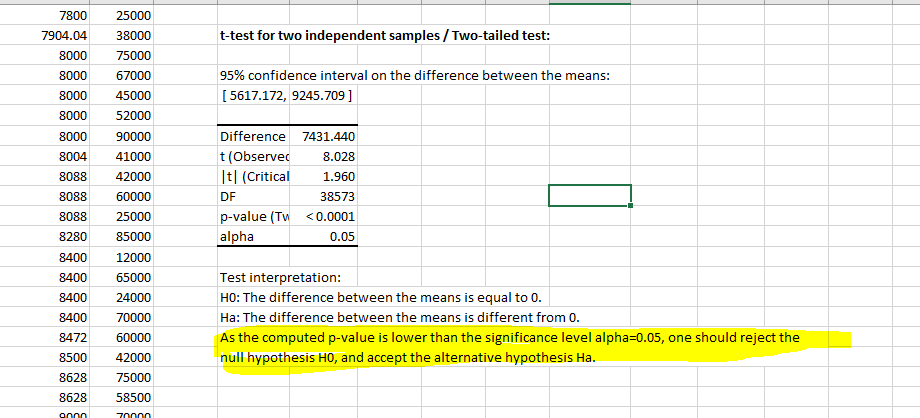


### 2) dti

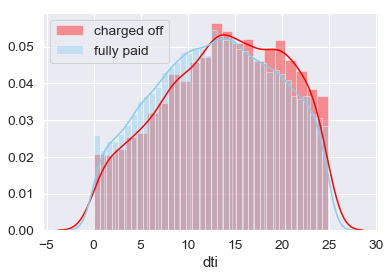

In [331]:
sns.distplot( numeric_data['dti'] , color="red", label="charged off")
sns.distplot( numeric_data_paid['dti'] , color="skyblue", label="fully paid")
plt.legend()
plt.show()

**Inference: Comparing the distribution between fully paid and charged off customers, the charged off customers have a slightly higher debt compared with other group:**

### 3) int_rate_in_pct

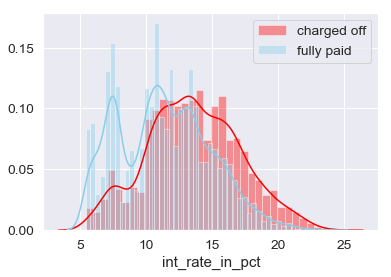

In [332]:
sns.distplot( numeric_data['int_rate_in_pct'] , color="red", label="charged off")
sns.distplot( numeric_data_paid['int_rate_in_pct'] , color="skyblue", label="fully paid")
plt.legend()
plt.show()

**Inference: The charged off customers had opted for higher percentage of interest compared with fully paid customers. So interest rate can be a significant indicator of charge off.**

### 4) revol_util_in_pct

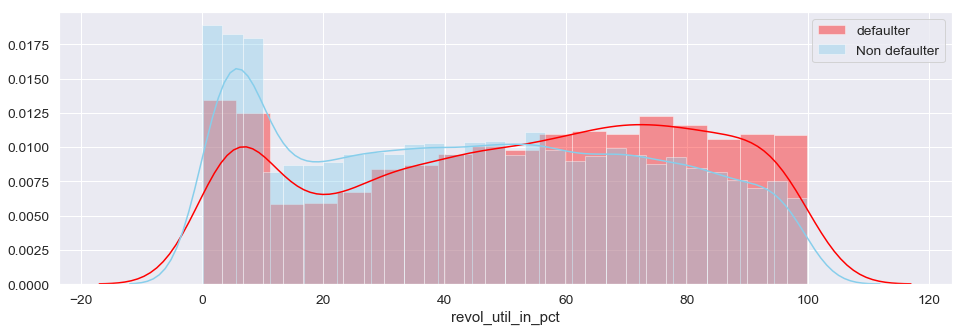

In [333]:
plt.figure(figsize=(16, 5))
sns.distplot(loan_charged_off_df.revol_util_in_pct.dropna(), color="red", label="defaulter")
sns.distplot(loan_not_charged_off_df.revol_util_in_pct.dropna(), color="skyblue", label="Non defaulter")
plt.legend()
plt.show()

**Inference: The feature 'revol_util' shows deviation between 'Fully Paid' and 'Charged off customers'. This could be used as indicator if the current customers could default**

### 5) delinq_2_years

**Inference: Comparing the distribution between fully paid and charged off customers, the charged off customers have taken a higher interest rate compared with other group:**

#### <font color=blue> T-Test to identify mean deviation between 'Fully Paid' and 'Charged off' customers, with regards to feature 'delinq_2_years'</blue>

H0: Mean of delinq_2 years of Fully paid customer = Mean of delinq_2_years of Charged off Customer <br>
Ha: Mean of delinq_2 years of Fully paid customer not equal to Mean of delinq_2 years of Charged off customers <br> Students T test for unpaired group was done with XLSTAT and results attached below <br>
As the computed p-value is lower than the significance level alpha=0.05, one should reject the null hypothesis H0, and accept the alternative hypothesis Ha.<br>
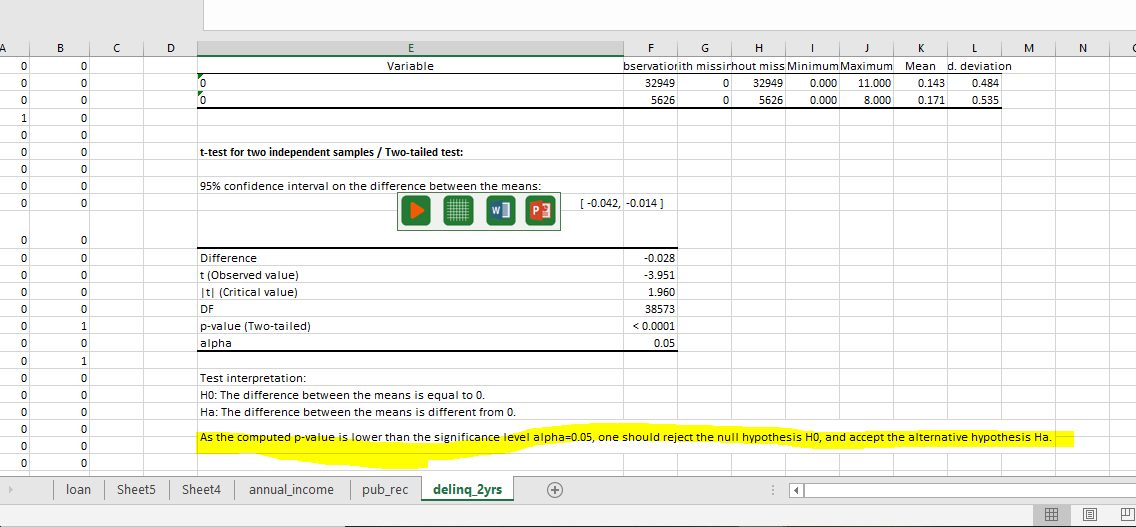

### 6) loan_amnt

#### a) emp_title

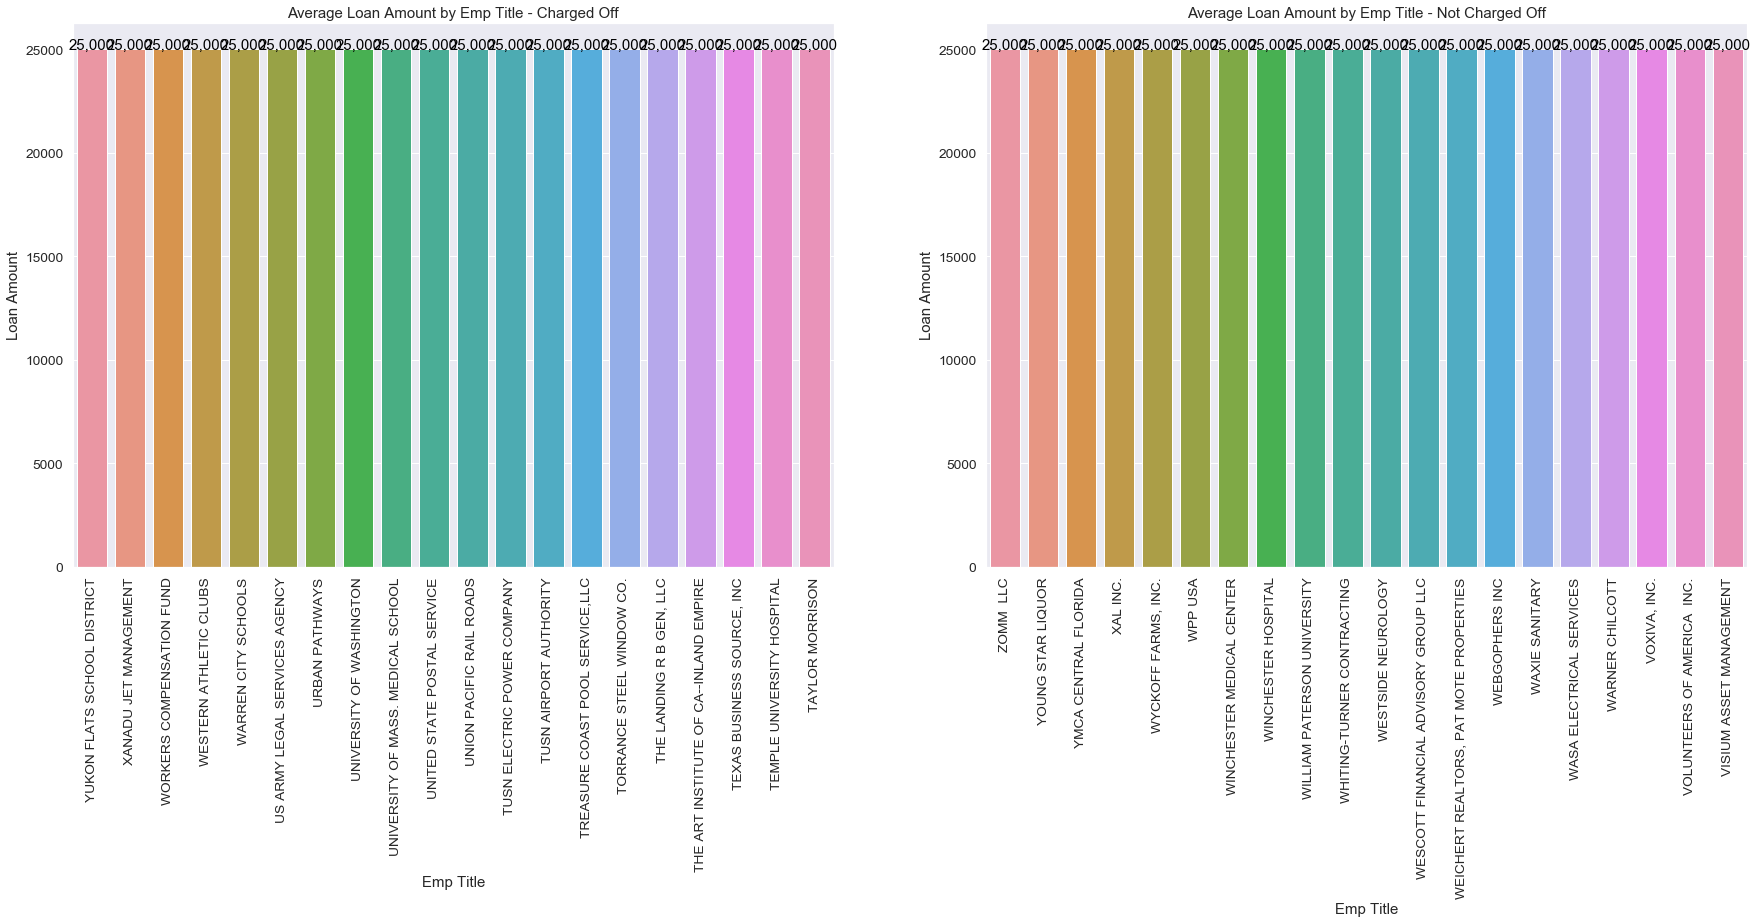

In [334]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'emp_title', 'loan_amnt', 'Emp Title', 'Loan Amount',
                              'Average Loan Amount by Emp Title - Charged Off', estimator='mean', top = 20, 
                              rotate_lbl_degree = 90,
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'emp_title', 'loan_amnt', 'Emp Title', 'Loan Amount',
                              'Average Loan Amount by Emp Title - Not Charged Off', estimator='mean', top = 20, 
                              rotate_lbl_degree = 90,
                              subplot = True)
plt.show()

##### emp_title doesn't seem to have any relation with charged-off loan amounts

#### b) emp_length_in_yrs

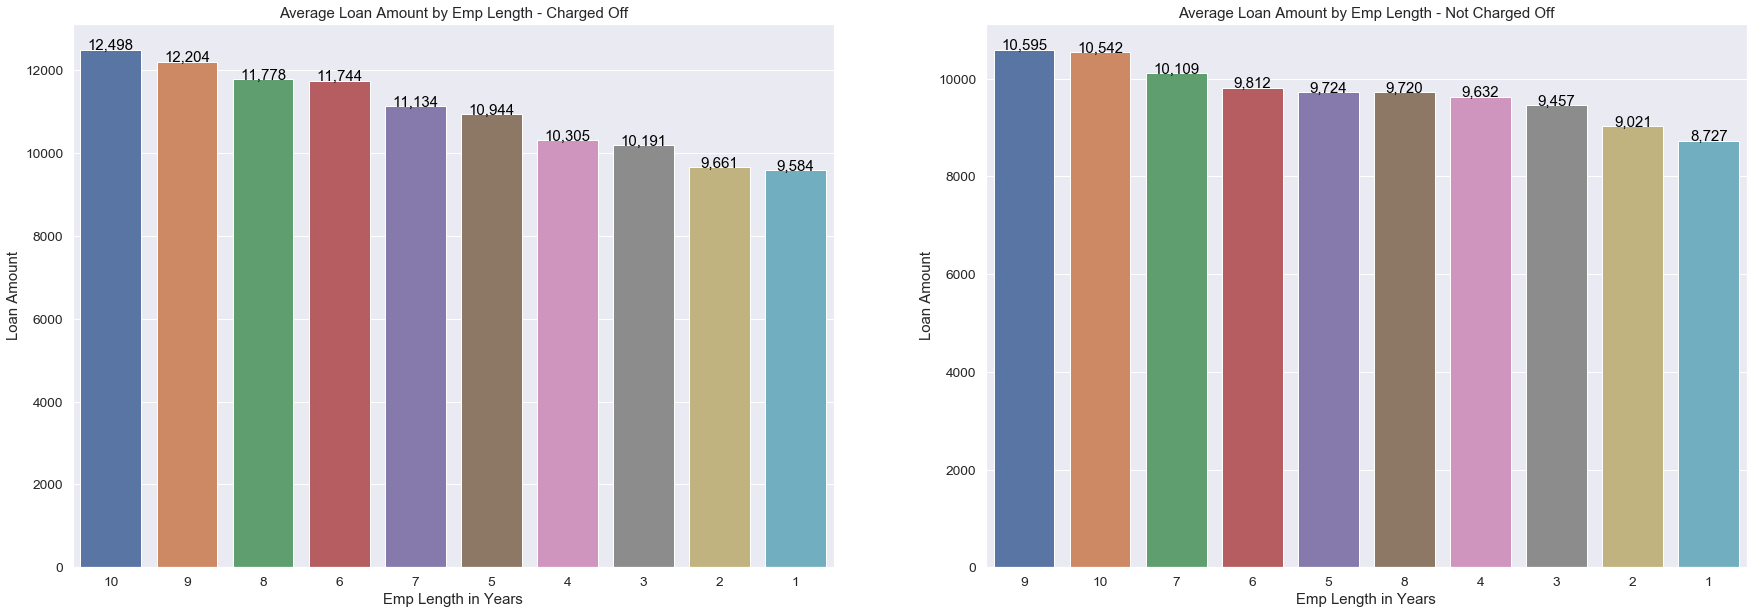

In [335]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'emp_length_in_yrs', 'loan_amnt', 'Emp Length in Years', 'Loan Amount',
                              'Average Loan Amount by Emp Length - Charged Off', estimator='mean',
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'emp_length_in_yrs', 'loan_amnt', 'Emp Length in Years', 
                              'Loan Amount',
                              'Average Loan Amount by Emp Length - Not Charged Off', estimator='mean',
                              subplot = True)
plt.show()

##### emp_length_in_yrs doesn't seem to have any relation with charged-off loan amounts

#### c) title

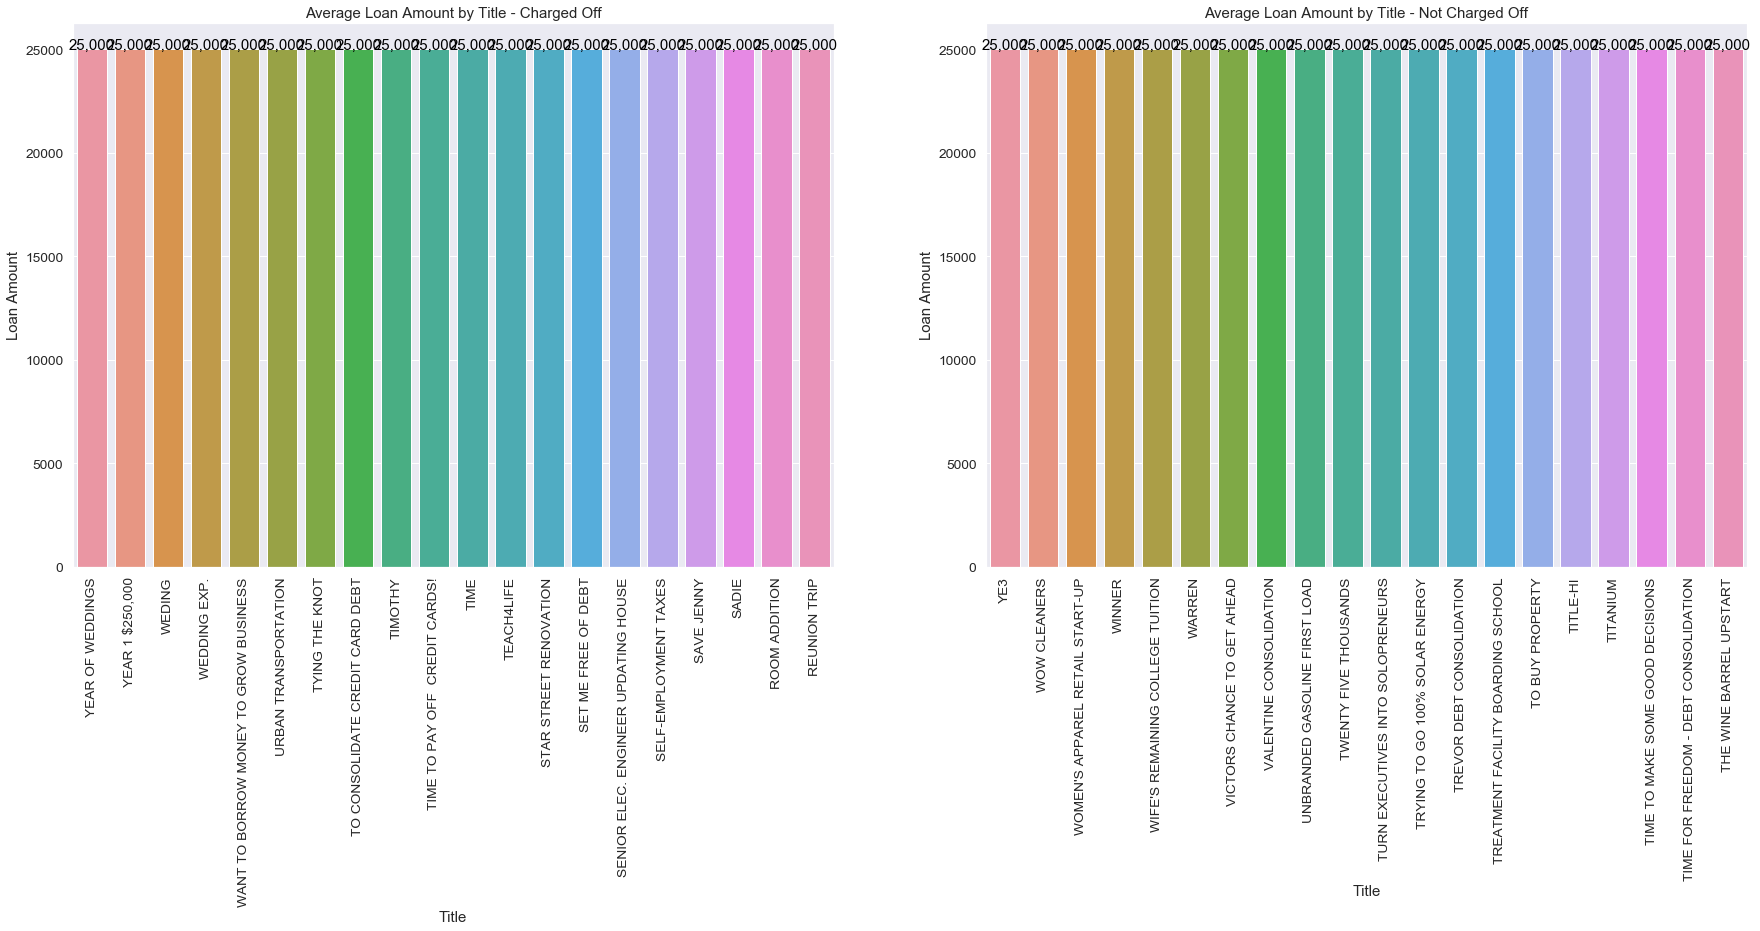

In [336]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'title', 'loan_amnt', 'Title', 'Loan Amount',
                              'Average Loan Amount by Title - Charged Off', estimator='mean', rotate_lbl_degree = 90,
                              subplot = True, top = 20)

# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'title', 'loan_amnt', 'Title', 'Loan Amount',
                              'Average Loan Amount by Title - Not Charged Off', estimator='mean', rotate_lbl_degree = 90,
                              subplot = True, top = 20)
plt.show()

##### title doesn't seem to have any relation with charged-off loan amounts

#### d) zip_code

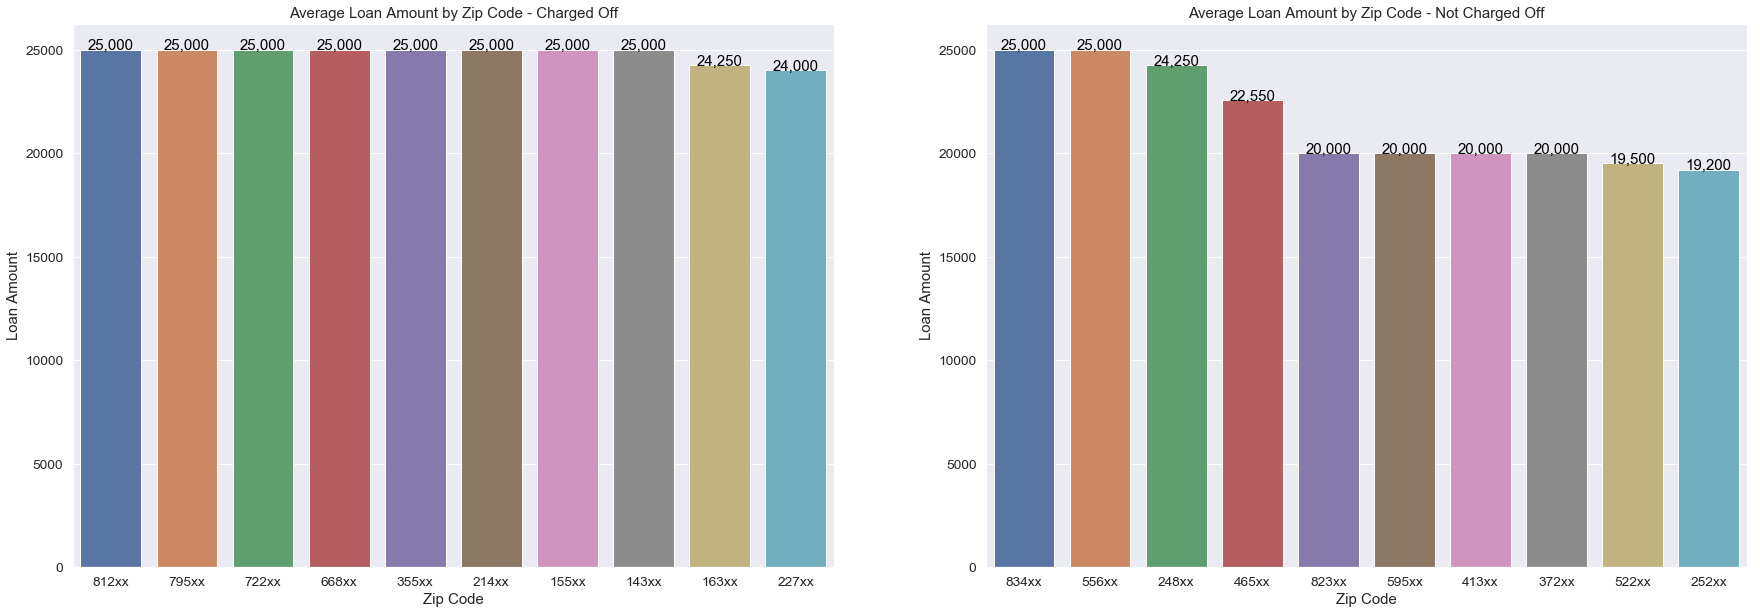

In [337]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'zip_code', 'loan_amnt', 'Zip Code', 'Loan Amount',
                              'Average Loan Amount by Zip Code - Charged Off', estimator='mean', top = 10,
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'zip_code', 'loan_amnt', 'Zip Code', 'Loan Amount',
                              'Average Loan Amount by Zip Code - Not Charged Off', estimator='mean', top = 10,
                              subplot = True)
plt.show()

#### e) addr_state

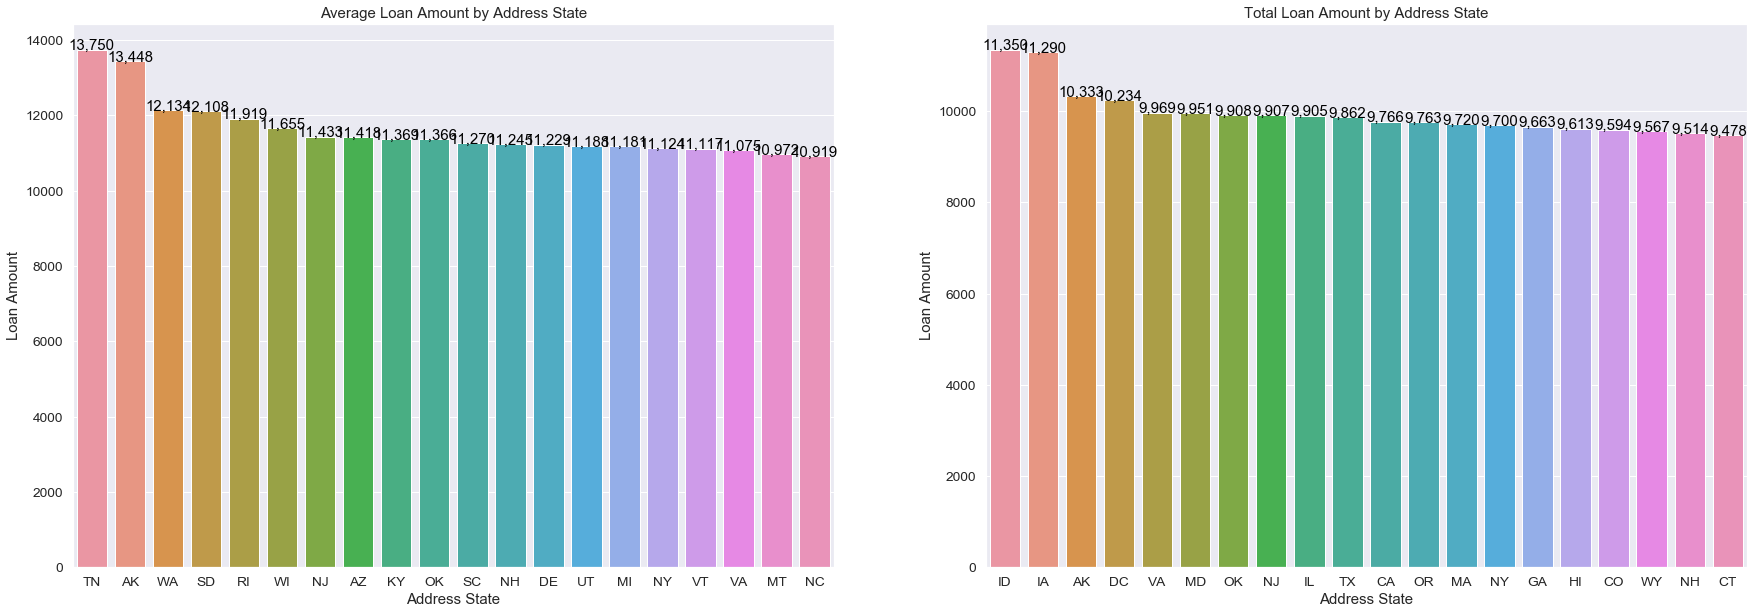

In [338]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'addr_state', 'loan_amnt', 'Address State', 'Loan Amount',
                              'Average Loan Amount by Address State', estimator='mean',
                              subplot = True, top = 20)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'addr_state', 'loan_amnt', 'Address State', 'Loan Amount',
                              'Total Loan Amount by Address State', estimator='mean',
                              subplot = True, top = 20)
plt.show()

##### addr_state seem to have relation with charged-off loan amounts

#### f) inq_last_6mths

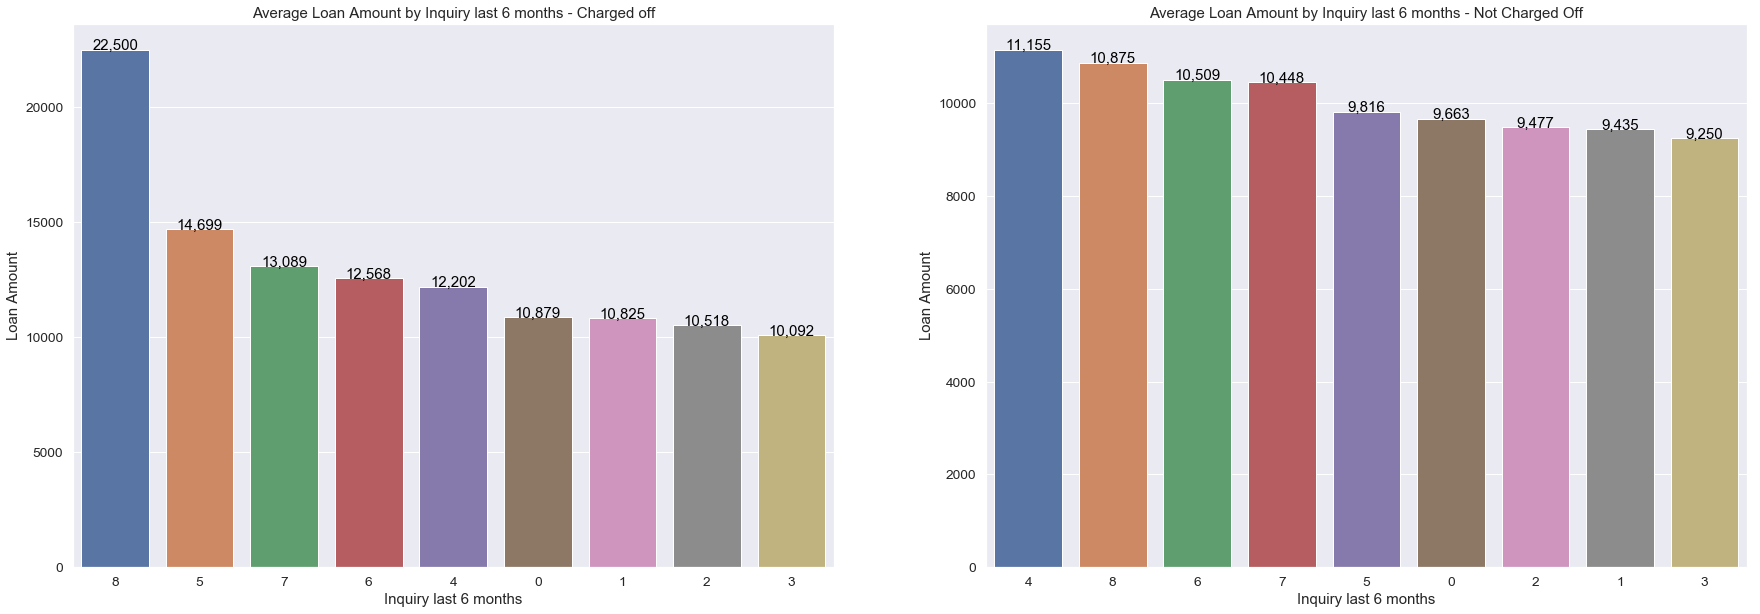

In [339]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'inq_last_6mths', 'loan_amnt', 'Inquiry last 6 months', 'Loan Amount',
                              'Average Loan Amount by Inquiry last 6 months - Charged off', estimator='mean',
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'inq_last_6mths', 'loan_amnt', 'Inquiry last 6 months', 
                              'Loan Amount',
                              'Average Loan Amount by Inquiry last 6 months - Not Charged Off', estimator='mean',
                              subplot = True)
plt.show()

##### inq_last_6mths seem to have relation with charged-off loan amounts

#### g) pub_rec

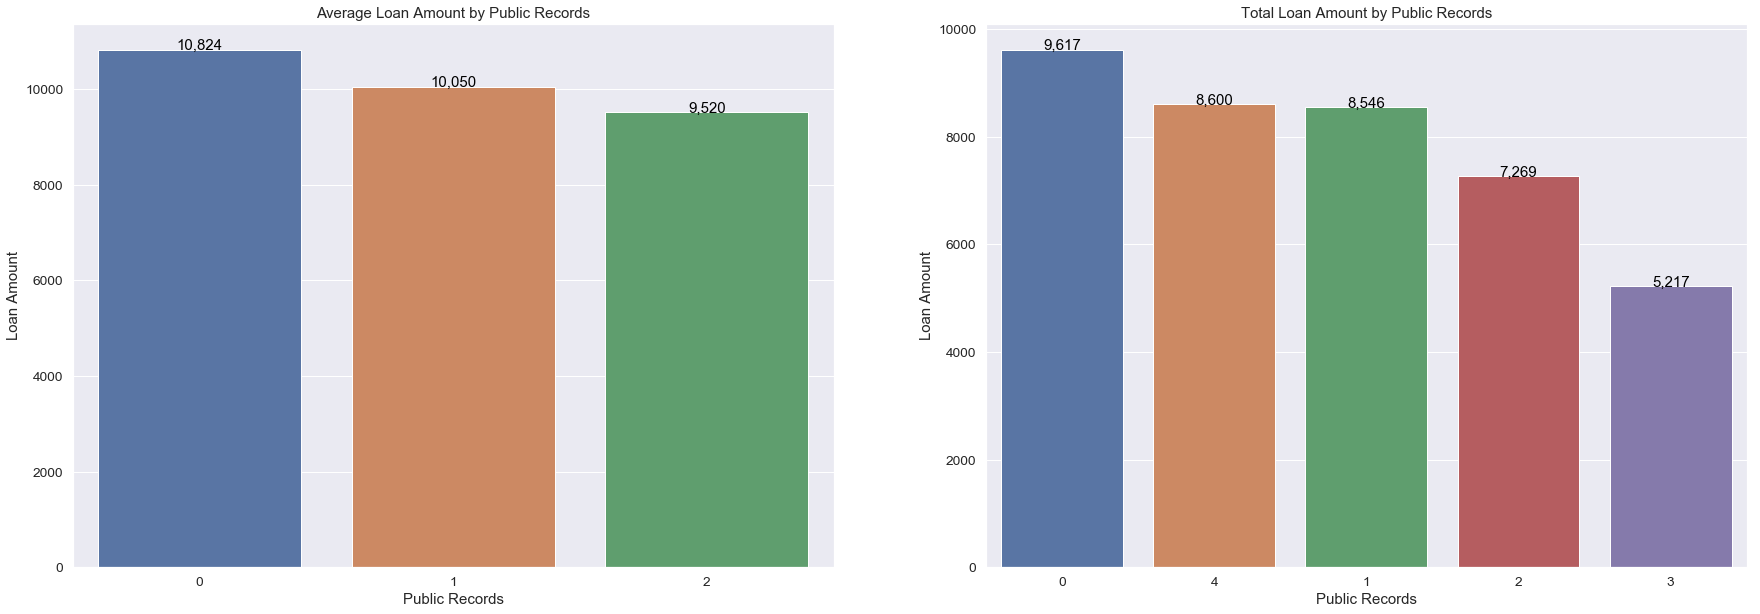

In [340]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'pub_rec', 'loan_amnt', 'Public Records', 'Loan Amount',
                              'Average Loan Amount by Public Records', estimator='mean',
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'pub_rec', 'loan_amnt', 'Public Records', 'Loan Amount',
                              'Total Loan Amount by Public Records', estimator='mean',
                              subplot = True)
plt.show()

##### pub_rec doesn't seem to have any relation with charged-off loan amounts

#### h) delinq_2yrs

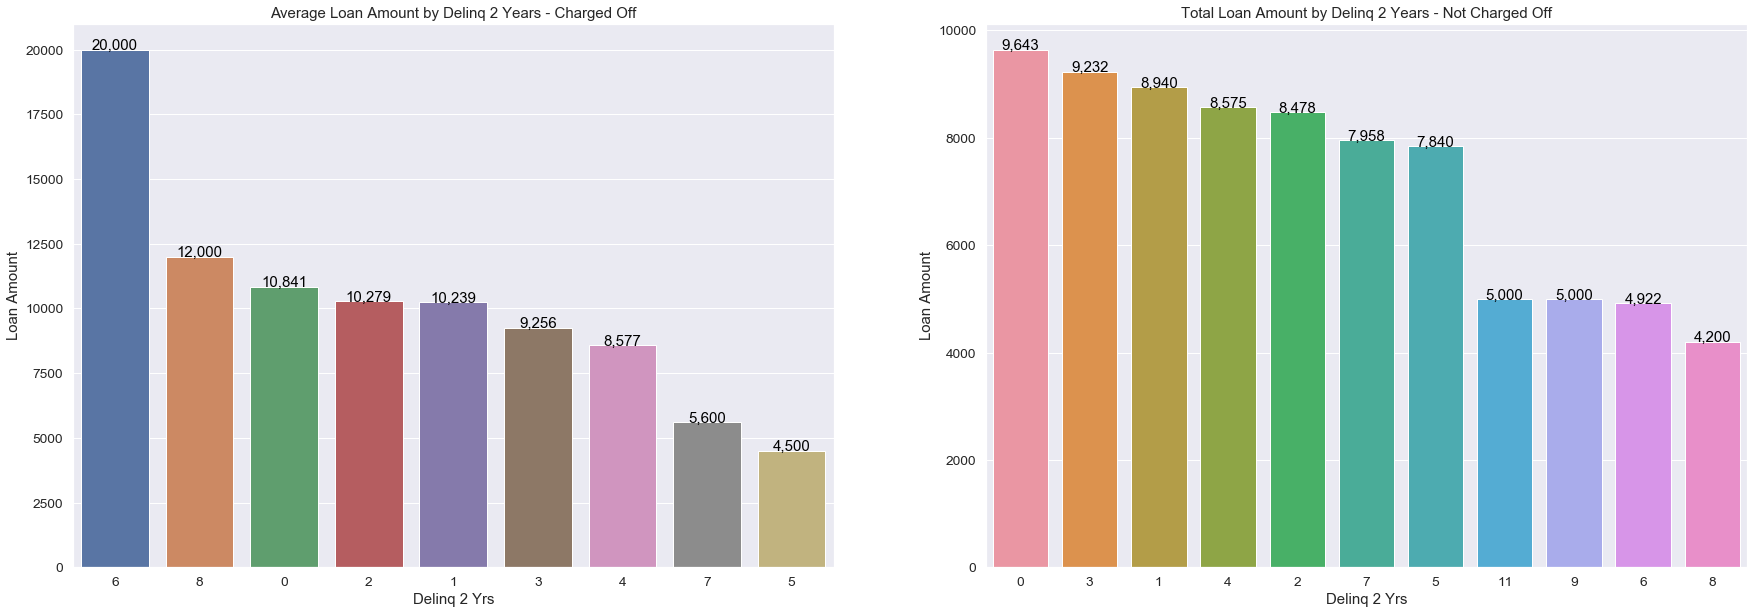

In [341]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'delinq_2yrs', 'loan_amnt', 'Delinq 2 Yrs', 'Loan Amount',
                              'Average Loan Amount by Delinq 2 Years - Charged Off', estimator='mean',
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'delinq_2yrs', 'loan_amnt', 'Delinq 2 Yrs', 'Loan Amount',
                              'Total Loan Amount by Delinq 2 Years - Not Charged Off', estimator='mean',
                              subplot = True)
plt.show()

##### delinq_2yrs seem to have relation with charged-off loan amounts

#### i) term_in_months

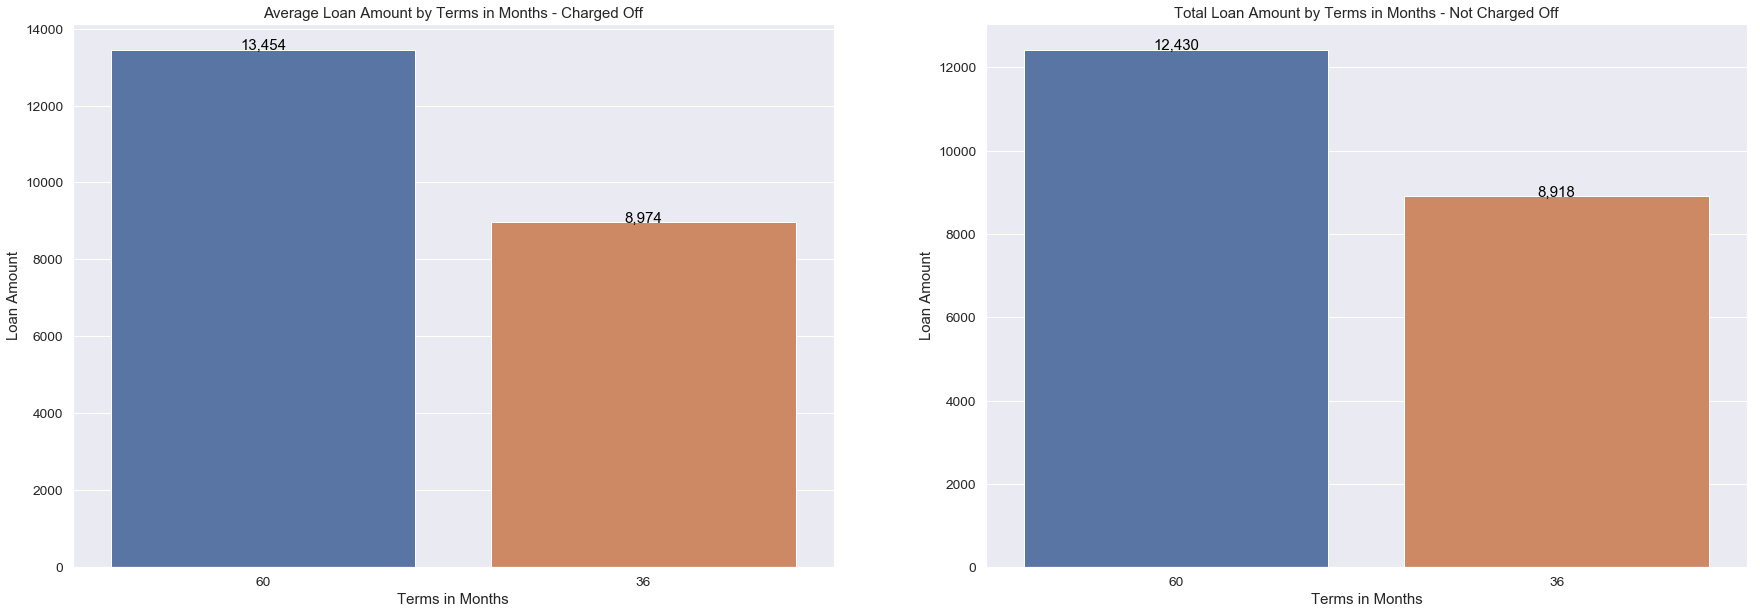

In [342]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'term_in_months', 'loan_amnt', 'Terms in Months', 'Loan Amount',
                              'Average Loan Amount by Terms in Months - Charged Off', estimator='mean',
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'term_in_months', 'loan_amnt', 'Terms in Months', 'Loan Amount',
                              'Total Loan Amount by Terms in Months - Not Charged Off', estimator='mean',
                              subplot = True)
plt.show()

#####  The trend is same for both the customers 'Fully paid' and 'charged off" <br> The term seems not to be an influential factor for charge off

#### j) home_ownership

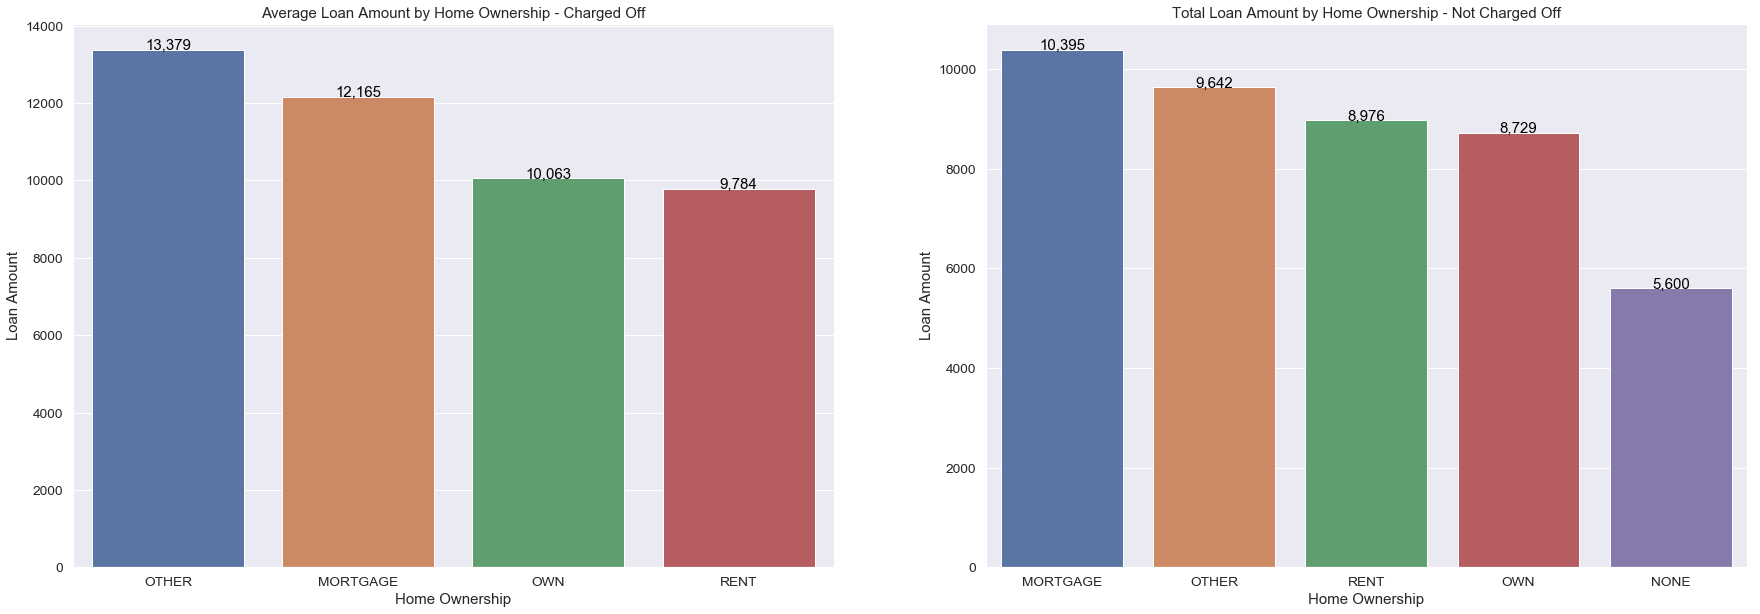

In [343]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'home_ownership', 'loan_amnt', 'Home Ownership', 'Loan Amount',
                              'Average Loan Amount by Home Ownership - Charged Off', estimator='mean',
                              subplot = True)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'home_ownership', 'loan_amnt', 'Home Ownership', 'Loan Amount',
                              'Total Loan Amount by Home Ownership - Not Charged Off', estimator='mean',
                              subplot = True)
plt.show()

##### Comparing the loan amounts between both the population, charged off and fully paid, the charged off customers had borrowed a higher sum compared with fully paid customers. So the accommodating type can have a significance

#### k) purpose

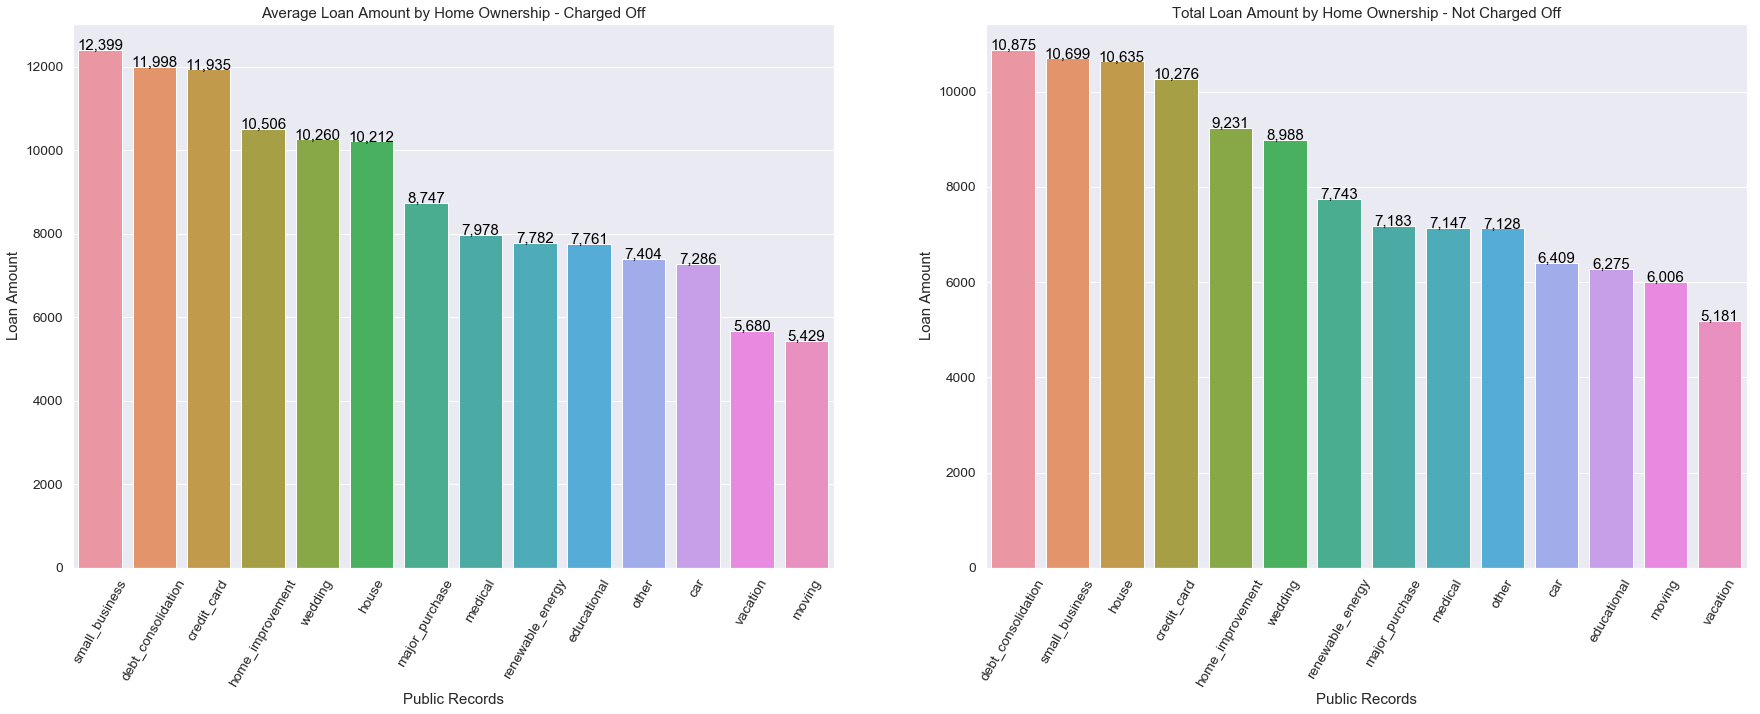

In [344]:
plt.figure(figsize=(30,10))
# subplot 1: average loan amount
plt.subplot(1, 2, 1)
segmented_univariate_analysis(loan_charged_off_df, 'purpose', 'loan_amnt', 'Public Records', 'Loan Amount',
                              'Average Loan Amount by Home Ownership - Charged Off', estimator='mean',
                              subplot = True, rotate_lbl_degree = 60)
# subplot 2: total loan amount
plt.subplot(1, 2, 2)
segmented_univariate_analysis(loan_not_charged_off_df, 'purpose', 'loan_amnt', 'Public Records', 'Loan Amount',
                              'Total Loan Amount by Home Ownership - Not Charged Off', estimator='mean',
                              subplot = True, rotate_lbl_degree = 60)
plt.show()

##### purpose doesn't seem to have any relation with charged-off loan amounts

## Bivariate Analysis

### 1) Annual Inc

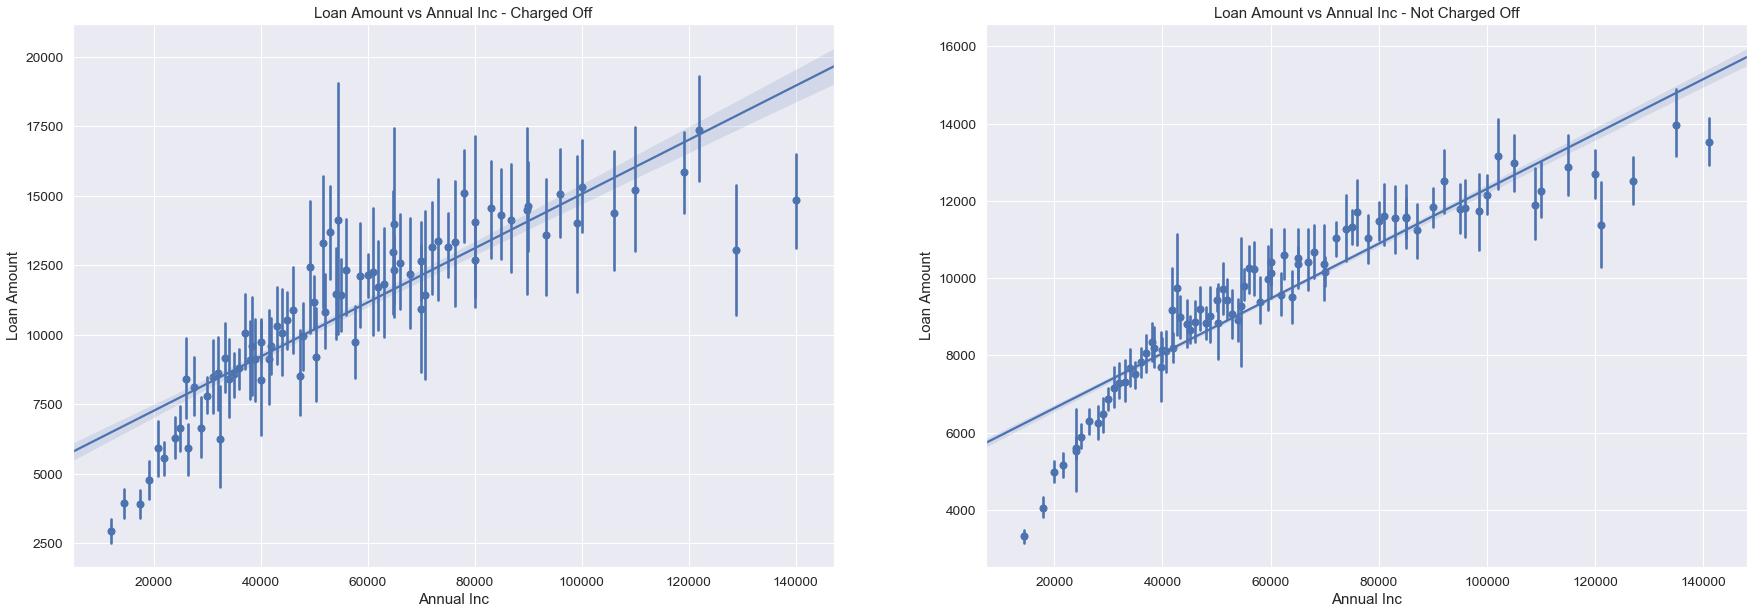

In [345]:
plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
charged_off_plt =  sns.regplot(x='annual_inc', y= 'loan_amnt', data= loan_charged_off_df, x_bins = 100, 
                               x_estimator = np.mean)
plt.title('Loan Amount vs Annual Inc - Charged Off')
charged_off_plt.set(xlabel = 'Annual Inc', ylabel='Loan Amount')
plt.subplot(1,2,2)
not_charged_off_plt = sns.regplot(x='annual_inc', y= 'loan_amnt', data= loan_not_charged_off_df, x_bins = 100, 
                                  x_estimator = np.mean)
not_charged_off_plt.set(xlabel = 'Annual Inc', ylabel='Loan Amount')
plt.title('Loan Amount vs Annual Inc - Not Charged Off')
plt.show()

**Inference: The charged off customers had taken a higher loan amount for a given income, compared with "not charged off (fully paid) customers. So the income of customer can be considered as a significant indicator for futureloan status (fully paid, charged off )**

### 2) delinq_2yrs

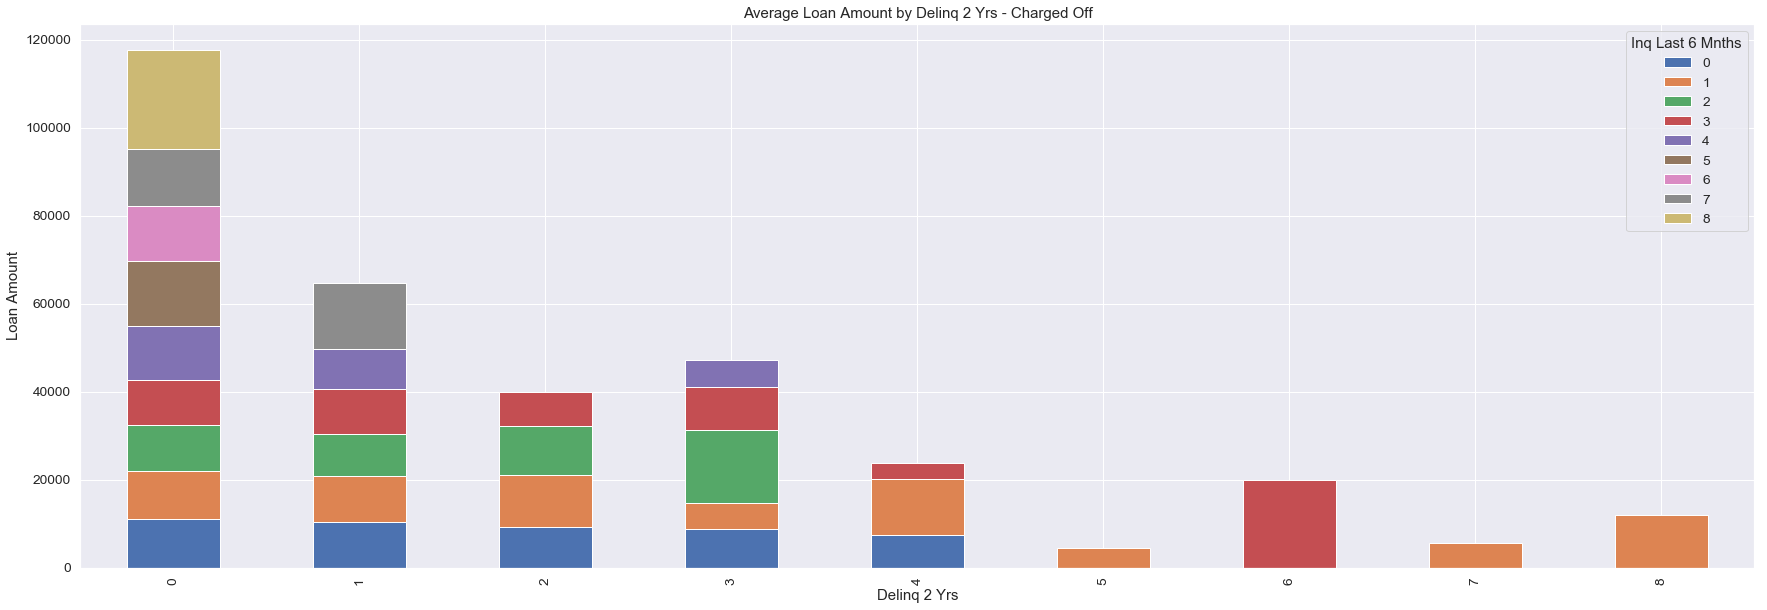

In [346]:
charged_off_df_plot = loan_charged_off_df.groupby(['inq_last_6mths', 'delinq_2yrs'])['loan_amnt'].agg('mean')\
.reset_index().pivot(columns='inq_last_6mths', index='delinq_2yrs', values='loan_amnt')
charged_off_plot = charged_off_df_plot.plot(kind='bar', stacked=True, figsize=(30,10), 
                                title='Average Loan Amount by Delinq 2 Yrs - Charged Off')
charged_off_plot.set(xlabel = 'Delinq 2 Yrs', ylabel='Loan Amount')
charged_off_plot.legend(title = "Inq Last 6 Mnths")
plt.show()

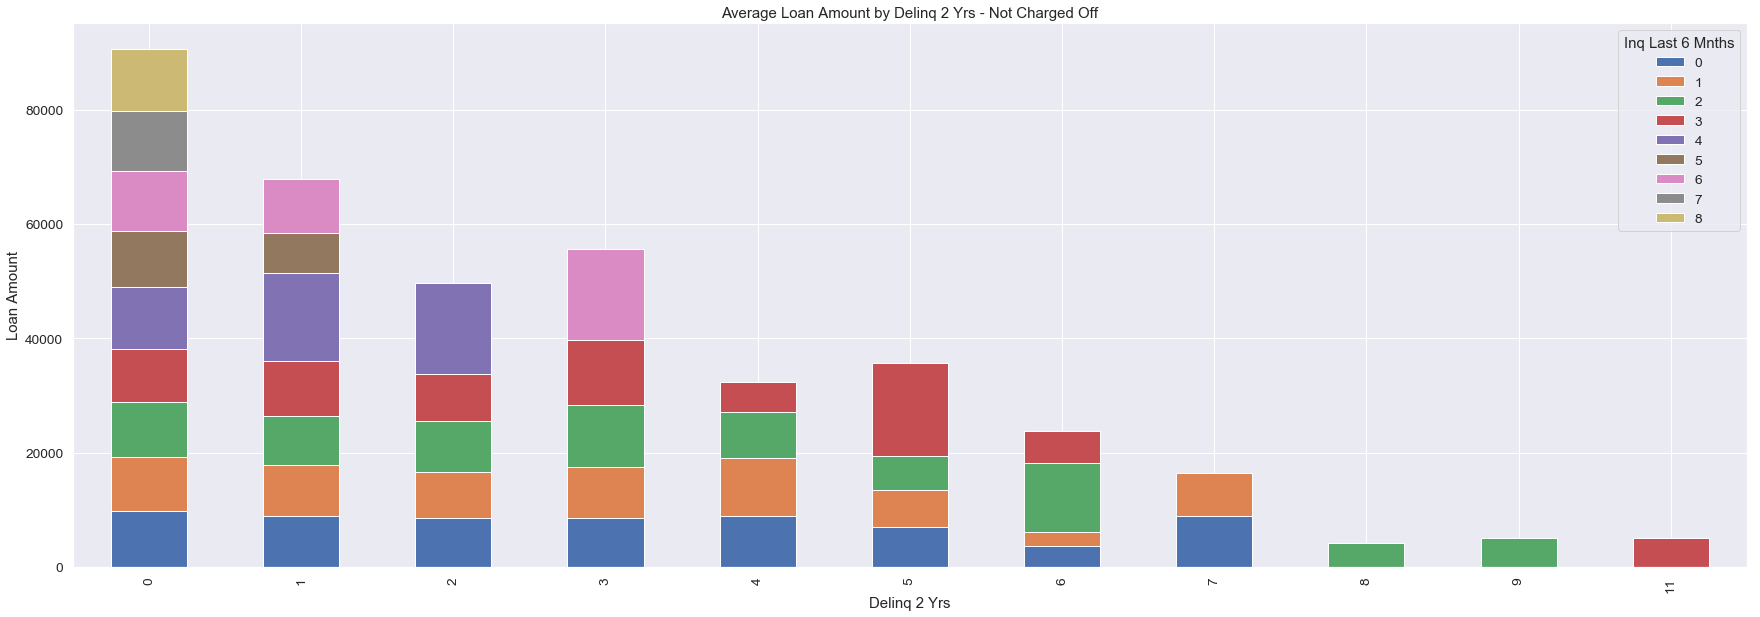

In [347]:
not_charged_off_df_plot = loan_not_charged_off_df.groupby(['inq_last_6mths', 'delinq_2yrs'])['loan_amnt'].agg('mean')\
.reset_index().pivot(columns='inq_last_6mths', index='delinq_2yrs', values='loan_amnt')
not_charged_off_plot = not_charged_off_df_plot.plot(kind='bar', stacked=True, figsize=(30,10), 
                                title='Average Loan Amount by Delinq 2 Yrs - Not Charged Off')
not_charged_off_plot.set(xlabel = 'Delinq 2 Yrs', ylabel='Loan Amount')
not_charged_off_plot.legend(title = "Inq Last 6 Mnths")
plt.show()

**Inference <br> With charged off customers, the feature delinq 2 years <font color=blue>has a strong indicator </font>with loan amount compared with fully paid customer. From this plot, it can be inferred deling_2_years is a strong indicator for loan default.** 

### 3) addr_state

#### a) delinq_2yrs

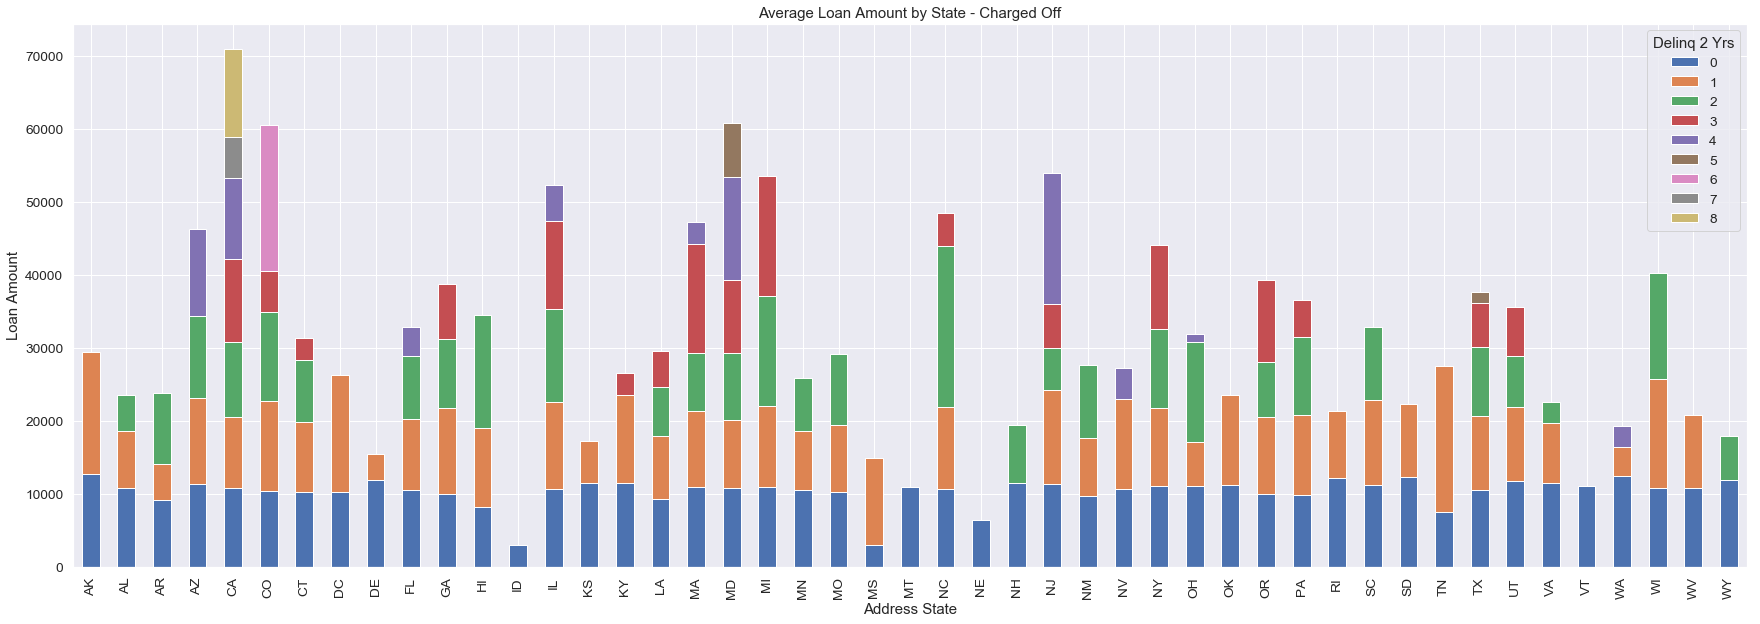

In [348]:
charged_off_df_plot = loan_charged_off_df.groupby(['addr_state', 'delinq_2yrs'])['loan_amnt'].agg('mean')\
.sort_values(ascending = False).reset_index().pivot(columns='delinq_2yrs', index='addr_state', values='loan_amnt')
charged_off_plot = charged_off_df_plot.plot(kind='bar', stacked=True, figsize=(30,10), 
                                title='Average Loan Amount by State - Charged Off')
charged_off_plot.set(xlabel = 'Address State', ylabel='Loan Amount')
charged_off_plot.legend(title = "Delinq 2 Yrs")
plt.show()

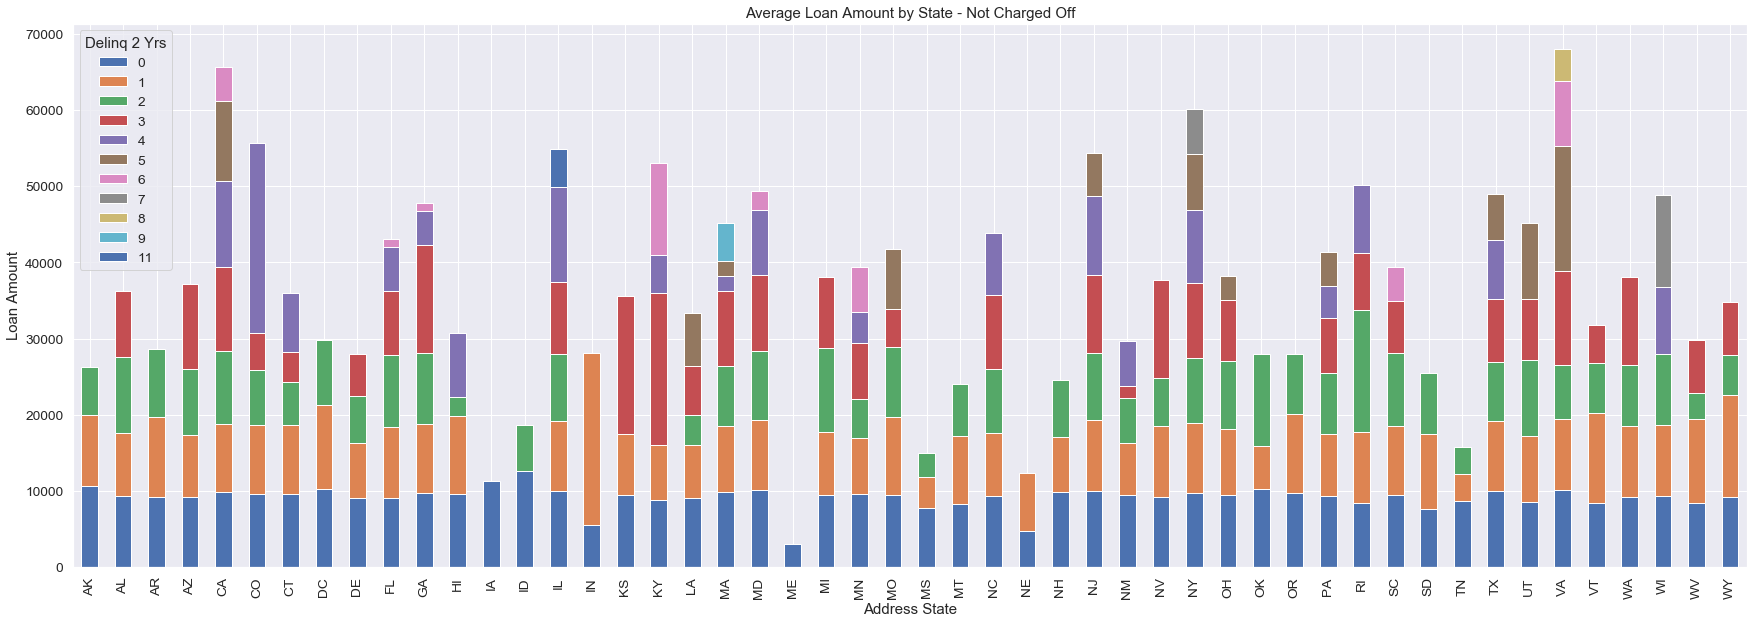

In [349]:
not_charged_off_df_plot = loan_not_charged_off_df.groupby(['addr_state', 'delinq_2yrs'])['loan_amnt'].agg('mean')\
.sort_values(ascending = False).reset_index().pivot(columns='delinq_2yrs', index='addr_state', values='loan_amnt')
not_charged_off_df_plot = not_charged_off_df_plot.plot(kind='bar', stacked=True, figsize=(30,10), 
                                title='Average Loan Amount by State - Not Charged Off')
not_charged_off_df_plot.set(xlabel = 'Address State', ylabel='Loan Amount')
not_charged_off_df_plot.legend(title = "Delinq 2 Yrs")
plt.show()

**Inference <br> There is  <font color=blue>no significant difference </font> observed between charged off and fully paid customers when correlating delinq_2_yrs with address state and comparing against loan amount** 

#### b) inq_last_6mths

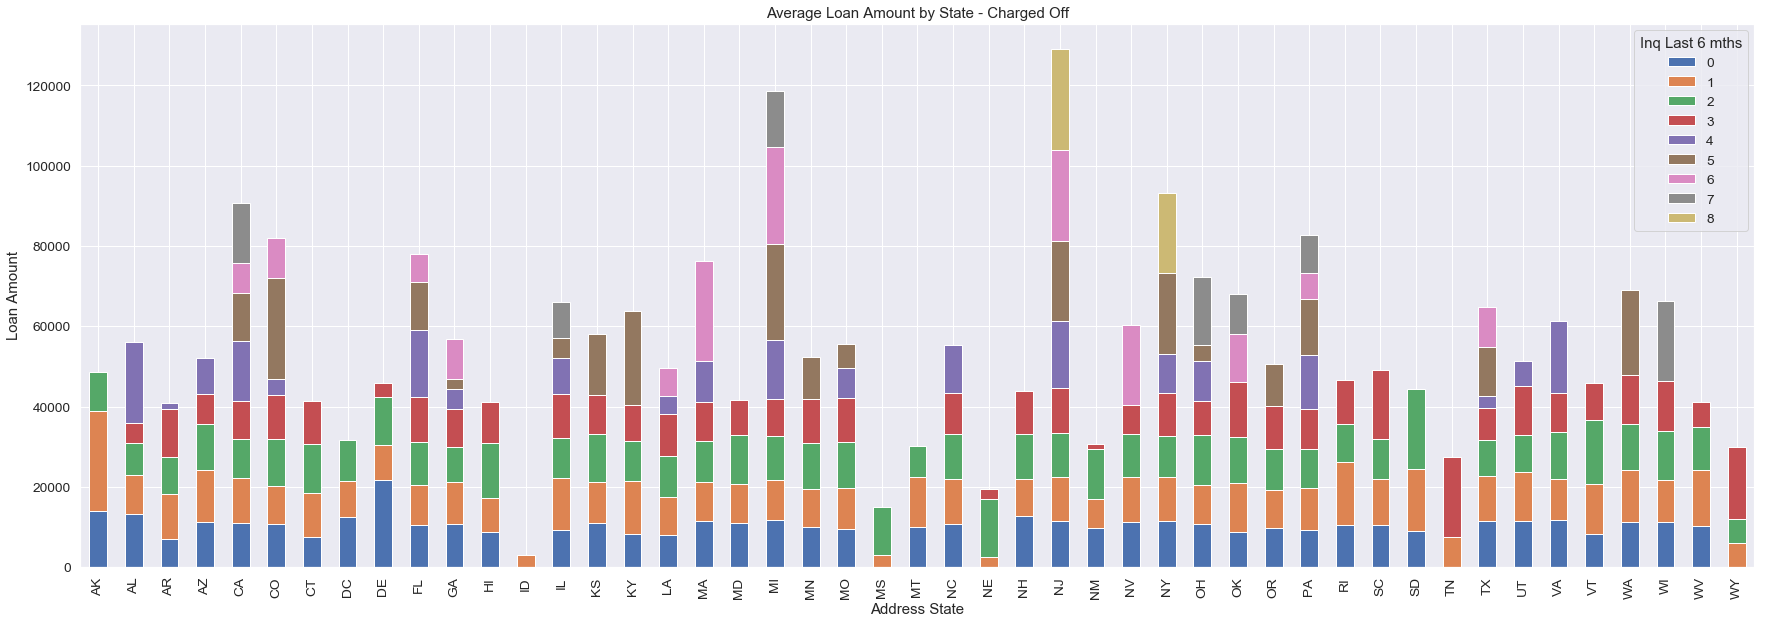

In [350]:
charged_off_df_plot = loan_charged_off_df.groupby(['addr_state', 'inq_last_6mths'])['loan_amnt'].agg('mean')\
.sort_values(ascending = False).reset_index().pivot(columns='inq_last_6mths', index='addr_state', values='loan_amnt')
charged_off_plot = charged_off_df_plot.plot(kind='bar', stacked=True, figsize=(30,10), 
                                title='Average Loan Amount by State - Charged Off')
charged_off_plot.set(xlabel = 'Address State', ylabel='Loan Amount')
charged_off_plot.legend(title = "Inq Last 6 mths")
plt.show()

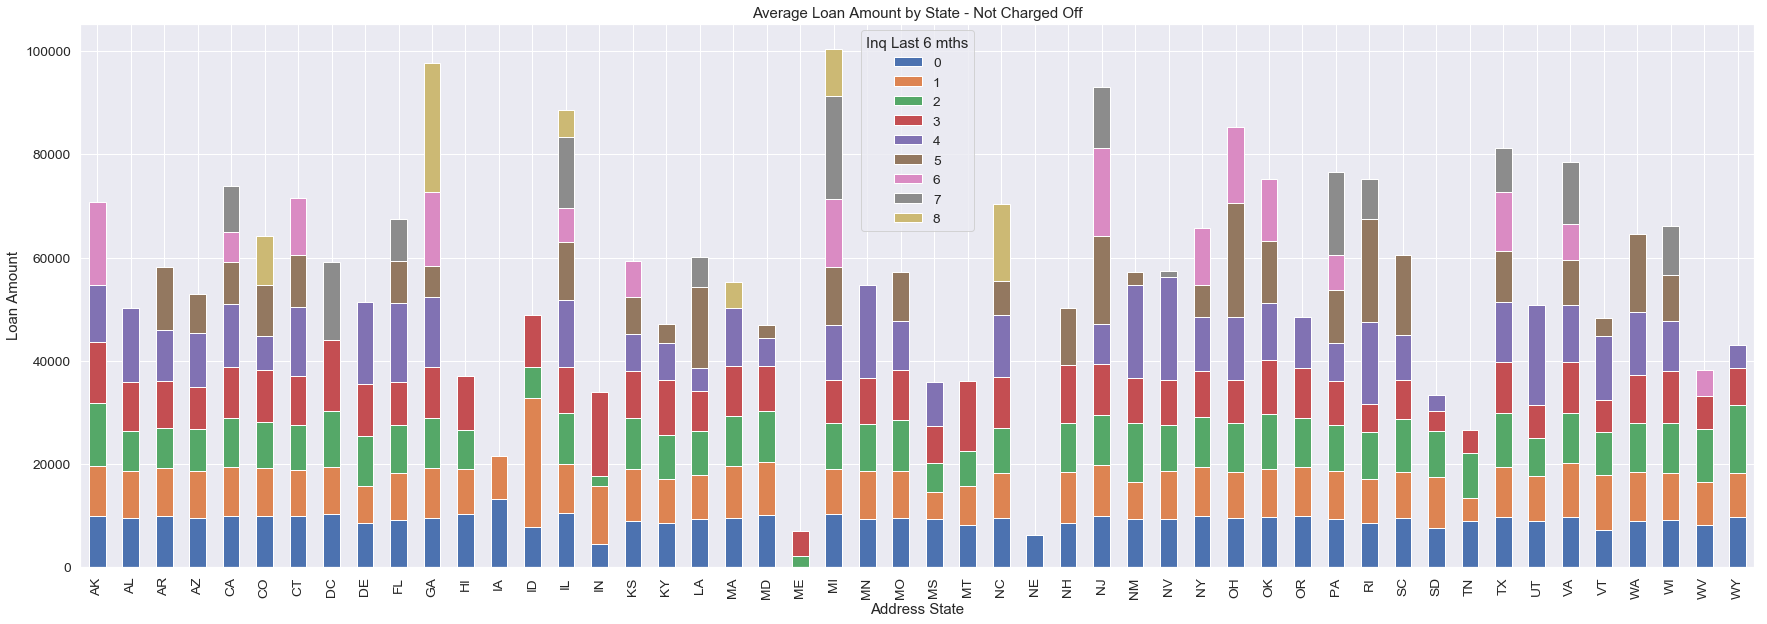

In [351]:
not_charged_off_df_plot = loan_not_charged_off_df.groupby(['addr_state', 'inq_last_6mths'])['loan_amnt'].agg('mean')\
.sort_values(ascending = False).reset_index().pivot(columns='inq_last_6mths', index='addr_state', values='loan_amnt')
not_charged_off_df_plot = not_charged_off_df_plot.plot(kind='bar', stacked=True, figsize=(30,10), 
                                title='Average Loan Amount by State - Not Charged Off')
not_charged_off_df_plot.set(xlabel = 'Address State', ylabel='Loan Amount')
not_charged_off_df_plot.legend(title = "Inq Last 6 mths")
plt.show()

**Inference: With charged off customers, the maximum loan amount is taken at NJ followed by MI and NY<br>With Fully paid customer the maximum loan amount is taken at MI, NJ. Since the rest of states does not present very distinct difference, the address state cannot provide a strong indicator for charge off**

## Derived Metrics

In [352]:
loan_df.columns

Index(['id', 'loan_amnt', 'term_in_months', 'int_rate_in_pct', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length_in_yrs',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util_in_pct',
       'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_d',
       'last_pymnt_amnt', 'last_credit_pull_d'],
      dtype='object')

### Time metrics

#### 1) last_credit_pull_d

In [353]:
#Create derived metrics month & year for the features with time
months = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,
          'September':9,'October':10,'November':11,'December':12,np.nan:'NaN','NaN':'NaN','NaT':'NaT'}

loan_df['credit_pull_month']=loan_df['last_credit_pull_d'].dt.month_name() 
loan_df['credit_pull_year']=loan_df['last_credit_pull_d'].dt.year

# Convert month name to month of the year
loan_df['credit_pull_month']=loan_df['credit_pull_month'].apply(lambda m: float(months[m]))

##### Checking if there is a trend in time of credit pull - Month

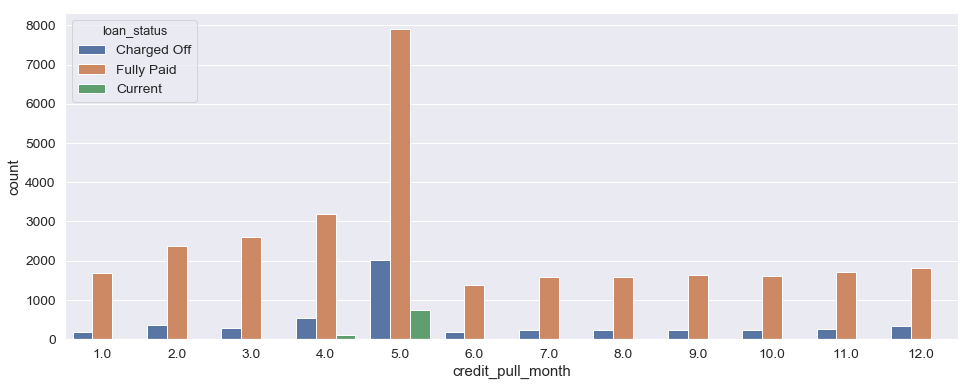

In [354]:
plt.figure(figsize=(16, 6))
sns.countplot(x='credit_pull_month', hue='loan_status',data=loan_df)
plt.show()

**Inference: The maximum frequency of credit pull happened during month of May <br> This trend is observed with both 'charged off' and 'Fully paid' customers**

##### Checking if there is a trend in time of credit pull - Year

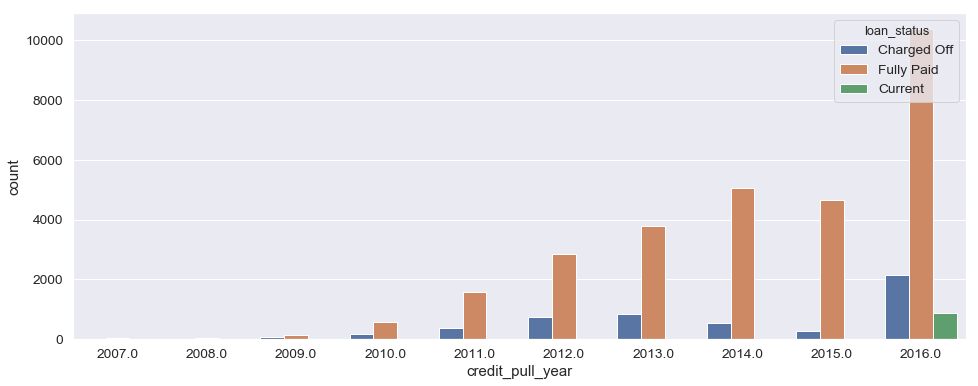

In [355]:
plt.figure(figsize=(16, 6))
sns.countplot(x='credit_pull_year', hue='loan_status',data=loan_df)
plt.show()

**Inference:  The maximum frequency of credit pull happened at 2016<br>This trend is observed with both 'charged off' and 'Fully paid' customers**

#### 2) issue_d

In [356]:
loan_df['issue_month']=loan_df['issue_d'].dt.month_name()
loan_df['issue_year']=loan_df['issue_d'].dt.year

# Convert month name to month of the year
loan_df['issue_month']=loan_df['issue_month'].apply(lambda m: float(months[m]))

##### Checking if there is a trend in time of borrow - Month

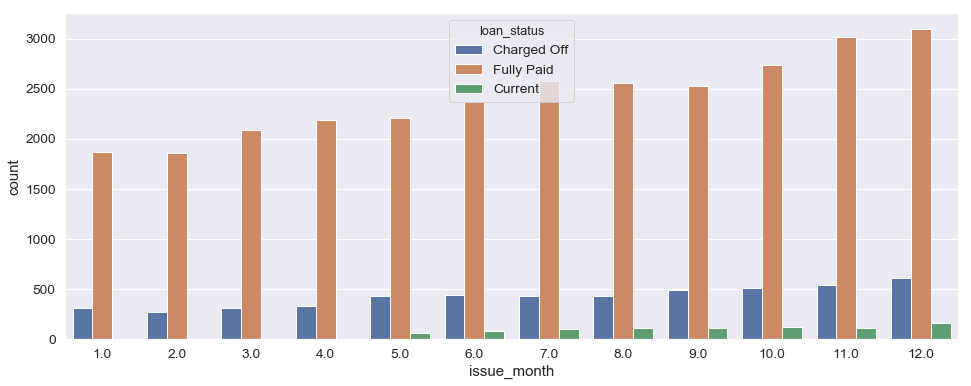

In [357]:
plt.figure(figsize=(16, 6))
sns.countplot(x='issue_month', hue='loan_status',data=loan_df)
plt.show()

**Inference: Most of the customers seem to borrow towards end of the year <br> The maximum frequency of borrowing happens at December.<br>This trend is observed with both 'charged off' and 'Fully paid' customers**

##### Checking if there is a trend in time of borrow - Year

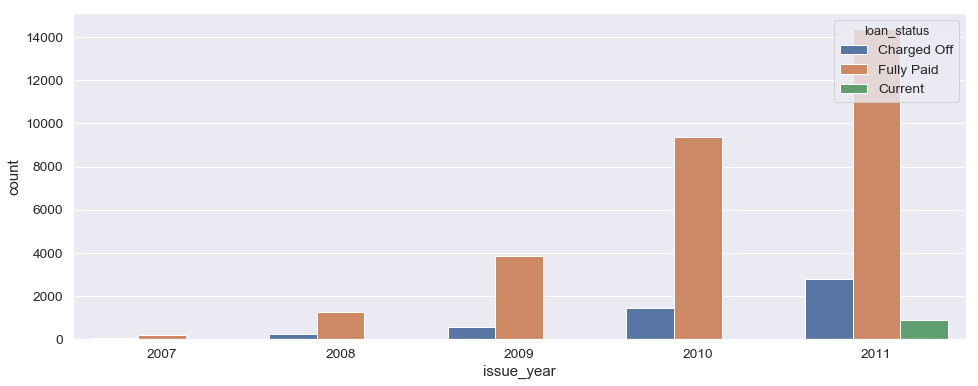

In [358]:
plt.figure(figsize=(16, 6))
sns.countplot(x='issue_year', hue='loan_status',data=loan_df)
plt.show()

**Inference: The maximum frequency of borrowing happened at 2011.<br>This trend is observed with both 'charged off' and 'Fully paid' customers**

#### 3) last_pymnt_d

In [359]:
loan_df['last_pay_month']=loan_df['last_pymnt_d'].dt.month_name() 
loan_df['last_pay_year']=loan_df['last_pymnt_d'].dt.year

# Convert month name to month of the year
loan_df['last_pay_month']=loan_df['last_pay_month'].apply(lambda m: float(months[m]))

##### Checking if there is a trend in time of repay - Month

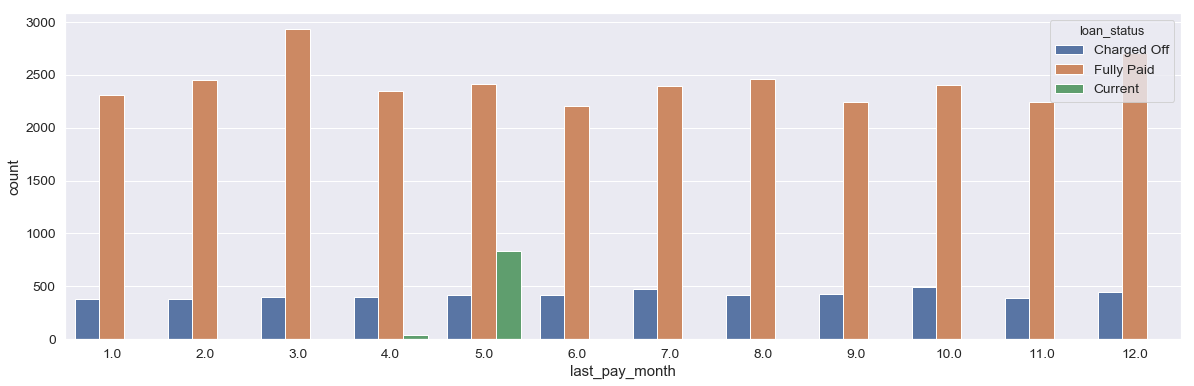

In [360]:
plt.figure(figsize=(20, 6))
sns.countplot(x='last_pay_month', hue='loan_status',data=loan_df)
plt.show()

**Inference: A significant trend is not observed here**

##### Checking if there is a trend in time of repay - Year

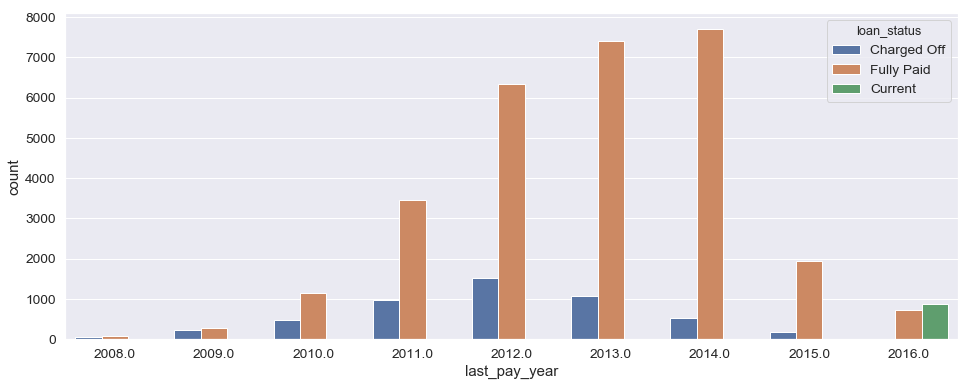

In [361]:
plt.figure(figsize=(16, 6))
sns.countplot(x='last_pay_year', hue='loan_status',data=loan_df)
plt.show()

**Inference: With customers who fully paid the loan, the frequency of repay is consistently increasing with year. This is proportional with trend of borrow  <br> With the charged off customers, the maximum repay happened during 2012 and after that year, the repay reduced. <br><font color=blue>It would be interesting to check if there was a recession (or) economic slow down at this time**

In [362]:
#Since we have new features, the dataframe is resplit to categoric and numeric
variable_data_analysis = variable_type_analysis(loan_df)
numeric_data = variable_data_analysis[0]
categorical_data = variable_data_analysis[1]

Total number of quantitative variable and categorical variable is as follows : 23 , 15


### ANOVA <br>  Let us perform analysis of variance between features to study their effect on loan status

#### ANOVA study on categorical data to study effect on loan status

In [363]:
anova_analysis_categorical_data(loan_df, categorical_data)

,feature,f,p
0,grade,2.989042e+02,0.000000e+00
1,sub_grade,5.689480e+01,0.000000e+00
6,loan_status,8.559056e+19,0.000000e+00
7,purpose,2.698514e+01,1.189646e-66
5,issue_d,6.276897e+00,1.186797e-42
4,verification_status,7.800212e+01,1.582219e-34
8,addr_state,3.169792e+00,6.050361e-13
2,emp_length_in_yrs,7.912852e+00,7.711738e-13
3,home_ownership,2.688547e+00,2.948673e-02


**Inference: Although the home ownership 'p' values is not greater than 0.05, it could be inferred it has a minor effect on loan status (Fully paid, Charged off)**

#### ANOVA study on numeric data to study effect on loan status

In [364]:
anova_analysis_numeric_data(loan_df, numeric_data)

,feature,f,p
1,term_in_months,1800.824653,0.000000e+00
2,int_rate_in_pct,14.799559,0.000000e+00
14,last_pay_year,250.540740,0.000000e+00
10,credit_pull_year,90.513717,1.410845e-185
9,credit_pull_month,51.533269,1.693531e-123
13,last_pay_month,51.122115,1.839175e-122
4,inq_last_6mths,25.417156,1.668637e-39
0,loan_amnt,1.837197,1.216807e-38
12,issue_year,38.254314,5.401589e-32
8,revol_util_in_pct,1.497764,4.162138e-20


**Inference: Although the 'p' values are not greater than 0.05, the top three features that has minor effect of loan status are <font color=blue>delinq_2yrs, mths_since_last_delinq and open_acc</font>**

### Derived metrics on zip code, home ownership and public data

From the previous study, it is observed that <font color=blue>home ownership, dti, annual income</font>are significant values.<br> Also it was noticed the customers who charged off differed from rest of the population on the features <font color=blue>'interest rate', 'repay term', 'loan amount'</font>. <br>It would be interesting to calculate the remaining salary for each customer after they had paid of their bills. <br>The bills would include <font color=blue>loan emi payment to lending club + other debts (dti) and rental or mortgage</font>. <br><br>If a customer had very less amount left after payment of bills, they are **likely to charge off**.<br> In order to get rental data, the zip code shared in dataset was merged with US public available dataset. <br>The average rent for houses in the specific area were considered.<br><br>URL for the public dataset on rental: https://files.hudexchange.info/reports/published/HOME_RentLimits_Natl_2019.xlsx


#### Reading data from Rental Public Dataset

In [365]:
# Create a new dataframe reading data from public dataset
homerent_df=pd.read_excel('HOME_RentLimits_Natl_2019.xlsx')
homerent_df.head()

,State,statename,County,cbsasub,areaname,fips2010,lowrent_0,lowrent_1,lowrent_2,lowrent_3,...,HomeRent50_4,HomeRent50_5,HomeRent50_6,HomeRent65_0,HomeRent65_1,HomeRent65_2,HomeRent65_3,HomeRent65_4,HomeRent65_5,HomeRent65_6
0,1,ALABAMA,1,METRO33860M33860,"Montgomery, AL MSA",100199999,577,618,742,856,...,956,1055,1153,735,789,948,1087,1193,1297,1403
1,1,ALABAMA,3,METRO19300M19300,"Daphne-Fairhope-Foley, AL MSA",100399999,660,706,847,979,...,1092,1205,1317,838,899,1081,1239,1363,1485,1607
2,1,ALABAMA,5,NCNTY01005N01005,"Barbour County, AL",100599999,451,483,580,670,...,747,824,901,566,608,732,837,915,991,1067
3,1,ALABAMA,7,METRO13820M13820,"Birmingham-Hoover, AL HUD Metro FMR Area",100799999,651,698,837,967,...,1080,1191,1302,826,887,1067,1224,1345,1466,1586
4,1,ALABAMA,9,METRO13820M13820,"Birmingham-Hoover, AL HUD Metro FMR Area",100999999,651,698,837,967,...,1080,1191,1302,826,887,1067,1224,1345,1466,1586


#### Reading data from Zip Code Public Dataset

In [366]:
# Create a new data frame reading data from zip code (public dataset)
zip_df=pd.read_csv('zipcode.csv')
zip_df.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,18570,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,41520,523.5,72003,Aguada,{'72003':100},False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,54689,667.9,72005,Aguadilla,{'72005':100},False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6615,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,29016,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",False,False,America/Puerto_Rico


#### Merge homerent data and zipcode using 'fips' 

In [367]:
homerent_df['fips']=homerent_df['fips2010'].apply(lambda s:str(s)[0:5]).astype('int64')
homerent_df=homerent_df.merge(zip_df, left_on='fips', right_on='county_fips')

#### Group by first three letters of zip code and find average house rent 

In [368]:
homerent_df['zip3']=homerent_df['zip'].apply(lambda s:str(s)[0:3]).astype('int64')
homerent_df['zip3digit']=homerent_df['zip3']
homerent_df=homerent_df.groupby(['zip3']).mean()[['lowrent_0','zip3digit']]

#### Merge loan dataframe with home rent data frame using first three letters of zipcode

In [369]:
loan_df.zip_code=loan_df['zip_code'].apply(lambda x:str(x).split('x')[0]).astype('int')
loan_df=loan_df.merge(homerent_df,left_on='zip_code',right_on='zip3digit')

#### For customers who OWN a house, the rental values are made 'ZERO'

In [370]:
loan_df.loc[loan_df['home_ownership']=='OWN','lowrent_0']=0

**Now that most of heavy lifting is done, next step is to calculate the outgoing amount from the customer<br>Following steps explain those:<br>EMI = Installment/Monthly Income <br> Rental payment = Rental/Monthly income <br>existing debt=dti**

#### Monthly installment to be paid to lending club/monthly salary

In [371]:
loan_df['emi']=loan_df['installment']/(loan_df['annual_inc']/12) 
# monthly rental/monthly salary
loan_df['rental']=loan_df['lowrent_0']/(loan_df['annual_inc']/12) 
loan_df['total_dti']=loan_df['emi']+(df['dti']/100)+loan_df['rental']

#### Since we have new features, the dataframe is resplit to customers who paid their loans and those who defaulted

In [372]:
default_df=loan_df[loan_df['loan_status']=='Charged Off']
paid_df=loan_df[loan_df['loan_status']=='Fully Paid']

#### Removing Outliers

In [373]:
default_df=remove_outlier(default_df, 'total_dti', 0.95)
paid_df=remove_outlier(paid_df, 'total_dti', 0.95)
paid_df=paid_df['total_dti'].dropna(axis='rows')
default_df=default_df['total_dti'].dropna(axis='rows')

#### Plotting graph

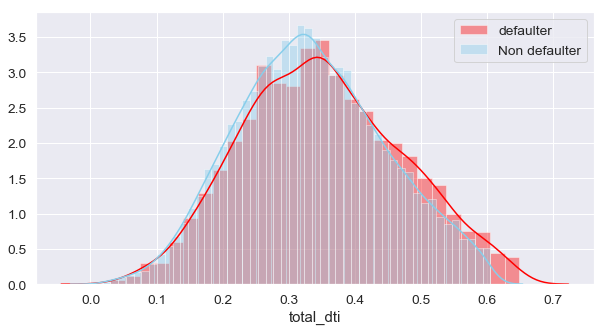

In [374]:
plt.figure(figsize=(10, 5))
sns.distplot(default_df, color="red", label="defaulter")
sns.distplot(paid_df, color="skyblue", label="Non defaulter")
plt.legend()
plt.show()

**Inference: There is shift observed between the populations of 'Fully Paid' and 'Charged off' customer. Lending club can use the features such as 'interest rate', 'dti', 'house accommodation', 'annual income' to identify if the customer would tend to population of 'charged off'**

## Summary <br> 


**From univariate and segmented analyses below features were identified as strong indicators of loan default<br>Annual Income<br>delinq_2_yrs<br>revol_util<br>dti<br>Term<br><br>From ANOVA study on categorical variables below features were identified as strong indicator of loan default<br>Home Ownership<br>delinq_2yrs<br><br>From derived variables, below features were identified as strong indicator of loan_default<br>Zip code <br>Rental data<br>Installment<br><br>Some interesting observations were identified with derived variables as follows:<br>During which month customers are likely to borrow loans?<br>With 'revol_util', lending club could identify potential defaulters from current users<br>Was there any economic significance during 2012-13 that resulted in many loan defaults?**